# Word Level Federated Text Generation: Pre-training centrally using Shakespeare's Text and fine-tuning on Stack Overflow in Federated style
- Arjun Singh
- 02-09-20

**About:**

This notebook runs the tensor-flow based training using an LSTM based network on Shakespeare text data and then leverages this pre-trained model to fine-tune Stackoverflow Data in a federated way using the TFF library.

loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip install tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [4]:
# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
from utils.dataset import construct_word_level_datasets, get_vocab, get_special_tokens

# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py
import utils.metrics as metrics

In [5]:
from utils.dataset import build_to_ids_fn

In [6]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [7]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [8]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: False
Build with GPU support: False
Num GPUs Available:  0


### Set Tensorflow to Use GPU

In [9]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
# tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')


### Test TFF

In [10]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model

### Important Note: The goal is to run the pre-training using some data (centrally) and then fine-tuning using different/new data in a federated manner. After a few experiments with how to go about this, we decided to only invoke the "construct_word_level_datasets()" function once with the centralized_train flag set to False. 

### This allows us to use the same train and val datasets as before for federated fine-tuning. However, now we get a much larger Test Dataset, which is actually being used to "centrally pre-train".

In [11]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000

## These are actually not the test examples but the train examples
## being generated for centralized pre-training
NUM_TEST_EXAMPLES = 50000

NUM_ROUNDS = 500
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS = 256

### Load and Preprocess Word Level Datasets

In [12]:
train_data, val_data, test_data = construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [13]:
type(train_data)

tensorflow_federated.python.simulation.client_data.ConcreteClientData

In [14]:
type(val_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [15]:
type(test_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

### Retrieve the Dataset Vocab

#### Here the vocab remains the same for both the pre-training and fine-tuning since we're leveraging the same dataset

In [16]:
vocab = get_vocab(VOCAB_SIZE)

In [17]:
len(vocab)

10000

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [18]:
pad, oov, bos, eos = get_special_tokens(VOCAB_SIZE)

In [19]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [ ]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [ ]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [ ]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

In [ ]:
EXTENDED_VOCAB_SIZE

### Define Function to Build Model

In [20]:
def build_model():
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model1_input = tf.keras.Input(shape=(None, ), # changed from MAX_SEQ_LENGTH
                                  name='model1_input')
    
    model1_embedding = tf.keras.layers.Embedding(input_dim=EXTENDED_VOCAB_SIZE,
                                                 output_dim=EMBEDDING_DIM,
                                                 mask_zero=True,
                                                 name='model1_embedding')(model1_input)
    
    model1_lstm = tf.keras.layers.LSTM(units=RNN_UNITS,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm')(model1_embedding)
    
    model1_dense1 = tf.keras.layers.Dense(units=EMBEDDING_DIM)(model1_lstm)
    
    model1_dense2 = tf.keras.layers.Dense(units=EXTENDED_VOCAB_SIZE)(model1_dense1)
    
    final_model = tf.keras.Model(inputs=model1_input, outputs=model1_dense2)
                 
    return final_model

### Define the Text Generation Strategy

In [21]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """
    
    start_words = [word.lower() for word in start_string.split(' ')]

    num_generate = 50
    input_eval = [word2idx[word] for word in start_words]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        #input_eval = tf.expand_dims([predicted_id], 0)
        input_eval = tf.concat([input_eval, tf.expand_dims([predicted_id], 0)], 1)
        text_generated.append(idx2word[predicted_id])

    return (' '.join(start_words) + ' ' + ' '.join(text_generated))

### Define Evaluation Metrics for Training

In [22]:
def get_metrics():
    
    evaluation_metrics = [
        metrics.NumTokensCounter(name='num_tokens', masked_tokens=[pad]),
        metrics.NumTokensCounter(name='num_tokens_no_oov', masked_tokens=[pad, oov]),
        metrics.NumBatchesCounter(name='num_batches'),
        metrics.NumExamplesCounter(name='num_examples'),
        metrics.MaskedCategoricalAccuracy(name='accuracy', masked_tokens=[pad]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov', masked_tokens=[pad, oov]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov_no_eos', masked_tokens=[pad, oov, eos])
    ]
    
    return evaluation_metrics

### Define a Function to Compile the Model for Training

In [23]:
def compile_model(keras_model, evaluation_metrics):
    
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=evaluation_metrics)
    
    return keras_model

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [24]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

In [25]:
PRE_TRAIN_EPOCHS = 10

## From the next code block onwards, Federated Learning specific logic begins


In [26]:
def model_fn():
    """
    Create TFF model from compiled Keras model and a sample batch.
    """
    
    keras_model_f = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model_f, evaluation_metrics)
    
    return tff.learning.from_compiled_keras_model(keras_model_f, sample_batch)

### Define Model History Tracker to Save Metrics at Each Training Round
This is a spin off of [keras' model history](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) but is specific to the TFF training code used here.

In [27]:
class model_history_tracker:
    
    def __init__(self, metric_names=[]):
        
        self.metric_names = metric_names
        self.metrics_dict = {name:[] for name in metric_names}
    
    def get_metrics_by_name(self, metric_name):
        
        return self.metrics_dict[metric_name]
    
    def add_metrics_by_name(self, metric_name, metric_result):
        
        self.metrics_dict[metric_name].append(metric_result) 

### Initialize Train and Validation Model Trackers to be Used Below

In [28]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

# train_metrics_tracker = model_history_tracker(evaluation_metric_names)
# val_metrics_tracker = model_history_tracker(evaluation_metric_names)

### Define Function to Evaluate Model Performance on Validation Data

In [92]:
def keras_evaluate(state, val_dataset):
    
    keras_model_f = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model_f, evaluation_metrics)
    tff.learning.assign_weights_to_keras_model(keras_model_f, state.model)
    
    evaluation_results = keras_model_f.evaluate(val_dataset)
    
    for i, result in enumerate(evaluation_results):
        val_metrics_tracker_sp.add_metrics_by_name(val_metrics_tracker_sp.metric_names[i], result)

### Define Function to Weight Clients Uniformly or by Number of Tokens

In [30]:
def client_weight_fn(local_outputs):
    
    num_tokens = tf.cast(tf.squeeze(local_outputs['num_tokens']), tf.float32)
    
    return 1.0 if UNIFORM_WEIGHTING else num_tokens

### Define Function to Supply Server Optimizer

In [31]:
def server_optimizer_fn():
    
    return tf.keras.optimizers.Adam()

### Set the Default Executor

In [32]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Define Function to Create Training Datsets from Randomly Sampled Clients

In [34]:
def get_sample_clients(dataset, num_clients):
    
    random_indices = np.random.choice(len(dataset.client_ids), size=num_clients, replace=False)
    
    return np.array(dataset.client_ids)[random_indices]

In [35]:
NUM_ROUNDS = 500

In [36]:
from tqdm import tqdm

### Retrieve the previously saved numpy arrays for Loss and Accuracy for Training without any pretraining

In [ ]:
import numpy as np
train_loss_no_pt_embed = np.load('train_loss_no_pt_embed.npy')
train_accuracy_no_pt_embed = np.load('train_accuracy_no_pt_embed.npy')
val_loss_no_pt_embed = np.load('val_loss_no_pt_embed.npy')
val_accuracy_no_pt_embed = np.load('val_accuracy_no_pt_embed.npy')

## Now we try to use a different text corpus for pre-training. The Shakespeare Text Dataset is used.

#### The vocab for pre-training is now different from that of fine-tuning, so that must be handled first.

#### Also, the major benefits of doing this in the same notebook as the previous pre-training/fine-tuning approach is to save time of accessing the TFF SO dataset and also to make a comparison of all the training processes together.

In [ ]:
word_counts_sp = collections.OrderedDict()
with open('/fl-text-models/local_gpu_training/data/raw_shakespeare_data.txt') as f:
    for line in f:
        word, count = line.split()
        word_counts_sp[word] = int(count)

In [37]:
## Using a different data set (such as Shakespeare, and later Wikipedia) to do the central Pre-Training using TensorFlow
with open('../../data/raw_shakespeare_data.txt') as f:
    # This reads all the data from the file, but does not do any processing on it.
    data = f.read()

In [38]:
# preprocessing to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
data = " ".join(data.split())

In [39]:
data[:100]

'The Project Gutenberg EBook of The Complete Works of William Shakespeare, by William Shakespeare Thi'

In [40]:
len(data.split())

904065

In [41]:
VOCAB_SIZE

10000

In [42]:
word_counts_sp = collections.OrderedDict()
for word in data.split():
    word_counts_sp[word] = word_counts_sp.get(word, 0) + 1

In [43]:
vocab_sp = list(word_counts_sp.keys())[:VOCAB_SIZE]

In [44]:
len(vocab_sp)

10000

### Set Vocabulary for Shakespeare Dataset
Add one to account for the pad token which has idx 0.

In [45]:
word2idx_sp = {word:i+1 for i, word in enumerate(vocab_sp)}
idx2word_sp = {i+1:word for i, word in enumerate(vocab_sp)}

In [46]:
len(word2idx_sp)

10000

### Add Special Characters

In [47]:
word2idx_sp = {**word2idx_sp, **special2idx}
idx2word_sp = {**idx2word_sp, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [48]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

In [49]:
word2idx_sp['The']

1

In [50]:
encoded = []
for word in data.split():
    if not word2idx_sp.get(word,0):
        encoded.append(oov)
    else:
        encoded.append(word2idx_sp[word])

In [51]:
encoded[:10]

[1, 2, 3, 4, 5, 1, 6, 7, 5, 8]

In [52]:
len(encoded)

904065

In [53]:
X = list()
Y = list()
for i in range(len(encoded)-1):
    X.append(encoded[i])
    Y.append(encoded[i + 1])

In [54]:
X[:5]

[1, 2, 3, 4, 5]

In [55]:
Y[:5]

[2, 3, 4, 5, 1]

In [56]:
len(X), len(Y)

(904064, 904064)

In [57]:
type(X), type(Y)

(list, list)

In [58]:
X = np.expand_dims(X, 1)
Y = np.expand_dims(Y, 1)

In [59]:
type(X), type(Y)

(numpy.ndarray, numpy.ndarray)

In [60]:
X.shape, Y.shape

((904064, 1), (904064, 1))

### Next is the attempted pre-training using the Shakespeare corpus

In [61]:
train_metrics_tracker_sp = model_history_tracker(evaluation_metric_names)
val_metrics_tracker_sp = model_history_tracker(evaluation_metric_names)

In [62]:
keras_model_sp = build_model()
evaluation_metrics_sp = get_metrics()
compile_model(keras_model_sp, evaluation_metrics_sp)

In [63]:
keras_model_sp

In [64]:
keras_model_sp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense (Dense)                (None, None, 100)         25700     
_________________________________________________________________
dense_1 (Dense)              (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_sp'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [66]:
PRE_TRAIN_EPOCHS

10

In [67]:
history = keras_model_sp.fit(X, Y, epochs=PRE_TRAIN_EPOCHS, callbacks=[checkpoint_callback])

Train on 904064 samples
Epoch 1/10
904064/904064 [==============================] - 333s 368us/sample - loss: 5.1711 - num_tokens: 904064.0000 - num_tokens_no_oov: 715492.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.2278 - accuracy_no_oov: 0.0428 - accuracy_no_oov_no_eos: 0.0428
Epoch 2/10
904064/904064 [==============================] - 329s 364us/sample - loss: 4.8938 - num_tokens: 904064.0000 - num_tokens_no_oov: 715492.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.2362 - accuracy_no_oov: 0.0611 - accuracy_no_oov_no_eos: 0.0611
Epoch 3/10
904064/904064 [==============================] - 330s 365us/sample - loss: 4.8307 - num_tokens: 904064.0000 - num_tokens_no_oov: 715492.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.2377 - accuracy_no_oov: 0.0639 - accuracy_no_oov_no_eos: 0.0639
Epoch 4/10
904064/904064 [==============================] - 326s 360us/sample - loss: 4.7906 - num_tokens: 904064.0000 - num

In [68]:
keras_model_sp.evaluate(val_data)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 11.5033 - num_tokens: 131449.0000 - num_tokens_no_oov: 127271.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0113 - accuracy_no_oov: 0.0045 - accuracy_no_oov_no_eos: 0.0048


[11.503281526565551,
 131449,
 127271,
 100,
 10000,
 0.011281942,
 0.004533633,
 0.004816079]

In [75]:
keras_model_sp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense (Dense)                (None, None, 100)         25700     
_________________________________________________________________
dense_1 (Dense)              (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________


### Create an Iterative Process

In [69]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=model_fn,
          server_optimizer_fn=server_optimizer_fn,
          client_weight_fn=client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Now the fine-tuning is done using the above model pre-trained using Shakespeare for the Stackoverflow Federated dataset

## Next we initialize the model for the Federated Learning (fine-tuning) process with the weights learned from the previously pre-trained model (saved as keras_model)

### It can be seen next the only the trainable_weights need to be transferred to the model for fine-tuning, as the non_trainable_weights are empty.

### It can also be seen that trainable variables are identical to the trainable weights for the pre-trained model

### Initalize the Process
Server state will be updated in the training loop.

In [70]:
temp_init_sp = iterative_process.initialize()

In [71]:
len(temp_init_sp.model[0])

8

In [72]:
temp_init_sp.model[0][0].shape

(10004, 100)

In [73]:
type(temp_init_sp.model[0][0])

numpy.ndarray

In [74]:
keras_model_sp.trainable_weights[0].numpy() == temp_init_sp.model[0][0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [76]:
temp_init_sp.model[0][0]

array([[-0.00966822,  0.02909229, -0.03494711, ..., -0.04012636,
         0.03736586, -0.03948718],
       [-0.03654007, -0.04209603,  0.03023719, ..., -0.02733948,
         0.00441253,  0.00809139],
       [-0.04942393,  0.02159692, -0.03801427, ...,  0.03074235,
        -0.02234759, -0.00193571],
       ...,
       [-0.03486063, -0.0479449 ,  0.00864173, ...,  0.01252807,
        -0.04314756, -0.0204784 ],
       [-0.03635941, -0.02898037,  0.04142244, ...,  0.01542056,
         0.0387379 , -0.03289805],
       [-0.02417511,  0.03330244, -0.01313578, ...,  0.0093828 ,
        -0.02234285, -0.01596856]], dtype=float32)

In [77]:
keras_model_sp.trainable_weights[0].numpy().shape

(10004, 100)

### Initalize the Process for FL and save the state in a temporary state variable (temp_init)

### This temp_init state will be updated to leverage the trainable_weights from the pre-trained model

#### Server state will be updated in the training loop.

### It can be seen that the weights are different between the pre-trained model (called keras_model) and the TFF model to be fine-tuned (temp_init.model)

### In this step, all of the values of the pre-trained model's trainable weights are transferred to the TFF model to be fine-tuned.

### One way to do this would've been to modify the pre-trained model to assume an AnonymousTuple() type, which is defined as a custom datatype in the TFF libraries, but that seemed involved

### Another way was to just assign the temp_init.model to values of the weights from the pre-trained model. However, assignment is not allowed for AnonymousTuples. 

### Hence, I decided to follow the simplest, and arguably a little hacky, approach of setting the values of the specific fields of the TFF model to be fine-tuned, to those of the pre-trained model, as shown below

In [78]:
for l1 in range(len(temp_init_sp.model[0])):
    for l2 in range(len(temp_init_sp.model[0][l1])):
        temp_init_sp.model[0][l1][l2] = keras_model_sp.trainable_weights[l1].numpy()[l2]

In [79]:
keras_model_sp.trainable_weights[0].numpy() == temp_init_sp.model[0][0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [80]:
keras_model_sp.trainable_weights[1].numpy() == temp_init_sp.model[0][1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [81]:
server_state_sp = temp_init_sp

In [82]:
len(server_state_sp.model[0])

8

In [83]:
NUM_ROUNDS = 500

### And now the actual training

In [85]:
train_metrics_tracker_sp = model_history_tracker(evaluation_metric_names)
val_metrics_tracker_sp = model_history_tracker(evaluation_metric_names)

In [87]:
val_metrics_tracker_sp.get_metrics_by_name('accuracy')

[]

In [89]:
train_metrics_tracker_sp.get_metrics_by_name('accuracy')

[]

In [90]:
NUM_ROUNDS

500

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluating before training round #0 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 11.3201 - num_tokens: 130514.0000 - num_tokens_no_oov: 125594.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0130 - accuracy_no_oov: 0.0044 - accuracy_no_oov_no_eos: 0.0047
Sampling 10 new clients.


  0%|          | 1/500 [00:50<6:57:11,  0.02it/s]

Round: 0
   Loss: 12.01020050
   num_batches: 294
   num_examples: 4649
   num_tokens: 63345
   num_tokens_no_oov: 61433
   accuracy: 0.02215
   accuracy_no_oov: 0.01519
Evaluating before training round #1 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 10.8884 - num_tokens: 126753.0000 - num_tokens_no_oov: 122442.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0129 - accuracy_no_oov: 0.0047 - accuracy_no_oov_no_eos: 0.0050
Sampling 10 new clients.


  0%|          | 2/500 [01:51<7:42:08,  0.02it/s]

Round: 1
   Loss: 8.41224289
   num_batches: 492
   num_examples: 7816
   num_tokens: 102624
   num_tokens_no_oov: 100222
   accuracy: 0.04912
   accuracy_no_oov: 0.04608
Evaluating before training round #2 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 20s 204ms/step - loss: 11.1909 - num_tokens: 133404.0000 - num_tokens_no_oov: 129283.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0124 - accuracy_no_oov: 0.0049 - accuracy_no_oov_no_eos: 0.0052
Sampling 10 new clients.


  1%|          | 3/500 [02:51<7:54:25,  0.02it/s]

Round: 2
   Loss: 7.88064384
   num_batches: 516
   num_examples: 8184
   num_tokens: 114922
   num_tokens_no_oov: 111728
   accuracy: 0.07288
   accuracy_no_oov: 0.06863
Evaluating before training round #3 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 10.6092 - num_tokens: 127441.0000 - num_tokens_no_oov: 123493.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0128 - accuracy_no_oov: 0.0047 - accuracy_no_oov_no_eos: 0.0050
Sampling 10 new clients.


  1%|          | 4/500 [03:35<7:26:10,  0.02it/s]

Round: 3
   Loss: 14.04499054
   num_batches: 140
   num_examples: 2178
   num_tokens: 26301
   num_tokens_no_oov: 25540
   accuracy: 0.01441
   accuracy_no_oov: 0.00881
Evaluating before training round #4 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 20s 205ms/step - loss: 10.8973 - num_tokens: 133788.0000 - num_tokens_no_oov: 129980.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0118 - accuracy_no_oov: 0.0049 - accuracy_no_oov_no_eos: 0.0052
Sampling 10 new clients.


  1%|          | 5/500 [04:19<7:08:53,  0.02it/s]

Round: 4
   Loss: 13.47511387
   num_batches: 130
   num_examples: 2024
   num_tokens: 26072
   num_tokens_no_oov: 25213
   accuracy: 0.01730
   accuracy_no_oov: 0.00944
Evaluating before training round #5 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 10.1881 - num_tokens: 126657.0000 - num_tokens_no_oov: 122741.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0129 - accuracy_no_oov: 0.0051 - accuracy_no_oov_no_eos: 0.0054
Sampling 10 new clients.


  1%|          | 6/500 [05:05<6:58:44,  0.02it/s]

Round: 5
   Loss: 14.19247723
   num_batches: 112
   num_examples: 1729
   num_tokens: 22760
   num_tokens_no_oov: 22114
   accuracy: 0.01265
   accuracy_no_oov: 0.00583
Evaluating before training round #6 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 10.7488 - num_tokens: 137375.0000 - num_tokens_no_oov: 133286.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0126 - accuracy_no_oov: 0.0053 - accuracy_no_oov_no_eos: 0.0055
Sampling 10 new clients.


  1%|▏         | 7/500 [05:51<6:52:38,  0.02it/s]

Round: 6
   Loss: 11.02379227
   num_batches: 190
   num_examples: 2973
   num_tokens: 35169
   num_tokens_no_oov: 34214
   accuracy: 0.01771
   accuracy_no_oov: 0.01096
Evaluating before training round #7 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 10.2580 - num_tokens: 133707.0000 - num_tokens_no_oov: 129063.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0144 - accuracy_no_oov: 0.0049 - accuracy_no_oov_no_eos: 0.0052
Sampling 10 new clients.


  2%|▏         | 8/500 [06:35<6:45:22,  0.02it/s]

Round: 7
   Loss: 14.19388962
   num_batches: 93
   num_examples: 1399
   num_tokens: 18407
   num_tokens_no_oov: 17878
   accuracy: 0.01402
   accuracy_no_oov: 0.00688
Evaluating before training round #8 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 10.0015 - num_tokens: 130906.0000 - num_tokens_no_oov: 127857.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0114 - accuracy_no_oov: 0.0052 - accuracy_no_oov_no_eos: 0.0055
Sampling 10 new clients.


  2%|▏         | 9/500 [07:21<6:41:11,  0.02it/s]

Round: 8
   Loss: 11.63358402
   num_batches: 174
   num_examples: 2695
   num_tokens: 34894
   num_tokens_no_oov: 33872
   accuracy: 0.01648
   accuracy_no_oov: 0.01013
Evaluating before training round #9 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 9.7664 - num_tokens: 130919.0000 - num_tokens_no_oov: 126181.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0151 - accuracy_no_oov: 0.0048 - accuracy_no_oov_no_eos: 0.0051
Sampling 10 new clients.


  2%|▏         | 10/500 [08:07<6:37:58,  0.02it/s]

Round: 9
   Loss: 11.38363647
   num_batches: 204
   num_examples: 3189
   num_tokens: 44475
   num_tokens_no_oov: 43069
   accuracy: 0.01965
   accuracy_no_oov: 0.01156
Evaluating before training round #10 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 20s 202ms/step - loss: 9.5918 - num_tokens: 130470.0000 - num_tokens_no_oov: 126798.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0138 - accuracy_no_oov: 0.0056 - accuracy_no_oov_no_eos: 0.0060
Sampling 10 new clients.


  2%|▏         | 11/500 [08:56<6:37:13,  0.02it/s]

Round: 10
   Loss: 9.43341255
   num_batches: 295
   num_examples: 4662
   num_tokens: 60323
   num_tokens_no_oov: 58655
   accuracy: 0.02284
   accuracy_no_oov: 0.01618
Evaluating before training round #11 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 205ms/step - loss: 9.5915 - num_tokens: 131822.0000 - num_tokens_no_oov: 127678.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0146 - accuracy_no_oov: 0.0060 - accuracy_no_oov_no_eos: 0.0064
Sampling 10 new clients.


  2%|▏         | 12/500 [09:38<6:32:23,  0.02it/s]

Round: 11
   Loss: 10.69255257
   num_batches: 166
   num_examples: 2576
   num_tokens: 34033
   num_tokens_no_oov: 32834
   accuracy: 0.02027
   accuracy_no_oov: 0.01112
Evaluating before training round #12 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 9.3699 - num_tokens: 131151.0000 - num_tokens_no_oov: 127271.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0144 - accuracy_no_oov: 0.0061 - accuracy_no_oov_no_eos: 0.0065
Sampling 10 new clients.


  3%|▎         | 13/500 [10:25<6:30:44,  0.02it/s]

Round: 12
   Loss: 10.59878063
   num_batches: 178
   num_examples: 2757
   num_tokens: 36559
   num_tokens_no_oov: 35454
   accuracy: 0.01879
   accuracy_no_oov: 0.01125
Evaluating before training round #13 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 9.3735 - num_tokens: 134328.0000 - num_tokens_no_oov: 130250.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0153 - accuracy_no_oov: 0.0062 - accuracy_no_oov_no_eos: 0.0066
Sampling 10 new clients.


  3%|▎         | 14/500 [11:10<6:28:12,  0.02it/s]

Round: 13
   Loss: 11.27426720
   num_batches: 131
   num_examples: 2008
   num_tokens: 26697
   num_tokens_no_oov: 25969
   accuracy: 0.01659
   accuracy_no_oov: 0.01020
Evaluating before training round #14 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 9.1932 - num_tokens: 133210.0000 - num_tokens_no_oov: 128995.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0156 - accuracy_no_oov: 0.0061 - accuracy_no_oov_no_eos: 0.0065
Sampling 10 new clients.


  3%|▎         | 15/500 [12:00<6:28:18,  0.02it/s]

Round: 14
   Loss: 8.90117550
   num_batches: 251
   num_examples: 3933
   num_tokens: 50748
   num_tokens_no_oov: 49006
   accuracy: 0.02491
   accuracy_no_oov: 0.01610
Evaluating before training round #15 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 9.5271 - num_tokens: 141401.0000 - num_tokens_no_oov: 136030.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0198 - accuracy_no_oov: 0.0063 - accuracy_no_oov_no_eos: 0.0066
Sampling 10 new clients.


  3%|▎         | 16/500 [12:46<6:26:20,  0.02it/s]

Round: 15
   Loss: 10.46492863
   num_batches: 150
   num_examples: 2340
   num_tokens: 33554
   num_tokens_no_oov: 32424
   accuracy: 0.02077
   accuracy_no_oov: 0.01175
Evaluating before training round #16 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 8.6947 - num_tokens: 130177.0000 - num_tokens_no_oov: 125828.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0180 - accuracy_no_oov: 0.0069 - accuracy_no_oov_no_eos: 0.007382 - num_tokens: 71365.0000 - num_tokens_no_oov: 69017.0000 - num_batches: 54.0000 - num_examples: 5400.0000 - accuracy: 0.0176 - accurac
Sampling 10 new clients.


  3%|▎         | 17/500 [13:39<6:28:00,  0.02it/s]

Round: 16
   Loss: 7.00952435
   num_batches: 462
   num_examples: 7330
   num_tokens: 96542
   num_tokens_no_oov: 93766
   accuracy: 0.04539
   accuracy_no_oov: 0.04004
Evaluating before training round #17 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 8.6198 - num_tokens: 131023.0000 - num_tokens_no_oov: 126812.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0180 - accuracy_no_oov: 0.0084 - accuracy_no_oov_no_eos: 0.0089
Sampling 10 new clients.


  4%|▎         | 18/500 [14:26<6:26:43,  0.02it/s]

Round: 17
   Loss: 9.48651886
   num_batches: 164
   num_examples: 2556
   num_tokens: 31762
   num_tokens_no_oov: 30721
   accuracy: 0.02220
   accuracy_no_oov: 0.01527
Evaluating before training round #18 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 8.9040 - num_tokens: 138723.0000 - num_tokens_no_oov: 134158.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0175 - accuracy_no_oov: 0.0073 - accuracy_no_oov_no_eos: 0.0077
Sampling 10 new clients.


  4%|▍         | 19/500 [15:10<6:24:19,  0.02it/s]

Round: 18
   Loss: 8.51847839
   num_batches: 191
   num_examples: 2986
   num_tokens: 40366
   num_tokens_no_oov: 39226
   accuracy: 0.02730
   accuracy_no_oov: 0.02147
Evaluating before training round #19 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 8.8291 - num_tokens: 138472.0000 - num_tokens_no_oov: 134217.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0168 - accuracy_no_oov: 0.0072 - accuracy_no_oov_no_eos: 0.0076
Sampling 10 new clients.


  4%|▍         | 20/500 [16:03<6:25:12,  0.02it/s]

Round: 19
   Loss: 7.68189144
   num_batches: 265
   num_examples: 4170
   num_tokens: 59746
   num_tokens_no_oov: 57659
   accuracy: 0.04124
   accuracy_no_oov: 0.03375
Evaluating before training round #20 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 8.3585 - num_tokens: 133089.0000 - num_tokens_no_oov: 129716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0161 - accuracy_no_oov: 0.0082 - accuracy_no_oov_no_eos: 0.0087
Sampling 10 new clients.


  4%|▍         | 21/500 [16:54<6:25:35,  0.02it/s]

Round: 20
   Loss: 7.31245804
   num_batches: 286
   num_examples: 4536
   num_tokens: 60217
   num_tokens_no_oov: 58484
   accuracy: 0.03929
   accuracy_no_oov: 0.03345
Evaluating before training round #21 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 8.0359 - num_tokens: 129251.0000 - num_tokens_no_oov: 125106.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0175 - accuracy_no_oov: 0.0075 - accuracy_no_oov_no_eos: 0.0080
Sampling 10 new clients.


  4%|▍         | 22/500 [17:39<6:23:41,  0.02it/s]

Round: 21
   Loss: 7.92050505
   num_batches: 188
   num_examples: 2926
   num_tokens: 36864
   num_tokens_no_oov: 35683
   accuracy: 0.02846
   accuracy_no_oov: 0.01782
Evaluating before training round #22 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 7.8194 - num_tokens: 128343.0000 - num_tokens_no_oov: 124368.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0180 - accuracy_no_oov: 0.0087 - accuracy_no_oov_no_eos: 0.0093
Sampling 10 new clients.


  5%|▍         | 23/500 [18:30<6:23:49,  0.02it/s]

Round: 22
   Loss: 6.66336060
   num_batches: 267
   num_examples: 4197
   num_tokens: 52439
   num_tokens_no_oov: 51251
   accuracy: 0.03686
   accuracy_no_oov: 0.03323
Evaluating before training round #23 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 7.7545 - num_tokens: 129718.0000 - num_tokens_no_oov: 125674.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0184 - accuracy_no_oov: 0.0084 - accuracy_no_oov_no_eos: 0.0089
Sampling 10 new clients.


  5%|▍         | 24/500 [19:27<6:25:48,  0.02it/s]

Round: 23
   Loss: 5.79435492
   num_batches: 401
   num_examples: 6366
   num_tokens: 89737
   num_tokens_no_oov: 86682
   accuracy: 0.07589
   accuracy_no_oov: 0.06958
Evaluating before training round #24 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 7.6952 - num_tokens: 130928.0000 - num_tokens_no_oov: 126945.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0193 - accuracy_no_oov: 0.0095 - accuracy_no_oov_no_eos: 0.0099
Sampling 10 new clients.


  5%|▌         | 25/500 [20:14<6:24:35,  0.02it/s]

Round: 24
   Loss: 8.13012314
   num_batches: 163
   num_examples: 2520
   num_tokens: 35961
   num_tokens_no_oov: 35069
   accuracy: 0.02364
   accuracy_no_oov: 0.01811
Evaluating before training round #25 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 7.5327 - num_tokens: 130535.0000 - num_tokens_no_oov: 126595.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0197 - accuracy_no_oov: 0.0102 - accuracy_no_oov_no_eos: 0.0105
Sampling 10 new clients.


  5%|▌         | 26/500 [21:06<6:24:40,  0.02it/s]

Round: 25
   Loss: 6.06494379
   num_batches: 320
   num_examples: 5045
   num_tokens: 65960
   num_tokens_no_oov: 64052
   accuracy: 0.06367
   accuracy_no_oov: 0.05942
Evaluating before training round #26 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 7.4714 - num_tokens: 132585.0000 - num_tokens_no_oov: 128477.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0211 - accuracy_no_oov: 0.0113 - accuracy_no_oov_no_eos: 0.0114
Sampling 10 new clients.


  5%|▌         | 27/500 [21:53<6:23:37,  0.02it/s]

Round: 26
   Loss: 7.81403875
   num_batches: 148
   num_examples: 2299
   num_tokens: 32854
   num_tokens_no_oov: 31727
   accuracy: 0.03336
   accuracy_no_oov: 0.02465
Evaluating before training round #27 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 7.4622 - num_tokens: 133342.0000 - num_tokens_no_oov: 129544.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0207 - accuracy_no_oov: 0.0122 - accuracy_no_oov_no_eos: 0.0118
Sampling 10 new clients.


  6%|▌         | 28/500 [22:47<6:24:13,  0.02it/s]

Round: 27
   Loss: 5.69053459
   num_batches: 396
   num_examples: 6248
   num_tokens: 84116
   num_tokens_no_oov: 81020
   accuracy: 0.06827
   accuracy_no_oov: 0.06042
Evaluating before training round #28 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 7.1490 - num_tokens: 130611.0000 - num_tokens_no_oov: 126479.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0227 - accuracy_no_oov: 0.0121 - accuracy_no_oov_no_eos: 0.0115
Sampling 10 new clients.


  6%|▌         | 29/500 [23:36<6:23:33,  0.02it/s]

Round: 28
   Loss: 6.39066219
   num_batches: 219
   num_examples: 3417
   num_tokens: 42796
   num_tokens_no_oov: 41754
   accuracy: 0.03470
   accuracy_no_oov: 0.02984
Evaluating before training round #29 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 7.0462 - num_tokens: 130987.0000 - num_tokens_no_oov: 127075.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0241 - accuracy_no_oov: 0.0142 - accuracy_no_oov_no_eos: 0.0128
Sampling 10 new clients.


  6%|▌         | 30/500 [24:30<6:23:53,  0.02it/s]

Round: 29
   Loss: 4.84351778
   num_batches: 351
   num_examples: 5525
   num_tokens: 66405
   num_tokens_no_oov: 64916
   accuracy: 0.09706
   accuracy_no_oov: 0.09488
Evaluating before training round #30 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 6.8106 - num_tokens: 129093.0000 - num_tokens_no_oov: 125303.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0272 - accuracy_no_oov: 0.0171 - accuracy_no_oov_no_eos: 0.0147
Sampling 10 new clients.


  6%|▌         | 31/500 [25:19<6:23:04,  0.02it/s]

Round: 30
   Loss: 5.93261528
   num_batches: 251
   num_examples: 3947
   num_tokens: 55278
   num_tokens_no_oov: 53787
   accuracy: 0.07128
   accuracy_no_oov: 0.06652
Evaluating before training round #31 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 7.0423 - num_tokens: 135922.0000 - num_tokens_no_oov: 131915.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0295 - accuracy_no_oov: 0.0191 - accuracy_no_oov_no_eos: 0.0152
Sampling 10 new clients.


  6%|▋         | 32/500 [26:13<6:23:27,  0.02it/s]

Round: 31
   Loss: 5.76563883
   num_batches: 267
   num_examples: 4200
   num_tokens: 58043
   num_tokens_no_oov: 55212
   accuracy: 0.08618
   accuracy_no_oov: 0.07239
Evaluating before training round #32 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 20s 204ms/step - loss: 7.2404 - num_tokens: 143607.0000 - num_tokens_no_oov: 138042.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0339 - accuracy_no_oov: 0.0194 - accuracy_no_oov_no_eos: 0.015316 - num_tokens: 89065.0000 - num_tokens_no_oov: 85512.0000 - num_batches: 61.0000 - num_examples: 6100.0000 - accuracy: 0.0339 - accuracy_no_o
Sampling 10 new clients.


  7%|▋         | 33/500 [26:56<6:21:16,  0.02it/s]

Round: 32
   Loss: 6.19646549
   num_batches: 151
   num_examples: 2356
   num_tokens: 30355
   num_tokens_no_oov: 29656
   accuracy: 0.04213
   accuracy_no_oov: 0.03723
Evaluating before training round #33 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 6.7170 - num_tokens: 133712.0000 - num_tokens_no_oov: 129524.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0325 - accuracy_no_oov: 0.0214 - accuracy_no_oov_no_eos: 0.0166
Sampling 10 new clients.


  7%|▋         | 34/500 [27:46<6:20:47,  0.02it/s]

Round: 33
   Loss: 6.30077457
   num_batches: 200
   num_examples: 3118
   num_tokens: 41962
   num_tokens_no_oov: 40685
   accuracy: 0.03925
   accuracy_no_oov: 0.03328
Evaluating before training round #34 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 6.5212 - num_tokens: 130507.0000 - num_tokens_no_oov: 126564.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0310 - accuracy_no_oov: 0.0212 - accuracy_no_oov_no_eos: 0.0149
Sampling 10 new clients.


  7%|▋         | 35/500 [28:32<6:19:11,  0.02it/s]

Round: 34
   Loss: 6.12493420
   num_batches: 201
   num_examples: 3157
   num_tokens: 42435
   num_tokens_no_oov: 40929
   accuracy: 0.05189
   accuracy_no_oov: 0.04278
Evaluating before training round #35 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 6.3438 - num_tokens: 129948.0000 - num_tokens_no_oov: 125801.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0360 - accuracy_no_oov: 0.0247 - accuracy_no_oov_no_eos: 0.0170
Sampling 10 new clients.


  7%|▋         | 36/500 [29:36<6:21:34,  0.02it/s]

Round: 35
   Loss: 4.01919699
   num_batches: 766
   num_examples: 12197
   num_tokens: 144286
   num_tokens_no_oov: 140547
   accuracy: 0.12693
   accuracy_no_oov: 0.12576
Evaluating before training round #36 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 6.4583 - num_tokens: 134179.0000 - num_tokens_no_oov: 129975.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0378 - accuracy_no_oov: 0.0268 - accuracy_no_oov_no_eos: 0.0178
Sampling 10 new clients.


  7%|▋         | 37/500 [30:28<6:21:20,  0.02it/s]

Round: 36
   Loss: 5.81246471
   num_batches: 218
   num_examples: 3410
   num_tokens: 46842
   num_tokens_no_oov: 45153
   accuracy: 0.05341
   accuracy_no_oov: 0.04452
Evaluating before training round #37 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 6.2836 - num_tokens: 132408.0000 - num_tokens_no_oov: 127790.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0404 - accuracy_no_oov: 0.0278 - accuracy_no_oov_no_eos: 0.0191
Sampling 10 new clients.


  8%|▊         | 38/500 [31:15<6:20:01,  0.02it/s]

Round: 37
   Loss: 5.47392654
   num_batches: 241
   num_examples: 3787
   num_tokens: 50794
   num_tokens_no_oov: 49517
   accuracy: 0.06857
   accuracy_no_oov: 0.06456
Evaluating before training round #38 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 5.8154 - num_tokens: 124655.0000 - num_tokens_no_oov: 120999.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0412 - accuracy_no_oov: 0.0309 - accuracy_no_oov_no_eos: 0.0203
Sampling 10 new clients.


  8%|▊         | 39/500 [32:02<6:18:50,  0.02it/s]

Round: 38
   Loss: 5.80598783
   num_batches: 115
   num_examples: 1759
   num_tokens: 22144
   num_tokens_no_oov: 21496
   accuracy: 0.04602
   accuracy_no_oov: 0.03894
Evaluating before training round #39 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 6.0824 - num_tokens: 131522.0000 - num_tokens_no_oov: 127565.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0415 - accuracy_no_oov: 0.0307 - accuracy_no_oov_no_eos: 0.0193
Sampling 10 new clients.


  8%|▊         | 40/500 [32:46<6:16:57,  0.02it/s]

Round: 39
   Loss: 5.79176664
   num_batches: 142
   num_examples: 2195
   num_tokens: 29563
   num_tokens_no_oov: 28676
   accuracy: 0.05598
   accuracy_no_oov: 0.04973
Evaluating before training round #40 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 20s 204ms/step - loss: 5.8393 - num_tokens: 129521.0000 - num_tokens_no_oov: 125175.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0491 - accuracy_no_oov: 0.0369 - accuracy_no_oov_no_eos: 0.0227
Sampling 10 new clients.


  8%|▊         | 41/500 [33:28<6:14:48,  0.02it/s]

Round: 40
   Loss: 5.46091413
   num_batches: 123
   num_examples: 1897
   num_tokens: 24046
   num_tokens_no_oov: 23410
   accuracy: 0.04907
   accuracy_no_oov: 0.04263
Evaluating before training round #41 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 5.7048 - num_tokens: 127561.0000 - num_tokens_no_oov: 123674.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0475 - accuracy_no_oov: 0.0360 - accuracy_no_oov_no_eos: 0.0223
Sampling 10 new clients.


  8%|▊         | 42/500 [34:16<6:13:44,  0.02it/s]

Round: 41
   Loss: 5.50557327
   num_batches: 110
   num_examples: 1682
   num_tokens: 21116
   num_tokens_no_oov: 20599
   accuracy: 0.04442
   accuracy_no_oov: 0.03903
Evaluating before training round #42 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 5.9075 - num_tokens: 132188.0000 - num_tokens_no_oov: 127840.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0469 - accuracy_no_oov: 0.0352 - accuracy_no_oov_no_eos: 0.0217
Sampling 10 new clients.


  9%|▊         | 43/500 [35:06<6:13:08,  0.02it/s]

Round: 42
   Loss: 4.52812290
   num_batches: 275
   num_examples: 4306
   num_tokens: 53127
   num_tokens_no_oov: 51866
   accuracy: 0.10614
   accuracy_no_oov: 0.10259
Evaluating before training round #43 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 5.6596 - num_tokens: 128692.0000 - num_tokens_no_oov: 124204.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0502 - accuracy_no_oov: 0.0383 - accuracy_no_oov_no_eos: 0.0238
Sampling 10 new clients.


  9%|▉         | 44/500 [35:51<6:11:37,  0.02it/s]

Round: 43
   Loss: 5.20798206
   num_batches: 200
   num_examples: 3122
   num_tokens: 40398
   num_tokens_no_oov: 39324
   accuracy: 0.06337
   accuracy_no_oov: 0.05785
Evaluating before training round #44 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 5.9507 - num_tokens: 137079.0000 - num_tokens_no_oov: 132420.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0513 - accuracy_no_oov: 0.0385 - accuracy_no_oov_no_eos: 0.0234
Sampling 10 new clients.


  9%|▉         | 45/500 [36:55<6:13:23,  0.02it/s]

Round: 44
   Loss: 4.99649572
   num_batches: 412
   num_examples: 6513
   num_tokens: 99412
   num_tokens_no_oov: 94273
   accuracy: 0.10971
   accuracy_no_oov: 0.09284
Evaluating before training round #45 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 5.6353 - num_tokens: 129527.0000 - num_tokens_no_oov: 125692.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0486 - accuracy_no_oov: 0.0380 - accuracy_no_oov_no_eos: 0.0229
Sampling 10 new clients.


  9%|▉         | 46/500 [37:42<6:12:07,  0.02it/s]

Round: 45
   Loss: 5.57744741
   num_batches: 180
   num_examples: 2821
   num_tokens: 39496
   num_tokens_no_oov: 38420
   accuracy: 0.06725
   accuracy_no_oov: 0.06257
Evaluating before training round #46 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 5.5848 - num_tokens: 130095.0000 - num_tokens_no_oov: 126175.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0512 - accuracy_no_oov: 0.0402 - accuracy_no_oov_no_eos: 0.0250
Sampling 10 new clients.


  9%|▉         | 47/500 [38:28<6:10:45,  0.02it/s]

Round: 46
   Loss: 5.13272381
   num_batches: 209
   num_examples: 3265
   num_tokens: 43085
   num_tokens_no_oov: 41745
   accuracy: 0.07188
   accuracy_no_oov: 0.06456
Evaluating before training round #47 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 5.5356 - num_tokens: 131682.0000 - num_tokens_no_oov: 127215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0532 - accuracy_no_oov: 0.0404 - accuracy_no_oov_no_eos: 0.0254
Sampling 10 new clients.


 10%|▉         | 48/500 [39:14<6:09:34,  0.02it/s]

Round: 47
   Loss: 5.29032993
   num_batches: 234
   num_examples: 3662
   num_tokens: 52457
   num_tokens_no_oov: 50691
   accuracy: 0.08418
   accuracy_no_oov: 0.07737
Evaluating before training round #48 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 294ms/step - loss: 5.3377 - num_tokens: 128322.0000 - num_tokens_no_oov: 123411.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0548 - accuracy_no_oov: 0.0414 - accuracy_no_oov_no_eos: 0.0256
Sampling 10 new clients.


 10%|▉         | 49/500 [40:09<6:09:41,  0.02it/s]

Round: 48
   Loss: 4.52057362
   num_batches: 278
   num_examples: 4372
   num_tokens: 54379
   num_tokens_no_oov: 52994
   accuracy: 0.09266
   accuracy_no_oov: 0.08892
Evaluating before training round #49 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 5.4118 - num_tokens: 130533.0000 - num_tokens_no_oov: 126494.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0585 - accuracy_no_oov: 0.0473 - accuracy_no_oov_no_eos: 0.0283
Sampling 10 new clients.


 10%|█         | 50/500 [40:54<6:08:14,  0.02it/s]

Round: 49
   Loss: 4.80174589
   num_batches: 171
   num_examples: 2662
   num_tokens: 33948
   num_tokens_no_oov: 32869
   accuracy: 0.07506
   accuracy_no_oov: 0.06976
Evaluating before training round #50 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 5.5543 - num_tokens: 134234.0000 - num_tokens_no_oov: 129439.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0597 - accuracy_no_oov: 0.0464 - accuracy_no_oov_no_eos: 0.0275
Sampling 10 new clients.


 10%|█         | 51/500 [41:40<6:06:53,  0.02it/s]

Round: 50
   Loss: 4.76154709
   num_batches: 234
   num_examples: 3691
   num_tokens: 48026
   num_tokens_no_oov: 46648
   accuracy: 0.08987
   accuracy_no_oov: 0.08483
Evaluating before training round #51 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 5.2883 - num_tokens: 129841.0000 - num_tokens_no_oov: 125524.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0590 - accuracy_no_oov: 0.0465 - accuracy_no_oov_no_eos: 0.0281
Sampling 10 new clients.


 10%|█         | 52/500 [42:43<6:08:02,  0.02it/s]

Round: 51
   Loss: 4.48894596
   num_batches: 387
   num_examples: 6116
   num_tokens: 82202
   num_tokens_no_oov: 79069
   accuracy: 0.11191
   accuracy_no_oov: 0.10216
Evaluating before training round #52 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 5.2852 - num_tokens: 132601.0000 - num_tokens_no_oov: 128489.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0602 - accuracy_no_oov: 0.0486 - accuracy_no_oov_no_eos: 0.0307
Sampling 10 new clients.


 11%|█         | 53/500 [43:26<6:06:25,  0.02it/s]

Round: 52
   Loss: 4.80754805
   num_batches: 138
   num_examples: 2121
   num_tokens: 26711
   num_tokens_no_oov: 26012
   accuracy: 0.07390
   accuracy_no_oov: 0.06858
Evaluating before training round #53 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 5.4599 - num_tokens: 136339.0000 - num_tokens_no_oov: 131987.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0593 - accuracy_no_oov: 0.0469 - accuracy_no_oov_no_eos: 0.0299
Sampling 10 new clients.


 11%|█         | 54/500 [44:08<6:04:36,  0.02it/s]

Round: 53
   Loss: 4.92681313
   num_batches: 118
   num_examples: 1773
   num_tokens: 22968
   num_tokens_no_oov: 22264
   accuracy: 0.07828
   accuracy_no_oov: 0.06998
Evaluating before training round #54 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 5.2011 - num_tokens: 131445.0000 - num_tokens_no_oov: 128082.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0570 - accuracy_no_oov: 0.0477 - accuracy_no_oov_no_eos: 0.0308
Sampling 10 new clients.


 11%|█         | 55/500 [44:55<6:03:27,  0.02it/s]

Round: 54
   Loss: 5.07530212
   num_batches: 256
   num_examples: 4002
   num_tokens: 57828
   num_tokens_no_oov: 56244
   accuracy: 0.09755
   accuracy_no_oov: 0.09212
Evaluating before training round #55 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 5.2571 - num_tokens: 132890.0000 - num_tokens_no_oov: 128625.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0604 - accuracy_no_oov: 0.0485 - accuracy_no_oov_no_eos: 0.0308
Sampling 10 new clients.


 11%|█         | 56/500 [45:46<6:02:57,  0.02it/s]

Round: 55
   Loss: 4.87475109
   num_batches: 166
   num_examples: 2606
   num_tokens: 35100
   num_tokens_no_oov: 34255
   accuracy: 0.08288
   accuracy_no_oov: 0.07958
Evaluating before training round #56 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 5.1182 - num_tokens: 131428.0000 - num_tokens_no_oov: 127222.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0653 - accuracy_no_oov: 0.0541 - accuracy_no_oov_no_eos: 0.0338
Sampling 10 new clients.


 11%|█▏        | 57/500 [46:30<6:01:29,  0.02it/s]

Round: 56
   Loss: 4.58810902
   num_batches: 161
   num_examples: 2485
   num_tokens: 30986
   num_tokens_no_oov: 29928
   accuracy: 0.08869
   accuracy_no_oov: 0.08220
Evaluating before training round #57 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 5.0931 - num_tokens: 132278.0000 - num_tokens_no_oov: 128592.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0690 - accuracy_no_oov: 0.0599 - accuracy_no_oov_no_eos: 0.0383
Sampling 10 new clients.


 12%|█▏        | 58/500 [47:15<6:00:05,  0.02it/s]

Round: 57
   Loss: 4.57628202
   num_batches: 179
   num_examples: 2789
   num_tokens: 35254
   num_tokens_no_oov: 34006
   accuracy: 0.09117
   accuracy_no_oov: 0.08478
Evaluating before training round #58 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 4.9496 - num_tokens: 130024.0000 - num_tokens_no_oov: 125472.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0758 - accuracy_no_oov: 0.0623 - accuracy_no_oov_no_eos: 0.0394
Sampling 10 new clients.


 12%|█▏        | 59/500 [48:02<5:59:03,  0.02it/s]

Round: 58
   Loss: 4.44335842
   num_batches: 225
   num_examples: 3527
   num_tokens: 44278
   num_tokens_no_oov: 42956
   accuracy: 0.09607
   accuracy_no_oov: 0.09109
Evaluating before training round #59 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 5.3302 - num_tokens: 139842.0000 - num_tokens_no_oov: 135647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0750 - accuracy_no_oov: 0.0640 - accuracy_no_oov_no_eos: 0.0442
Sampling 10 new clients.


 12%|█▏        | 60/500 [48:54<5:58:40,  0.02it/s]

Round: 59
   Loss: 4.40236378
   num_batches: 225
   num_examples: 3535
   num_tokens: 44776
   num_tokens_no_oov: 43690
   accuracy: 0.10195
   accuracy_no_oov: 0.09892
Evaluating before training round #60 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.9722 - num_tokens: 130875.0000 - num_tokens_no_oov: 126869.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0706 - accuracy_no_oov: 0.0600 - accuracy_no_oov_no_eos: 0.0386
Sampling 10 new clients.


 12%|█▏        | 61/500 [49:51<5:58:52,  0.02it/s]

Round: 60
   Loss: 3.86512709
   num_batches: 418
   num_examples: 6629
   num_tokens: 81941
   num_tokens_no_oov: 78736
   accuracy: 0.13168
   accuracy_no_oov: 0.12377
Evaluating before training round #61 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.8919 - num_tokens: 130009.0000 - num_tokens_no_oov: 126311.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0764 - accuracy_no_oov: 0.0663 - accuracy_no_oov_no_eos: 0.0414
Sampling 10 new clients.


 12%|█▏        | 62/500 [50:37<5:57:40,  0.02it/s]

Round: 61
   Loss: 4.59481812
   num_batches: 189
   num_examples: 2933
   num_tokens: 40290
   num_tokens_no_oov: 39330
   accuracy: 0.11358
   accuracy_no_oov: 0.11091
Evaluating before training round #62 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.7583 - num_tokens: 128230.0000 - num_tokens_no_oov: 124099.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0818 - accuracy_no_oov: 0.0705 - accuracy_no_oov_no_eos: 0.0443- num_tokens: 23184.0000 - num_tokens_no_oov: 22293.0000 - num_batches: 17.0
Sampling 10 new clients.


 13%|█▎        | 63/500 [51:22<5:56:23,  0.02it/s]

Round: 62
   Loss: 4.26362467
   num_batches: 171
   num_examples: 2656
   num_tokens: 33837
   num_tokens_no_oov: 32988
   accuracy: 0.12368
   accuracy_no_oov: 0.12065
Evaluating before training round #63 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 5.0204 - num_tokens: 134834.0000 - num_tokens_no_oov: 130240.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0834 - accuracy_no_oov: 0.0703 - accuracy_no_oov_no_eos: 0.0428
Sampling 10 new clients.


 13%|█▎        | 64/500 [52:19<5:56:25,  0.02it/s]

Round: 63
   Loss: 4.40263367
   num_batches: 213
   num_examples: 3322
   num_tokens: 43532
   num_tokens_no_oov: 42421
   accuracy: 0.11438
   accuracy_no_oov: 0.11188
Evaluating before training round #64 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 5.0241 - num_tokens: 135607.0000 - num_tokens_no_oov: 131502.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0802 - accuracy_no_oov: 0.0690 - accuracy_no_oov_no_eos: 0.0440
Sampling 10 new clients.


 13%|█▎        | 65/500 [53:04<5:55:10,  0.02it/s]

Round: 64
   Loss: 4.25540924
   num_batches: 159
   num_examples: 2465
   num_tokens: 29923
   num_tokens_no_oov: 29184
   accuracy: 0.09695
   accuracy_no_oov: 0.09426
Evaluating before training round #65 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.7840 - num_tokens: 130739.0000 - num_tokens_no_oov: 126948.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0807 - accuracy_no_oov: 0.0710 - accuracy_no_oov_no_eos: 0.0443
Sampling 10 new clients.


 13%|█▎        | 66/500 [54:03<5:55:28,  0.02it/s]

Round: 65
   Loss: 4.38000107
   num_batches: 512
   num_examples: 8121
   num_tokens: 119328
   num_tokens_no_oov: 115115
   accuracy: 0.15076
   accuracy_no_oov: 0.14576
Evaluating before training round #66 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.7906 - num_tokens: 131399.0000 - num_tokens_no_oov: 127473.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0852 - accuracy_no_oov: 0.0755 - accuracy_no_oov_no_eos: 0.0458
Sampling 10 new clients.


 13%|█▎        | 67/500 [54:49<5:54:21,  0.02it/s]

Round: 66
   Loss: 4.13609362
   num_batches: 228
   num_examples: 3577
   num_tokens: 45317
   num_tokens_no_oov: 43926
   accuracy: 0.12097
   accuracy_no_oov: 0.11606
Evaluating before training round #67 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 4.9089 - num_tokens: 135729.0000 - num_tokens_no_oov: 131033.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0841 - accuracy_no_oov: 0.0722 - accuracy_no_oov_no_eos: 0.0467
Sampling 10 new clients.


 14%|█▎        | 68/500 [55:41<5:53:49,  0.02it/s]

Round: 67
   Loss: 4.79975891
   num_batches: 352
   num_examples: 5546
   num_tokens: 82982
   num_tokens_no_oov: 80398
   accuracy: 0.11681
   accuracy_no_oov: 0.11113
Evaluating before training round #68 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.9957 - num_tokens: 137642.0000 - num_tokens_no_oov: 132904.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0902 - accuracy_no_oov: 0.0767 - accuracy_no_oov_no_eos: 0.0470
Sampling 10 new clients.


 14%|█▍        | 69/500 [56:49<5:54:57,  0.02it/s]

Round: 68
   Loss: 4.34491777
   num_batches: 551
   num_examples: 8739
   num_tokens: 123786
   num_tokens_no_oov: 119336
   accuracy: 0.13310
   accuracy_no_oov: 0.12819
Evaluating before training round #69 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 4.6384 - num_tokens: 130062.0000 - num_tokens_no_oov: 126397.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0907 - accuracy_no_oov: 0.0811 - accuracy_no_oov_no_eos: 0.0483
Sampling 10 new clients.


 14%|█▍        | 70/500 [57:37<5:53:56,  0.02it/s]

Round: 69
   Loss: 4.31326389
   num_batches: 258
   num_examples: 4053
   num_tokens: 53655
   num_tokens_no_oov: 52169
   accuracy: 0.12338
   accuracy_no_oov: 0.11980
Evaluating before training round #70 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.9190 - num_tokens: 138017.0000 - num_tokens_no_oov: 133166.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0942 - accuracy_no_oov: 0.0810 - accuracy_no_oov_no_eos: 0.0528- num_tokens: 46480.0000 - num_tokens_no_oov: 44929.0000 - num_batches: 36.0000 - num_examples: 3600.0000 - accura
Sampling 10 new clients.


 14%|█▍        | 71/500 [58:27<5:53:10,  0.02it/s]

Round: 70
   Loss: 4.33654451
   num_batches: 328
   num_examples: 5190
   num_tokens: 69186
   num_tokens_no_oov: 67172
   accuracy: 0.13232
   accuracy_no_oov: 0.12956
Evaluating before training round #71 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.7543 - num_tokens: 135190.0000 - num_tokens_no_oov: 130627.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0967 - accuracy_no_oov: 0.0845 - accuracy_no_oov_no_eos: 0.0519
Sampling 10 new clients.


 14%|█▍        | 72/500 [59:15<5:52:17,  0.02it/s]

Round: 71
   Loss: 4.66150713
   num_batches: 269
   num_examples: 4231
   num_tokens: 59743
   num_tokens_no_oov: 58207
   accuracy: 0.11116
   accuracy_no_oov: 0.10858
Evaluating before training round #72 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 4.5263 - num_tokens: 129977.0000 - num_tokens_no_oov: 126111.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0991 - accuracy_no_oov: 0.0891 - accuracy_no_oov_no_eos: 0.0543
Sampling 10 new clients.


 15%|█▍        | 73/500 [1:00:12<5:52:13,  0.02it/s]

Round: 72
   Loss: 4.17530298
   num_batches: 409
   num_examples: 6492
   num_tokens: 90062
   num_tokens_no_oov: 86638
   accuracy: 0.12436
   accuracy_no_oov: 0.11817
Evaluating before training round #73 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.5351 - num_tokens: 130719.0000 - num_tokens_no_oov: 126372.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0999 - accuracy_no_oov: 0.0890 - accuracy_no_oov_no_eos: 0.0536m_tokens: 9358.0000 - num_tokens_no_oov: 9122.0000
Sampling 10 new clients.


 15%|█▍        | 74/500 [1:01:17<5:52:48,  0.02it/s]

Round: 73
   Loss: 4.50239229
   num_batches: 387
   num_examples: 6127
   num_tokens: 89192
   num_tokens_no_oov: 85978
   accuracy: 0.13990
   accuracy_no_oov: 0.13141
Evaluating before training round #74 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 4.8735 - num_tokens: 139915.0000 - num_tokens_no_oov: 136459.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0983 - accuracy_no_oov: 0.0888 - accuracy_no_oov_no_eos: 0.0557
Sampling 10 new clients.


 15%|█▌        | 75/500 [1:01:59<5:51:17,  0.02it/s]

Round: 74
   Loss: 4.55255032
   num_batches: 135
   num_examples: 2074
   num_tokens: 27912
   num_tokens_no_oov: 27039
   accuracy: 0.10834
   accuracy_no_oov: 0.10374
Evaluating before training round #75 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.5840 - num_tokens: 133153.0000 - num_tokens_no_oov: 128652.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1056 - accuracy_no_oov: 0.0935 - accuracy_no_oov_no_eos: 0.0576
Sampling 10 new clients.


 15%|█▌        | 76/500 [1:02:43<5:49:54,  0.02it/s]

Round: 75
   Loss: 4.29728556
   num_batches: 151
   num_examples: 2337
   num_tokens: 30660
   num_tokens_no_oov: 29858
   accuracy: 0.12671
   accuracy_no_oov: 0.12446
Evaluating before training round #76 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.6149 - num_tokens: 133552.0000 - num_tokens_no_oov: 129475.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1015 - accuracy_no_oov: 0.0902 - accuracy_no_oov_no_eos: 0.0550
Sampling 10 new clients.


 15%|█▌        | 77/500 [1:03:35<5:49:18,  0.02it/s]

Round: 76
   Loss: 4.12547350
   num_batches: 348
   num_examples: 5505
   num_tokens: 72889
   num_tokens_no_oov: 70310
   accuracy: 0.13066
   accuracy_no_oov: 0.12362
Evaluating before training round #77 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.4924 - num_tokens: 130926.0000 - num_tokens_no_oov: 126937.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1018 - accuracy_no_oov: 0.0909 - accuracy_no_oov_no_eos: 0.0581
Sampling 10 new clients.


 16%|█▌        | 78/500 [1:04:20<5:48:07,  0.02it/s]

Round: 77
   Loss: 4.09945631
   num_batches: 218
   num_examples: 3401
   num_tokens: 43207
   num_tokens_no_oov: 42128
   accuracy: 0.12542
   accuracy_no_oov: 0.12315
Evaluating before training round #78 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.5015 - num_tokens: 132051.0000 - num_tokens_no_oov: 128212.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1067 - accuracy_no_oov: 0.0961 - accuracy_no_oov_no_eos: 0.0592
Sampling 10 new clients.


 16%|█▌        | 79/500 [1:05:14<5:47:39,  0.02it/s]

Round: 78
   Loss: 4.28761578
   num_batches: 150
   num_examples: 2338
   num_tokens: 30341
   num_tokens_no_oov: 29490
   accuracy: 0.11334
   accuracy_no_oov: 0.10939
Evaluating before training round #79 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.5108 - num_tokens: 133045.0000 - num_tokens_no_oov: 128611.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1083 - accuracy_no_oov: 0.0963 - accuracy_no_oov_no_eos: 0.0611
Sampling 10 new clients.


 16%|█▌        | 80/500 [1:06:05<5:47:00,  0.02it/s]

Round: 79
   Loss: 4.39035654
   num_batches: 354
   num_examples: 5579
   num_tokens: 77384
   num_tokens_no_oov: 75091
   accuracy: 0.13308
   accuracy_no_oov: 0.12948
Evaluating before training round #80 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.6193 - num_tokens: 136129.0000 - num_tokens_no_oov: 132758.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1076 - accuracy_no_oov: 0.0984 - accuracy_no_oov_no_eos: 0.060114 - num_tokens: 74960.0000 - num_tokens_no_oov: 72954.0000 - num_batches: 57.0000 - num_examples: 5700.0000 - accuracy: 0.1114 - accuracy_n
Sampling 10 new clients.


 16%|█▌        | 81/500 [1:06:50<5:45:43,  0.02it/s]

Round: 80
   Loss: 3.90104198
   num_batches: 151
   num_examples: 2352
   num_tokens: 29214
   num_tokens_no_oov: 28407
   accuracy: 0.14609
   accuracy_no_oov: 0.14458
Evaluating before training round #81 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 4.4263 - num_tokens: 131558.0000 - num_tokens_no_oov: 127500.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1105 - accuracy_no_oov: 0.0988 - accuracy_no_oov_no_eos: 0.0606
Sampling 10 new clients.


 16%|█▋        | 82/500 [1:07:41<5:45:02,  0.02it/s]

Round: 81
   Loss: 3.88012409
   num_batches: 397
   num_examples: 6277
   num_tokens: 80290
   num_tokens_no_oov: 78066
   accuracy: 0.14828
   accuracy_no_oov: 0.14549
Evaluating before training round #82 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 4.5219 - num_tokens: 134352.0000 - num_tokens_no_oov: 130353.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1139 - accuracy_no_oov: 0.1031 - accuracy_no_oov_no_eos: 0.0632
Sampling 10 new clients.


 17%|█▋        | 83/500 [1:08:25<5:43:45,  0.02it/s]

Round: 82
   Loss: 4.84211588
   num_batches: 155
   num_examples: 2407
   num_tokens: 34980
   num_tokens_no_oov: 33857
   accuracy: 0.11930
   accuracy_no_oov: 0.11389
Evaluating before training round #83 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 4.2552 - num_tokens: 127021.0000 - num_tokens_no_oov: 122970.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1176 - accuracy_no_oov: 0.1056 - accuracy_no_oov_no_eos: 0.0655
Sampling 10 new clients.


 17%|█▋        | 84/500 [1:09:08<5:42:22,  0.02it/s]

Round: 83
   Loss: 4.53087664
   num_batches: 133
   num_examples: 2053
   num_tokens: 28342
   num_tokens_no_oov: 27377
   accuracy: 0.12487
   accuracy_no_oov: 0.11919
Evaluating before training round #84 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.4916 - num_tokens: 133908.0000 - num_tokens_no_oov: 129607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1079 - accuracy_no_oov: 0.0962 - accuracy_no_oov_no_eos: 0.0615
Sampling 10 new clients.


 17%|█▋        | 85/500 [1:10:07<5:42:20,  0.02it/s]

Round: 84
   Loss: 4.33224154
   num_batches: 210
   num_examples: 3277
   num_tokens: 44347
   num_tokens_no_oov: 43195
   accuracy: 0.12574
   accuracy_no_oov: 0.12383
Evaluating before training round #85 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 4.3618 - num_tokens: 133067.0000 - num_tokens_no_oov: 128832.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1263 - accuracy_no_oov: 0.1146 - accuracy_no_oov_no_eos: 0.0702
Sampling 10 new clients.


 17%|█▋        | 86/500 [1:11:00<5:41:50,  0.02it/s]

Round: 85
   Loss: 4.37644958
   num_batches: 396
   num_examples: 6263
   num_tokens: 87716
   num_tokens_no_oov: 84871
   accuracy: 0.13748
   accuracy_no_oov: 0.13255
Evaluating before training round #86 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 4.3773 - num_tokens: 133062.0000 - num_tokens_no_oov: 129081.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1216 - accuracy_no_oov: 0.1113 - accuracy_no_oov_no_eos: 0.0687
Sampling 10 new clients.


 17%|█▋        | 87/500 [1:11:42<5:40:24,  0.02it/s]

Round: 86
   Loss: 4.00105476
   num_batches: 108
   num_examples: 1648
   num_tokens: 20706
   num_tokens_no_oov: 20124
   accuracy: 0.14320
   accuracy_no_oov: 0.13968
Evaluating before training round #87 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 4.6360 - num_tokens: 139518.0000 - num_tokens_no_oov: 134852.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1232 - accuracy_no_oov: 0.1123 - accuracy_no_oov_no_eos: 0.0728
Sampling 10 new clients.


 18%|█▊        | 88/500 [1:12:31<5:39:31,  0.02it/s]

Round: 87
   Loss: 4.34595108
   num_batches: 271
   num_examples: 4263
   num_tokens: 61229
   num_tokens_no_oov: 59820
   accuracy: 0.14634
   accuracy_no_oov: 0.14560
Evaluating before training round #88 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 4.3013 - num_tokens: 131245.0000 - num_tokens_no_oov: 126715.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1338 - accuracy_no_oov: 0.1235 - accuracy_no_oov_no_eos: 0.0843
Sampling 10 new clients.


 18%|█▊        | 89/500 [1:13:18<5:38:32,  0.02it/s]

Round: 88
   Loss: 3.97733307
   num_batches: 215
   num_examples: 3401
   num_tokens: 44306
   num_tokens_no_oov: 43206
   accuracy: 0.14887
   accuracy_no_oov: 0.14769
Evaluating before training round #89 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 4.0905 - num_tokens: 125897.0000 - num_tokens_no_oov: 121677.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1379 - accuracy_no_oov: 0.1287 - accuracy_no_oov_no_eos: 0.0842
Sampling 10 new clients.


 18%|█▊        | 90/500 [1:14:21<5:38:46,  0.02it/s]

Round: 89
   Loss: 4.43000460
   num_batches: 253
   num_examples: 3954
   num_tokens: 55529
   num_tokens_no_oov: 54120
   accuracy: 0.12970
   accuracy_no_oov: 0.12751
Evaluating before training round #90 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 4.3856 - num_tokens: 133968.0000 - num_tokens_no_oov: 129553.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1331 - accuracy_no_oov: 0.1233 - accuracy_no_oov_no_eos: 0.0833
Sampling 10 new clients.


 18%|█▊        | 91/500 [1:15:07<5:37:39,  0.02it/s]

Round: 90
   Loss: 4.18378592
   num_batches: 206
   num_examples: 3239
   num_tokens: 43615
   num_tokens_no_oov: 42494
   accuracy: 0.15018
   accuracy_no_oov: 0.14736
Evaluating before training round #91 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 20s 203ms/step - loss: 4.6039 - num_tokens: 140433.0000 - num_tokens_no_oov: 136450.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1213 - accuracy_no_oov: 0.1131 - accuracy_no_oov_no_eos: 0.0745
Sampling 10 new clients.


 18%|█▊        | 92/500 [1:15:54<5:36:36,  0.02it/s]

Round: 91
   Loss: 3.75308442
   num_batches: 252
   num_examples: 3966
   num_tokens: 50459
   num_tokens_no_oov: 49086
   accuracy: 0.16877
   accuracy_no_oov: 0.16687
Evaluating before training round #92 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.2559 - num_tokens: 131685.0000 - num_tokens_no_oov: 127093.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1380 - accuracy_no_oov: 0.1283 - accuracy_no_oov_no_eos: 0.0852
Sampling 10 new clients.


 19%|█▊        | 93/500 [1:16:37<5:35:21,  0.02it/s]

Round: 92
   Loss: 4.23323917
   num_batches: 162
   num_examples: 2514
   num_tokens: 33659
   num_tokens_no_oov: 32737
   accuracy: 0.14460
   accuracy_no_oov: 0.14146
Evaluating before training round #93 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.3334 - num_tokens: 133962.0000 - num_tokens_no_oov: 129704.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1353 - accuracy_no_oov: 0.1265 - accuracy_no_oov_no_eos: 0.0855
Sampling 10 new clients.


 19%|█▉        | 94/500 [1:17:21<5:34:05,  0.02it/s]

Round: 93
   Loss: 4.38643694
   num_batches: 140
   num_examples: 2170
   num_tokens: 29929
   num_tokens_no_oov: 29213
   accuracy: 0.13869
   accuracy_no_oov: 0.13662
Evaluating before training round #94 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 4.1153 - num_tokens: 127577.0000 - num_tokens_no_oov: 123715.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1330 - accuracy_no_oov: 0.1239 - accuracy_no_oov_no_eos: 0.0834
Sampling 10 new clients.


 19%|█▉        | 95/500 [1:18:04<5:32:52,  0.02it/s]

Round: 94
   Loss: 4.14994383
   num_batches: 170
   num_examples: 2641
   num_tokens: 34898
   num_tokens_no_oov: 33886
   accuracy: 0.14233
   accuracy_no_oov: 0.14041
Evaluating before training round #95 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.1301 - num_tokens: 127783.0000 - num_tokens_no_oov: 123655.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1343 - accuracy_no_oov: 0.1256 - accuracy_no_oov_no_eos: 0.0858
Sampling 10 new clients.


 19%|█▉        | 96/500 [1:18:48<5:31:37,  0.02it/s]

Round: 95
   Loss: 4.05839872
   num_batches: 99
   num_examples: 1521
   num_tokens: 19773
   num_tokens_no_oov: 19124
   accuracy: 0.14803
   accuracy_no_oov: 0.14322
Evaluating before training round #96 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 36s 359ms/step - loss: 4.1272 - num_tokens: 130341.0000 - num_tokens_no_oov: 126489.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1429 - accuracy_no_oov: 0.1348 - accuracy_no_oov_no_eos: 0.0855
Sampling 10 new clients.


 19%|█▉        | 97/500 [1:19:57<5:32:13,  0.02it/s]

Round: 96
   Loss: 4.13570070
   num_batches: 481
   num_examples: 7599
   num_tokens: 105733
   num_tokens_no_oov: 102480
   accuracy: 0.15360
   accuracy_no_oov: 0.15100
Evaluating before training round #97 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.1985 - num_tokens: 129909.0000 - num_tokens_no_oov: 125934.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1355 - accuracy_no_oov: 0.1280 - accuracy_no_oov_no_eos: 0.0882
Sampling 10 new clients.


 20%|█▉        | 98/500 [1:20:43<5:31:09,  0.02it/s]

Round: 97
   Loss: 4.13091135
   num_batches: 196
   num_examples: 3058
   num_tokens: 41749
   num_tokens_no_oov: 40608
   accuracy: 0.16360
   accuracy_no_oov: 0.16120
Evaluating before training round #98 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.2192 - num_tokens: 132370.0000 - num_tokens_no_oov: 128576.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1400 - accuracy_no_oov: 0.1323 - accuracy_no_oov_no_eos: 0.0910
Sampling 10 new clients.


 20%|█▉        | 99/500 [1:21:25<5:29:50,  0.02it/s]

Round: 98
   Loss: 4.11865520
   num_batches: 117
   num_examples: 1795
   num_tokens: 24407
   num_tokens_no_oov: 23599
   accuracy: 0.15614
   accuracy_no_oov: 0.15191
Evaluating before training round #99 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.1995 - num_tokens: 132264.0000 - num_tokens_no_oov: 128275.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1437 - accuracy_no_oov: 0.1359 - accuracy_no_oov_no_eos: 0.0933
Sampling 10 new clients.


 20%|██        | 100/500 [1:22:20<5:29:22,  0.02it/s]

Round: 99
   Loss: 4.05425310
   num_batches: 383
   num_examples: 6037
   num_tokens: 84292
   num_tokens_no_oov: 81408
   accuracy: 0.15624
   accuracy_no_oov: 0.14917
Evaluating before training round #100 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.4059 - num_tokens: 137158.0000 - num_tokens_no_oov: 132672.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1348 - accuracy_no_oov: 0.1262 - accuracy_no_oov_no_eos: 0.0874
Sampling 10 new clients.


 20%|██        | 101/500 [1:23:02<5:28:04,  0.02it/s]

Round: 100
   Loss: 4.37775898
   num_batches: 106
   num_examples: 1641
   num_tokens: 23037
   num_tokens_no_oov: 22307
   accuracy: 0.14633
   accuracy_no_oov: 0.14005
Evaluating before training round #101 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 205ms/step - loss: 4.3550 - num_tokens: 137515.0000 - num_tokens_no_oov: 133070.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1463 - accuracy_no_oov: 0.1384 - accuracy_no_oov_no_eos: 0.0991
Sampling 10 new clients.


 20%|██        | 102/500 [1:23:49<5:27:06,  0.02it/s]

Round: 101
   Loss: 4.39286900
   num_batches: 257
   num_examples: 4066
   num_tokens: 59081
   num_tokens_no_oov: 57526
   accuracy: 0.15007
   accuracy_no_oov: 0.14793
Evaluating before training round #102 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.9592 - num_tokens: 125854.0000 - num_tokens_no_oov: 121768.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1488 - accuracy_no_oov: 0.1420 - accuracy_no_oov_no_eos: 0.0938
Sampling 10 new clients.


 21%|██        | 103/500 [1:24:50<5:26:59,  0.02it/s]

Round: 102
   Loss: 4.26687717
   num_batches: 249
   num_examples: 3918
   num_tokens: 55343
   num_tokens_no_oov: 53642
   accuracy: 0.15142
   accuracy_no_oov: 0.14772
Evaluating before training round #103 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.3336 - num_tokens: 134574.0000 - num_tokens_no_oov: 130271.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1344 - accuracy_no_oov: 0.1261 - accuracy_no_oov_no_eos: 0.0880
Sampling 10 new clients.


 21%|██        | 104/500 [1:25:42<5:26:20,  0.02it/s]

Round: 103
   Loss: 3.77177072
   num_batches: 334
   num_examples: 5307
   num_tokens: 69445
   num_tokens_no_oov: 67181
   accuracy: 0.17214
   accuracy_no_oov: 0.16933
Evaluating before training round #104 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.1922 - num_tokens: 132968.0000 - num_tokens_no_oov: 128934.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1456 - accuracy_no_oov: 0.1377 - accuracy_no_oov_no_eos: 0.0979
Sampling 10 new clients.


 21%|██        | 105/500 [1:26:28<5:25:17,  0.02it/s]

Round: 104
   Loss: 3.94193411
   num_batches: 207
   num_examples: 3216
   num_tokens: 41663
   num_tokens_no_oov: 40372
   accuracy: 0.15277
   accuracy_no_oov: 0.15020
Evaluating before training round #105 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 4.2285 - num_tokens: 134661.0000 - num_tokens_no_oov: 130066.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1411 - accuracy_no_oov: 0.1332 - accuracy_no_oov_no_eos: 0.0950
Sampling 10 new clients.


 21%|██        | 106/500 [1:27:10<5:24:02,  0.02it/s]

Round: 105
   Loss: 4.21106529
   num_batches: 139
   num_examples: 2140
   num_tokens: 28886
   num_tokens_no_oov: 27942
   accuracy: 0.14564
   accuracy_no_oov: 0.14147
Evaluating before training round #106 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.3720 - num_tokens: 138053.0000 - num_tokens_no_oov: 133911.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1413 - accuracy_no_oov: 0.1333 - accuracy_no_oov_no_eos: 0.0942
Sampling 10 new clients.


 21%|██▏       | 107/500 [1:27:55<5:22:56,  0.02it/s]

Round: 106
   Loss: 4.11235905
   num_batches: 187
   num_examples: 2917
   num_tokens: 38632
   num_tokens_no_oov: 37468
   accuracy: 0.14918
   accuracy_no_oov: 0.14604
Evaluating before training round #107 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.2245 - num_tokens: 135389.0000 - num_tokens_no_oov: 131370.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1452 - accuracy_no_oov: 0.1370 - accuracy_no_oov_no_eos: 0.0973
Sampling 10 new clients.


 22%|██▏       | 108/500 [1:28:53<5:22:38,  0.02it/s]

Round: 107
   Loss: 3.06495810
   num_batches: 542
   num_examples: 8600
   num_tokens: 95682
   num_tokens_no_oov: 92780
   accuracy: 0.18918
   accuracy_no_oov: 0.18709
Evaluating before training round #108 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 4.1666 - num_tokens: 132884.0000 - num_tokens_no_oov: 128853.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1529 - accuracy_no_oov: 0.1451 - accuracy_no_oov_no_eos: 0.1058
Sampling 10 new clients.


 22%|██▏       | 109/500 [1:29:39<5:21:36,  0.02it/s]

Round: 108
   Loss: 3.53270388
   num_batches: 193
   num_examples: 3012
   num_tokens: 35991
   num_tokens_no_oov: 34596
   accuracy: 0.16240
   accuracy_no_oov: 0.15562
Evaluating before training round #109 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.0676 - num_tokens: 129550.0000 - num_tokens_no_oov: 125416.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1460 - accuracy_no_oov: 0.1382 - accuracy_no_oov_no_eos: 0.0966
Sampling 10 new clients.


 22%|██▏       | 110/500 [1:30:41<5:21:32,  0.02it/s]

Round: 109
   Loss: 3.94363952
   num_batches: 210
   num_examples: 3315
   num_tokens: 44459
   num_tokens_no_oov: 43189
   accuracy: 0.17418
   accuracy_no_oov: 0.17247
Evaluating before training round #110 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 4.1465 - num_tokens: 132694.0000 - num_tokens_no_oov: 128498.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1506 - accuracy_no_oov: 0.1421 - accuracy_no_oov_no_eos: 0.0993
Sampling 10 new clients.


 22%|██▏       | 111/500 [1:31:27<5:20:31,  0.02it/s]

Round: 110
   Loss: 4.17840862
   num_batches: 179
   num_examples: 2798
   num_tokens: 38641
   num_tokens_no_oov: 37504
   accuracy: 0.15856
   accuracy_no_oov: 0.15569
Evaluating before training round #111 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.1029 - num_tokens: 132223.0000 - num_tokens_no_oov: 128255.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1530 - accuracy_no_oov: 0.1454 - accuracy_no_oov_no_eos: 0.1042
Sampling 10 new clients.


 22%|██▏       | 112/500 [1:32:12<5:19:27,  0.02it/s]

Round: 111
   Loss: 3.97982240
   num_batches: 187
   num_examples: 2925
   num_tokens: 39866
   num_tokens_no_oov: 38620
   accuracy: 0.16400
   accuracy_no_oov: 0.15842
Evaluating before training round #112 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 4.1244 - num_tokens: 131257.0000 - num_tokens_no_oov: 127080.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1497 - accuracy_no_oov: 0.1418 - accuracy_no_oov_no_eos: 0.0996
Sampling 10 new clients.


 23%|██▎       | 113/500 [1:32:56<5:18:19,  0.02it/s]

Round: 112
   Loss: 3.88610530
   num_batches: 133
   num_examples: 2051
   num_tokens: 26708
   num_tokens_no_oov: 26002
   accuracy: 0.16403
   accuracy_no_oov: 0.16106
Evaluating before training round #113 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.2113 - num_tokens: 133835.0000 - num_tokens_no_oov: 129273.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1455 - accuracy_no_oov: 0.1365 - accuracy_no_oov_no_eos: 0.0977
Sampling 10 new clients.


 23%|██▎       | 114/500 [1:33:46<5:17:32,  0.02it/s]

Round: 113
   Loss: 4.56325436
   num_batches: 330
   num_examples: 5218
   num_tokens: 80652
   num_tokens_no_oov: 78639
   accuracy: 0.15546
   accuracy_no_oov: 0.15205
Evaluating before training round #114 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 4.0203 - num_tokens: 129098.0000 - num_tokens_no_oov: 124606.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1511 - accuracy_no_oov: 0.1430 - accuracy_no_oov_no_eos: 0.0991
Sampling 10 new clients.


 23%|██▎       | 115/500 [1:34:32<5:16:32,  0.02it/s]

Round: 114
   Loss: 3.86255980
   num_batches: 180
   num_examples: 2817
   num_tokens: 36285
   num_tokens_no_oov: 35288
   accuracy: 0.15665
   accuracy_no_oov: 0.15447
Evaluating before training round #115 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.3111 - num_tokens: 137004.0000 - num_tokens_no_oov: 132752.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1447 - accuracy_no_oov: 0.1366 - accuracy_no_oov_no_eos: 0.0979
Sampling 10 new clients.


 23%|██▎       | 116/500 [1:35:17<5:15:27,  0.02it/s]

Round: 115
   Loss: 3.83019423
   num_batches: 206
   num_examples: 3214
   num_tokens: 41813
   num_tokens_no_oov: 40513
   accuracy: 0.15878
   accuracy_no_oov: 0.15469
Evaluating before training round #116 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 4.2377 - num_tokens: 134371.0000 - num_tokens_no_oov: 130168.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1398 - accuracy_no_oov: 0.1309 - accuracy_no_oov_no_eos: 0.0966
Sampling 10 new clients.


 23%|██▎       | 117/500 [1:36:00<5:14:16,  0.02it/s]

Round: 116
   Loss: 4.14780855
   num_batches: 127
   num_examples: 1957
   num_tokens: 26443
   num_tokens_no_oov: 25581
   accuracy: 0.15895
   accuracy_no_oov: 0.15472
Evaluating before training round #117 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.1029 - num_tokens: 132053.0000 - num_tokens_no_oov: 128123.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1488 - accuracy_no_oov: 0.1414 - accuracy_no_oov_no_eos: 0.1009
Sampling 10 new clients.


 24%|██▎       | 118/500 [1:37:03<5:14:11,  0.02it/s]

Round: 117
   Loss: 3.87819552
   num_batches: 195
   num_examples: 3054
   num_tokens: 40057
   num_tokens_no_oov: 38856
   accuracy: 0.16352
   accuracy_no_oov: 0.16021
Evaluating before training round #118 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.1556 - num_tokens: 134458.0000 - num_tokens_no_oov: 130416.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1527 - accuracy_no_oov: 0.1445 - accuracy_no_oov_no_eos: 0.1036
Sampling 10 new clients.


 24%|██▍       | 119/500 [1:37:48<5:13:07,  0.02it/s]

Round: 118
   Loss: 3.91585445
   num_batches: 181
   num_examples: 2834
   num_tokens: 36291
   num_tokens_no_oov: 35129
   accuracy: 0.15059
   accuracy_no_oov: 0.14689
Evaluating before training round #119 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 4.3066 - num_tokens: 136533.0000 - num_tokens_no_oov: 132021.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1432 - accuracy_no_oov: 0.1343 - accuracy_no_oov_no_eos: 0.0933
Sampling 10 new clients.


 24%|██▍       | 120/500 [1:38:45<5:12:44,  0.02it/s]

Round: 119
   Loss: 3.51751542
   num_batches: 486
   num_examples: 7664
   num_tokens: 95855
   num_tokens_no_oov: 92787
   accuracy: 0.18454
   accuracy_no_oov: 0.18082
Evaluating before training round #120 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.3161 - num_tokens: 139584.0000 - num_tokens_no_oov: 135294.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1497 - accuracy_no_oov: 0.1410 - accuracy_no_oov_no_eos: 0.1008
Sampling 10 new clients.


 24%|██▍       | 121/500 [1:39:44<5:12:24,  0.02it/s]

Round: 120
   Loss: 4.30416441
   num_batches: 423
   num_examples: 6696
   num_tokens: 104931
   num_tokens_no_oov: 103166
   accuracy: 0.16972
   accuracy_no_oov: 0.16833
Evaluating before training round #121 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.0336 - num_tokens: 130165.0000 - num_tokens_no_oov: 126661.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1504 - accuracy_no_oov: 0.1443 - accuracy_no_oov_no_eos: 0.1029
Sampling 10 new clients.


 24%|██▍       | 122/500 [1:40:27<5:11:16,  0.02it/s]

Round: 121
   Loss: 4.23590565
   num_batches: 159
   num_examples: 2451
   num_tokens: 34203
   num_tokens_no_oov: 33147
   accuracy: 0.15829
   accuracy_no_oov: 0.15265
Evaluating before training round #122 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.1849 - num_tokens: 134153.0000 - num_tokens_no_oov: 129784.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1484 - accuracy_no_oov: 0.1400 - accuracy_no_oov_no_eos: 0.0995
Sampling 10 new clients.


 25%|██▍       | 123/500 [1:41:11<5:10:07,  0.02it/s]

Round: 122
   Loss: 4.11014795
   num_batches: 132
   num_examples: 2040
   num_tokens: 27728
   num_tokens_no_oov: 26807
   accuracy: 0.15663
   accuracy_no_oov: 0.15283
Evaluating before training round #123 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.1422 - num_tokens: 133781.0000 - num_tokens_no_oov: 129345.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1558 - accuracy_no_oov: 0.1474 - accuracy_no_oov_no_eos: 0.1053
Sampling 10 new clients.


 25%|██▍       | 124/500 [1:41:54<5:08:59,  0.02it/s]

Round: 123
   Loss: 4.07691383
   num_batches: 134
   num_examples: 2059
   num_tokens: 28341
   num_tokens_no_oov: 27600
   accuracy: 0.16820
   accuracy_no_oov: 0.16551
Evaluating before training round #124 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.0682 - num_tokens: 132408.0000 - num_tokens_no_oov: 128185.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1556 - accuracy_no_oov: 0.1482 - accuracy_no_oov_no_eos: 0.1049
Sampling 10 new clients.


 25%|██▌       | 125/500 [1:42:44<5:08:14,  0.02it/s]

Round: 124
   Loss: 3.26308513
   num_batches: 347
   num_examples: 5475
   num_tokens: 66910
   num_tokens_no_oov: 65064
   accuracy: 0.20299
   accuracy_no_oov: 0.20123
Evaluating before training round #125 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.1849 - num_tokens: 136892.0000 - num_tokens_no_oov: 133149.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1520 - accuracy_no_oov: 0.1448 - accuracy_no_oov_no_eos: 0.1054
Sampling 10 new clients.


 25%|██▌       | 126/500 [1:43:44<5:07:57,  0.02it/s]

Round: 125
   Loss: 4.03428030
   num_batches: 86
   num_examples: 1315
   num_tokens: 17408
   num_tokens_no_oov: 16894
   accuracy: 0.15568
   accuracy_no_oov: 0.15331
Evaluating before training round #126 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.0165 - num_tokens: 130258.0000 - num_tokens_no_oov: 125560.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1575 - accuracy_no_oov: 0.1491 - accuracy_no_oov_no_eos: 0.1055ens: 2760.0000 - num_tokens_no_oov:
Sampling 10 new clients.


 25%|██▌       | 127/500 [1:44:30<5:06:55,  0.02it/s]

Round: 126
   Loss: 3.71501637
   num_batches: 175
   num_examples: 2704
   num_tokens: 34303
   num_tokens_no_oov: 33347
   accuracy: 0.17150
   accuracy_no_oov: 0.16970
Evaluating before training round #127 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 4.1160 - num_tokens: 133141.0000 - num_tokens_no_oov: 128805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1526 - accuracy_no_oov: 0.1453 - accuracy_no_oov_no_eos: 0.1055
Sampling 10 new clients.


 26%|██▌       | 128/500 [1:45:24<5:06:19,  0.02it/s]

Round: 127
   Loss: 3.88129330
   num_batches: 372
   num_examples: 5864
   num_tokens: 80305
   num_tokens_no_oov: 77828
   accuracy: 0.18610
   accuracy_no_oov: 0.18235
Evaluating before training round #128 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.2873 - num_tokens: 138430.0000 - num_tokens_no_oov: 133989.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1536 - accuracy_no_oov: 0.1447 - accuracy_no_oov_no_eos: 0.1064
Sampling 10 new clients.


 26%|██▌       | 129/500 [1:46:06<5:05:08,  0.02it/s]

Round: 128
   Loss: 3.95212889
   num_batches: 103
   num_examples: 1581
   num_tokens: 20770
   num_tokens_no_oov: 20215
   accuracy: 0.16148
   accuracy_no_oov: 0.15914
Evaluating before training round #129 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.9713 - num_tokens: 129867.0000 - num_tokens_no_oov: 125988.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1573 - accuracy_no_oov: 0.1511 - accuracy_no_oov_no_eos: 0.1079
Sampling 10 new clients.


 26%|██▌       | 130/500 [1:46:48<5:04:00,  0.02it/s]

Round: 129
   Loss: 3.87829161
   num_batches: 132
   num_examples: 2030
   num_tokens: 26433
   num_tokens_no_oov: 25494
   accuracy: 0.16623
   accuracy_no_oov: 0.16133
Evaluating before training round #130 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.1499 - num_tokens: 135798.0000 - num_tokens_no_oov: 131406.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1564 - accuracy_no_oov: 0.1495 - accuracy_no_oov_no_eos: 0.1087
Sampling 10 new clients.


 26%|██▌       | 131/500 [1:47:31<5:02:51,  0.02it/s]

Round: 130
   Loss: 3.96658587
   num_batches: 124
   num_examples: 1924
   num_tokens: 25936
   num_tokens_no_oov: 25177
   accuracy: 0.16814
   accuracy_no_oov: 0.16515
Evaluating before training round #131 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.0809 - num_tokens: 131922.0000 - num_tokens_no_oov: 128108.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1485 - accuracy_no_oov: 0.1418 - accuracy_no_oov_no_eos: 0.1047
Sampling 10 new clients.


 26%|██▋       | 132/500 [1:48:14<5:01:45,  0.02it/s]

Round: 131
   Loss: 4.03913546
   num_batches: 137
   num_examples: 2116
   num_tokens: 28169
   num_tokens_no_oov: 27427
   accuracy: 0.16206
   accuracy_no_oov: 0.15879
Evaluating before training round #132 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.9834 - num_tokens: 130051.0000 - num_tokens_no_oov: 125727.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1577 - accuracy_no_oov: 0.1507 - accuracy_no_oov_no_eos: 0.1096
Sampling 10 new clients.


 27%|██▋       | 133/500 [1:49:03<5:00:55,  0.02it/s]

Round: 132
   Loss: 3.49950933
   num_batches: 291
   num_examples: 4592
   num_tokens: 58325
   num_tokens_no_oov: 56753
   accuracy: 0.20454
   accuracy_no_oov: 0.20281
Evaluating before training round #133 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.9537 - num_tokens: 131115.0000 - num_tokens_no_oov: 126884.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1668 - accuracy_no_oov: 0.1595 - accuracy_no_oov_no_eos: 0.1167
Sampling 10 new clients.


 27%|██▋       | 134/500 [1:50:18<5:01:16,  0.02it/s]

Round: 133
   Loss: 3.71058011
   num_batches: 358
   num_examples: 5660
   num_tokens: 76868
   num_tokens_no_oov: 75049
   accuracy: 0.18867
   accuracy_no_oov: 0.18678
Evaluating before training round #134 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.9812 - num_tokens: 132044.0000 - num_tokens_no_oov: 127744.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1681 - accuracy_no_oov: 0.1609 - accuracy_no_oov_no_eos: 0.1179
Sampling 10 new clients.


 27%|██▋       | 135/500 [1:51:16<5:00:50,  0.02it/s]

Round: 134
   Loss: 3.92044926
   num_batches: 476
   num_examples: 7537
   num_tokens: 103373
   num_tokens_no_oov: 100675
   accuracy: 0.16961
   accuracy_no_oov: 0.16865
Evaluating before training round #135 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 3.9759 - num_tokens: 131150.0000 - num_tokens_no_oov: 126799.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1530 - accuracy_no_oov: 0.1455 - accuracy_no_oov_no_eos: 0.1056
Sampling 10 new clients.


 27%|██▋       | 136/500 [1:52:01<4:59:49,  0.02it/s]

Round: 135
   Loss: 4.13214827
   num_batches: 195
   num_examples: 3048
   num_tokens: 42237
   num_tokens_no_oov: 41008
   accuracy: 0.16817
   accuracy_no_oov: 0.16589
Evaluating before training round #136 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 4.0849 - num_tokens: 134808.0000 - num_tokens_no_oov: 130907.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1629 - accuracy_no_oov: 0.1560 - accuracy_no_oov_no_eos: 0.1149
Sampling 10 new clients.


 27%|██▋       | 137/500 [1:52:46<4:58:47,  0.02it/s]

Round: 136
   Loss: 3.83765149
   num_batches: 166
   num_examples: 2585
   num_tokens: 34299
   num_tokens_no_oov: 33219
   accuracy: 0.18657
   accuracy_no_oov: 0.18231
Evaluating before training round #137 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 4.0212 - num_tokens: 134010.0000 - num_tokens_no_oov: 129886.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1660 - accuracy_no_oov: 0.1589 - accuracy_no_oov_no_eos: 0.1172
Sampling 10 new clients.


 28%|██▊       | 138/500 [1:53:46<4:58:27,  0.02it/s]

Round: 137
   Loss: 3.65548754
   num_batches: 585
   num_examples: 9309
   num_tokens: 127271
   num_tokens_no_oov: 124084
   accuracy: 0.19342
   accuracy_no_oov: 0.18997
Evaluating before training round #138 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.2999 - num_tokens: 138623.0000 - num_tokens_no_oov: 134441.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1432 - accuracy_no_oov: 0.1352 - accuracy_no_oov_no_eos: 0.0960
Sampling 10 new clients.


 28%|██▊       | 139/500 [1:54:38<4:57:44,  0.02it/s]

Round: 138
   Loss: 3.79535913
   num_batches: 291
   num_examples: 4606
   num_tokens: 62157
   num_tokens_no_oov: 59669
   accuracy: 0.17932
   accuracy_no_oov: 0.17290
Evaluating before training round #139 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.0718 - num_tokens: 135357.0000 - num_tokens_no_oov: 130787.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1615 - accuracy_no_oov: 0.1538 - accuracy_no_oov_no_eos: 0.1142
Sampling 10 new clients.


 28%|██▊       | 140/500 [1:55:24<4:56:46,  0.02it/s]

Round: 139
   Loss: 3.80423093
   num_batches: 181
   num_examples: 2827
   num_tokens: 37970
   num_tokens_no_oov: 36878
   accuracy: 0.19694
   accuracy_no_oov: 0.19282
Evaluating before training round #140 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.0086 - num_tokens: 132023.0000 - num_tokens_no_oov: 127765.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1646 - accuracy_no_oov: 0.1571 - accuracy_no_oov_no_eos: 0.1179
Sampling 10 new clients.


 28%|██▊       | 141/500 [1:56:09<4:55:45,  0.02it/s]

Round: 140
   Loss: 4.05853987
   num_batches: 190
   num_examples: 2965
   num_tokens: 40002
   num_tokens_no_oov: 38753
   accuracy: 0.15779
   accuracy_no_oov: 0.15261
Evaluating before training round #141 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.9929 - num_tokens: 131574.0000 - num_tokens_no_oov: 127266.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1616 - accuracy_no_oov: 0.1538 - accuracy_no_oov_no_eos: 0.1117
Sampling 10 new clients.


 28%|██▊       | 142/500 [1:56:53<4:54:42,  0.02it/s]

Round: 141
   Loss: 4.13752079
   num_batches: 141
   num_examples: 2177
   num_tokens: 30202
   num_tokens_no_oov: 29336
   accuracy: 0.17423
   accuracy_no_oov: 0.16928
Evaluating before training round #142 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 4.2672 - num_tokens: 139158.0000 - num_tokens_no_oov: 134914.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1530 - accuracy_no_oov: 0.1443 - accuracy_no_oov_no_eos: 0.1013
Sampling 10 new clients.


 29%|██▊       | 143/500 [1:58:08<4:54:55,  0.02it/s]

Round: 142
   Loss: 3.54943180
   num_batches: 354
   num_examples: 5603
   num_tokens: 73371
   num_tokens_no_oov: 71342
   accuracy: 0.20342
   accuracy_no_oov: 0.20107
Evaluating before training round #143 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 4.0144 - num_tokens: 133538.0000 - num_tokens_no_oov: 129424.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1634 - accuracy_no_oov: 0.1562 - accuracy_no_oov_no_eos: 0.1141
Sampling 10 new clients.


 29%|██▉       | 144/500 [1:58:52<4:53:52,  0.02it/s]

Round: 143
   Loss: 3.47932625
   num_batches: 138
   num_examples: 2143
   num_tokens: 25658
   num_tokens_no_oov: 24671
   accuracy: 0.17141
   accuracy_no_oov: 0.16550
Evaluating before training round #144 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.0299 - num_tokens: 134313.0000 - num_tokens_no_oov: 130352.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1656 - accuracy_no_oov: 0.1587 - accuracy_no_oov_no_eos: 0.1185
Sampling 10 new clients.


 29%|██▉       | 145/500 [1:59:36<4:52:49,  0.02it/s]

Round: 144
   Loss: 3.79234672
   num_batches: 147
   num_examples: 2283
   num_tokens: 29891
   num_tokens_no_oov: 28952
   accuracy: 0.17902
   accuracy_no_oov: 0.17474
Evaluating before training round #145 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.0096 - num_tokens: 130095.0000 - num_tokens_no_oov: 126057.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1582 - accuracy_no_oov: 0.1503 - accuracy_no_oov_no_eos: 0.1117
Sampling 10 new clients.


 29%|██▉       | 146/500 [2:00:19<4:51:45,  0.02it/s]

Round: 145
   Loss: 3.51066685
   num_batches: 144
   num_examples: 2255
   num_tokens: 27078
   num_tokens_no_oov: 26366
   accuracy: 0.17693
   accuracy_no_oov: 0.17579
Evaluating before training round #146 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.2191 - num_tokens: 138480.0000 - num_tokens_no_oov: 133951.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1585 - accuracy_no_oov: 0.1493 - accuracy_no_oov_no_eos: 0.109567 - num_tokens: 60992.0000 - num_tokens_no_oov: 58822.0000 - num_batches: 45.0000 - num_examples: 4500.0000 - accuracy: 0.1629 
Sampling 10 new clients.


 29%|██▉       | 147/500 [2:01:02<4:50:40,  0.02it/s]

Round: 146
   Loss: 3.63347530
   num_batches: 123
   num_examples: 1898
   num_tokens: 23770
   num_tokens_no_oov: 23101
   accuracy: 0.18490
   accuracy_no_oov: 0.18081
Evaluating before training round #147 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.8555 - num_tokens: 128185.0000 - num_tokens_no_oov: 124328.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1653 - accuracy_no_oov: 0.1575 - accuracy_no_oov_no_eos: 0.1155
Sampling 10 new clients.


 30%|██▉       | 148/500 [2:01:52<4:49:52,  0.02it/s]

Round: 147
   Loss: 3.98268628
   num_batches: 340
   num_examples: 5362
   num_tokens: 74864
   num_tokens_no_oov: 73049
   accuracy: 0.16658
   accuracy_no_oov: 0.16466
Evaluating before training round #148 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 3.9679 - num_tokens: 131728.0000 - num_tokens_no_oov: 127768.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1688 - accuracy_no_oov: 0.1609 - accuracy_no_oov_no_eos: 0.1180
Sampling 10 new clients.


 30%|██▉       | 149/500 [2:02:37<4:48:52,  0.02it/s]

Round: 148
   Loss: 4.11490393
   num_batches: 189
   num_examples: 2958
   num_tokens: 40998
   num_tokens_no_oov: 39852
   accuracy: 0.16981
   accuracy_no_oov: 0.16614
Evaluating before training round #149 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.8372 - num_tokens: 129108.0000 - num_tokens_no_oov: 125202.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1745 - accuracy_no_oov: 0.1672 - accuracy_no_oov_no_eos: 0.1225
Sampling 10 new clients.


 30%|███       | 150/500 [2:03:25<4:47:59,  0.02it/s]

Round: 149
   Loss: 3.92780685
   num_batches: 282
   num_examples: 4420
   num_tokens: 59405
   num_tokens_no_oov: 57676
   accuracy: 0.17258
   accuracy_no_oov: 0.16991
Evaluating before training round #150 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 3.9621 - num_tokens: 130164.0000 - num_tokens_no_oov: 125958.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1616 - accuracy_no_oov: 0.1531 - accuracy_no_oov_no_eos: 0.1102
Sampling 10 new clients.


 30%|███       | 151/500 [2:04:07<4:46:53,  0.02it/s]

Round: 150
   Loss: 3.91029239
   num_batches: 120
   num_examples: 1819
   num_tokens: 24302
   num_tokens_no_oov: 23618
   accuracy: 0.17406
   accuracy_no_oov: 0.17055
Evaluating before training round #151 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.9769 - num_tokens: 132937.0000 - num_tokens_no_oov: 128893.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1699 - accuracy_no_oov: 0.1618 - accuracy_no_oov_no_eos: 0.1193
Sampling 10 new clients.


 30%|███       | 152/500 [2:04:51<4:45:52,  0.02it/s]

Round: 151
   Loss: 4.01497841
   num_batches: 124
   num_examples: 1924
   num_tokens: 25872
   num_tokens_no_oov: 25023
   accuracy: 0.16578
   accuracy_no_oov: 0.16117
Evaluating before training round #152 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.8873 - num_tokens: 129794.0000 - num_tokens_no_oov: 125416.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1746 - accuracy_no_oov: 0.1653 - accuracy_no_oov_no_eos: 0.1218
Sampling 10 new clients.


 31%|███       | 153/500 [2:06:00<4:45:47,  0.02it/s]

Round: 152
   Loss: 3.57528615
   num_batches: 279
   num_examples: 4384
   num_tokens: 57073
   num_tokens_no_oov: 55627
   accuracy: 0.19053
   accuracy_no_oov: 0.18991
Evaluating before training round #153 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.6995 - num_tokens: 124785.0000 - num_tokens_no_oov: 120823.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1721 - accuracy_no_oov: 0.1649 - accuracy_no_oov_no_eos: 0.1217
Sampling 10 new clients.


 31%|███       | 154/500 [2:06:57<4:45:13,  0.02it/s]

Round: 153
   Loss: 3.71024084
   num_batches: 544
   num_examples: 8597
   num_tokens: 116028
   num_tokens_no_oov: 112308
   accuracy: 0.19588
   accuracy_no_oov: 0.19126
Evaluating before training round #154 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.9742 - num_tokens: 132588.0000 - num_tokens_no_oov: 128211.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1701 - accuracy_no_oov: 0.1616 - accuracy_no_oov_no_eos: 0.1211
Sampling 10 new clients.


 31%|███       | 155/500 [2:07:54<4:44:42,  0.02it/s]

Round: 154
   Loss: 3.58692026
   num_batches: 442
   num_examples: 6980
   num_tokens: 91757
   num_tokens_no_oov: 89062
   accuracy: 0.18558
   accuracy_no_oov: 0.18431
Evaluating before training round #155 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.9064 - num_tokens: 131526.0000 - num_tokens_no_oov: 126607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1714 - accuracy_no_oov: 0.1626 - accuracy_no_oov_no_eos: 0.1193
Sampling 10 new clients.


 31%|███       | 156/500 [2:08:51<4:44:07,  0.02it/s]

Round: 155
   Loss: 3.66399121
   num_batches: 401
   num_examples: 6351
   num_tokens: 82344
   num_tokens_no_oov: 79397
   accuracy: 0.16820
   accuracy_no_oov: 0.16319
Evaluating before training round #156 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 4.0724 - num_tokens: 133803.0000 - num_tokens_no_oov: 130499.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1595 - accuracy_no_oov: 0.1532 - accuracy_no_oov_no_eos: 0.1127
Sampling 10 new clients.


 31%|███▏      | 157/500 [2:09:35<4:43:07,  0.02it/s]

Round: 156
   Loss: 3.93131566
   num_batches: 183
   num_examples: 2870
   num_tokens: 39108
   num_tokens_no_oov: 38213
   accuracy: 0.18349
   accuracy_no_oov: 0.18195
Evaluating before training round #157 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.8299 - num_tokens: 128655.0000 - num_tokens_no_oov: 124502.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1740 - accuracy_no_oov: 0.1663 - accuracy_no_oov_no_eos: 0.1230
Sampling 10 new clients.


 32%|███▏      | 158/500 [2:10:20<4:42:08,  0.02it/s]

Round: 157
   Loss: 3.80481219
   num_batches: 163
   num_examples: 2508
   num_tokens: 32029
   num_tokens_no_oov: 31123
   accuracy: 0.17222
   accuracy_no_oov: 0.16827
Evaluating before training round #158 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 4.1714 - num_tokens: 138889.0000 - num_tokens_no_oov: 133814.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1647 - accuracy_no_oov: 0.1553 - accuracy_no_oov_no_eos: 0.1168
Sampling 10 new clients.


 32%|███▏      | 159/500 [2:11:05<4:41:07,  0.02it/s]

Round: 158
   Loss: 3.29686737
   num_batches: 149
   num_examples: 2300
   num_tokens: 26707
   num_tokens_no_oov: 25854
   accuracy: 0.18710
   accuracy_no_oov: 0.18225
Evaluating before training round #159 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.9731 - num_tokens: 134211.0000 - num_tokens_no_oov: 130413.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1692 - accuracy_no_oov: 0.1620 - accuracy_no_oov_no_eos: 0.1216
Sampling 10 new clients.


 32%|███▏      | 160/500 [2:11:53<4:40:15,  0.02it/s]

Round: 159
   Loss: 3.89703226
   num_batches: 264
   num_examples: 4135
   num_tokens: 56165
   num_tokens_no_oov: 54706
   accuracy: 0.17092
   accuracy_no_oov: 0.16892
Evaluating before training round #160 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.0020 - num_tokens: 132920.0000 - num_tokens_no_oov: 128738.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1653 - accuracy_no_oov: 0.1577 - accuracy_no_oov_no_eos: 0.1163
Sampling 10 new clients.


 32%|███▏      | 161/500 [2:12:37<4:39:14,  0.02it/s]

Round: 160
   Loss: 4.08669472
   num_batches: 140
   num_examples: 2159
   num_tokens: 29157
   num_tokens_no_oov: 28013
   accuracy: 0.15965
   accuracy_no_oov: 0.14936
Evaluating before training round #161 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.1663 - num_tokens: 138507.0000 - num_tokens_no_oov: 133867.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1652 - accuracy_no_oov: 0.1571 - accuracy_no_oov_no_eos: 0.1181
Sampling 10 new clients.


 32%|███▏      | 162/500 [2:13:24<4:38:20,  0.02it/s]

Round: 161
   Loss: 3.81236839
   num_batches: 202
   num_examples: 3140
   num_tokens: 41566
   num_tokens_no_oov: 40539
   accuracy: 0.17074
   accuracy_no_oov: 0.16853
Evaluating before training round #162 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.9533 - num_tokens: 132366.0000 - num_tokens_no_oov: 127598.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1737 - accuracy_no_oov: 0.1654 - accuracy_no_oov_no_eos: 0.1234
Sampling 10 new clients.


 33%|███▎      | 163/500 [2:14:35<4:38:16,  0.02it/s]

Round: 162
   Loss: 3.37526083
   num_batches: 316
   num_examples: 4986
   num_tokens: 61992
   num_tokens_no_oov: 60057
   accuracy: 0.19856
   accuracy_no_oov: 0.19530
Evaluating before training round #163 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 4.0635 - num_tokens: 134834.0000 - num_tokens_no_oov: 130782.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1656 - accuracy_no_oov: 0.1580 - accuracy_no_oov_no_eos: 0.1195
Sampling 10 new clients.


 33%|███▎      | 164/500 [2:15:20<4:37:16,  0.02it/s]

Round: 163
   Loss: 3.59937930
   num_batches: 123
   num_examples: 1893
   num_tokens: 23684
   num_tokens_no_oov: 22852
   accuracy: 0.17185
   accuracy_no_oov: 0.16721
Evaluating before training round #164 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.8885 - num_tokens: 130408.0000 - num_tokens_no_oov: 126610.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1679 - accuracy_no_oov: 0.1604 - accuracy_no_oov_no_eos: 0.1186
Sampling 10 new clients.


 33%|███▎      | 165/500 [2:16:09<4:36:27,  0.02it/s]

Round: 164
   Loss: 3.76338410
   num_batches: 241
   num_examples: 3773
   num_tokens: 49661
   num_tokens_no_oov: 48406
   accuracy: 0.17905
   accuracy_no_oov: 0.17717
Evaluating before training round #165 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.8178 - num_tokens: 129138.0000 - num_tokens_no_oov: 125208.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1708 - accuracy_no_oov: 0.1635 - accuracy_no_oov_no_eos: 0.1233
Sampling 10 new clients.


 33%|███▎      | 166/500 [2:16:55<4:35:29,  0.02it/s]

Round: 165
   Loss: 3.83201933
   num_batches: 159
   num_examples: 2482
   num_tokens: 32968
   num_tokens_no_oov: 31727
   accuracy: 0.18221
   accuracy_no_oov: 0.17616
Evaluating before training round #166 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.9673 - num_tokens: 133944.0000 - num_tokens_no_oov: 129923.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1716 - accuracy_no_oov: 0.1637 - accuracy_no_oov_no_eos: 0.1239
Sampling 10 new clients.


 33%|███▎      | 167/500 [2:17:45<4:34:41,  0.02it/s]

Round: 166
   Loss: 3.44881105
   num_batches: 327
   num_examples: 5159
   num_tokens: 64388
   num_tokens_no_oov: 62631
   accuracy: 0.18722
   accuracy_no_oov: 0.18507
Evaluating before training round #167 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 4.0114 - num_tokens: 137335.0000 - num_tokens_no_oov: 133785.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1787 - accuracy_no_oov: 0.1723 - accuracy_no_oov_no_eos: 0.1325
Sampling 10 new clients.


 34%|███▎      | 168/500 [2:18:29<4:33:40,  0.02it/s]

Round: 167
   Loss: 3.67847514
   num_batches: 129
   num_examples: 2003
   num_tokens: 25851
   num_tokens_no_oov: 25188
   accuracy: 0.18386
   accuracy_no_oov: 0.18120
Evaluating before training round #168 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 3.8946 - num_tokens: 133171.0000 - num_tokens_no_oov: 129289.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1703 - accuracy_no_oov: 0.1620 - accuracy_no_oov_no_eos: 0.1188
Sampling 10 new clients.


 34%|███▍      | 169/500 [2:19:11<4:32:36,  0.02it/s]

Round: 168
   Loss: 3.83912063
   num_batches: 113
   num_examples: 1743
   num_tokens: 23529
   num_tokens_no_oov: 22862
   accuracy: 0.18807
   accuracy_no_oov: 0.18594
Evaluating before training round #169 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.9741 - num_tokens: 134270.0000 - num_tokens_no_oov: 130094.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1727 - accuracy_no_oov: 0.1650 - accuracy_no_oov_no_eos: 0.1244
Sampling 10 new clients.


 34%|███▍      | 170/500 [2:19:58<4:31:43,  0.02it/s]

Round: 169
   Loss: 4.11969471
   num_batches: 209
   num_examples: 3271
   num_tokens: 47135
   num_tokens_no_oov: 45928
   accuracy: 0.17350
   accuracy_no_oov: 0.17009
Evaluating before training round #170 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.1064 - num_tokens: 136593.0000 - num_tokens_no_oov: 132589.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1607 - accuracy_no_oov: 0.1529 - accuracy_no_oov_no_eos: 0.1117
Sampling 10 new clients.


 34%|███▍      | 171/500 [2:20:43<4:30:44,  0.02it/s]

Round: 170
   Loss: 3.84769702
   num_batches: 170
   num_examples: 2661
   num_tokens: 36204
   num_tokens_no_oov: 35188
   accuracy: 0.18666
   accuracy_no_oov: 0.18268
Evaluating before training round #171 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.8238 - num_tokens: 129108.0000 - num_tokens_no_oov: 124581.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1824 - accuracy_no_oov: 0.1751 - accuracy_no_oov_no_eos: 0.1307
Sampling 10 new clients.


 34%|███▍      | 172/500 [2:21:31<4:29:54,  0.02it/s]

Round: 171
   Loss: 3.48052454
   num_batches: 244
   num_examples: 3810
   num_tokens: 48562
   num_tokens_no_oov: 47417
   accuracy: 0.19972
   accuracy_no_oov: 0.19923
Evaluating before training round #172 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.8890 - num_tokens: 132180.0000 - num_tokens_no_oov: 127891.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1772 - accuracy_no_oov: 0.1699 - accuracy_no_oov_no_eos: 0.1295
Sampling 10 new clients.


 35%|███▍      | 173/500 [2:22:16<4:28:54,  0.02it/s]

Round: 172
   Loss: 3.75913882
   num_batches: 132
   num_examples: 2064
   num_tokens: 27642
   num_tokens_no_oov: 26725
   accuracy: 0.18504
   accuracy_no_oov: 0.17920
Evaluating before training round #173 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.8514 - num_tokens: 131080.0000 - num_tokens_no_oov: 127338.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1729 - accuracy_no_oov: 0.1667 - accuracy_no_oov_no_eos: 0.1239
Sampling 10 new clients.


 35%|███▍      | 174/500 [2:23:31<4:28:53,  0.02it/s]

Round: 173
   Loss: 4.06021118
   num_batches: 403
   num_examples: 6357
   num_tokens: 92214
   num_tokens_no_oov: 89866
   accuracy: 0.17886
   accuracy_no_oov: 0.17496
Evaluating before training round #174 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.8241 - num_tokens: 129238.0000 - num_tokens_no_oov: 125280.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1735 - accuracy_no_oov: 0.1667 - accuracy_no_oov_no_eos: 0.1260
Sampling 10 new clients.


 35%|███▌      | 175/500 [2:24:29<4:28:19,  0.02it/s]

Round: 174
   Loss: 3.63716674
   num_batches: 452
   num_examples: 7142
   num_tokens: 96264
   num_tokens_no_oov: 93547
   accuracy: 0.19077
   accuracy_no_oov: 0.18764
Evaluating before training round #175 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.8928 - num_tokens: 131579.0000 - num_tokens_no_oov: 127389.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1796 - accuracy_no_oov: 0.1723 - accuracy_no_oov_no_eos: 0.1287
Sampling 10 new clients.


 35%|███▌      | 176/500 [2:25:16<4:27:26,  0.02it/s]

Round: 175
   Loss: 3.78948975
   num_batches: 195
   num_examples: 3068
   num_tokens: 39740
   num_tokens_no_oov: 38355
   accuracy: 0.17783
   accuracy_no_oov: 0.17158
Evaluating before training round #176 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.9013 - num_tokens: 132630.0000 - num_tokens_no_oov: 128251.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1739 - accuracy_no_oov: 0.1674 - accuracy_no_oov_no_eos: 0.1248
Sampling 10 new clients.


 35%|███▌      | 177/500 [2:26:00<4:26:26,  0.02it/s]

Round: 176
   Loss: 3.57878017
   num_batches: 114
   num_examples: 1750
   num_tokens: 21984
   num_tokens_no_oov: 21352
   accuracy: 0.17649
   accuracy_no_oov: 0.17567
Evaluating before training round #177 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.8563 - num_tokens: 130856.0000 - num_tokens_no_oov: 126639.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1779 - accuracy_no_oov: 0.1705 - accuracy_no_oov_no_eos: 0.1310
Sampling 10 new clients.


 36%|███▌      | 178/500 [2:26:45<4:25:29,  0.02it/s]

Round: 177
   Loss: 4.11018991
   num_batches: 142
   num_examples: 2208
   num_tokens: 31339
   num_tokens_no_oov: 30454
   accuracy: 0.17518
   accuracy_no_oov: 0.17252
Evaluating before training round #178 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 2.7727 - num_tokens: 96541.0000 - num_tokens_no_oov: 93920.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2043 - accuracy_no_oov: 0.1989 - accuracy_no_oov_no_eos: 0.1381
Sampling 10 new clients.


 36%|███▌      | 179/500 [2:27:29<4:24:29,  0.02it/s]

Round: 178
   Loss: 3.71077943
   num_batches: 138
   num_examples: 2137
   num_tokens: 27835
   num_tokens_no_oov: 26813
   accuracy: 0.18405
   accuracy_no_oov: 0.17913
Evaluating before training round #179 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.9662 - num_tokens: 134910.0000 - num_tokens_no_oov: 130646.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1750 - accuracy_no_oov: 0.1680 - accuracy_no_oov_no_eos: 0.1290
Sampling 10 new clients.


 36%|███▌      | 180/500 [2:28:16<4:23:36,  0.02it/s]

Round: 179
   Loss: 3.79683423
   num_batches: 180
   num_examples: 2803
   num_tokens: 38621
   num_tokens_no_oov: 37879
   accuracy: 0.18601
   accuracy_no_oov: 0.18564
Evaluating before training round #180 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.8758 - num_tokens: 131889.0000 - num_tokens_no_oov: 127971.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1761 - accuracy_no_oov: 0.1697 - accuracy_no_oov_no_eos: 0.1278
Sampling 10 new clients.


 36%|███▌      | 181/500 [2:29:01<4:22:38,  0.02it/s]

Round: 180
   Loss: 3.41347623
   num_batches: 138
   num_examples: 2145
   num_tokens: 26483
   num_tokens_no_oov: 25636
   accuracy: 0.19295
   accuracy_no_oov: 0.18884
Evaluating before training round #181 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 4.1215 - num_tokens: 136888.0000 - num_tokens_no_oov: 132647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1711 - accuracy_no_oov: 0.1657 - accuracy_no_oov_no_eos: 0.1241
Sampling 10 new clients.


 36%|███▋      | 182/500 [2:29:46<4:21:42,  0.02it/s]

Round: 181
   Loss: 3.80724502
   num_batches: 184
   num_examples: 2879
   num_tokens: 38434
   num_tokens_no_oov: 37294
   accuracy: 0.17747
   accuracy_no_oov: 0.17375
Evaluating before training round #182 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8117 - num_tokens: 130922.0000 - num_tokens_no_oov: 126932.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1812 - accuracy_no_oov: 0.1747 - accuracy_no_oov_no_eos: 0.132729 - num_tokens: 77433.0000 - num_tokens_no_oov: 75153.0000 - num_batches: 58.0000 - num_examples: 5800.0000 - accuracy: 0.1826 - accuracy_n
Sampling 10 new clients.


 37%|███▋      | 183/500 [2:30:33<4:20:47,  0.02it/s]

Round: 182
   Loss: 3.69716859
   num_batches: 123
   num_examples: 1886
   num_tokens: 24571
   num_tokens_no_oov: 23903
   accuracy: 0.19299
   accuracy_no_oov: 0.19190
Evaluating before training round #183 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.8220 - num_tokens: 131445.0000 - num_tokens_no_oov: 127197.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1849 - accuracy_no_oov: 0.1762 - accuracy_no_oov_no_eos: 0.1340
Sampling 10 new clients.


 37%|███▋      | 184/500 [2:31:20<4:19:54,  0.02it/s]

Round: 183
   Loss: 3.35922265
   num_batches: 233
   num_examples: 3661
   num_tokens: 45127
   num_tokens_no_oov: 43685
   accuracy: 0.20223
   accuracy_no_oov: 0.19835
Evaluating before training round #184 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 4.0542 - num_tokens: 138750.0000 - num_tokens_no_oov: 134888.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1765 - accuracy_no_oov: 0.1683 - accuracy_no_oov_no_eos: 0.1304
Sampling 10 new clients.


 37%|███▋      | 185/500 [2:32:05<4:18:57,  0.02it/s]

Round: 184
   Loss: 4.06197023
   num_batches: 176
   num_examples: 2742
   num_tokens: 38943
   num_tokens_no_oov: 37488
   accuracy: 0.17549
   accuracy_no_oov: 0.16941
Evaluating before training round #185 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.7343 - num_tokens: 127086.0000 - num_tokens_no_oov: 122910.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1758 - accuracy_no_oov: 0.1695 - accuracy_no_oov_no_eos: 0.1288
Sampling 10 new clients.


 37%|███▋      | 186/500 [2:33:19<4:18:50,  0.02it/s]

Round: 185
   Loss: 3.55459738
   num_batches: 202
   num_examples: 3177
   num_tokens: 40464
   num_tokens_no_oov: 39235
   accuracy: 0.19536
   accuracy_no_oov: 0.19212
Evaluating before training round #186 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.9923 - num_tokens: 135672.0000 - num_tokens_no_oov: 131221.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1721 - accuracy_no_oov: 0.1640 - accuracy_no_oov_no_eos: 0.1262
Sampling 10 new clients.


 37%|███▋      | 187/500 [2:34:17<4:18:15,  0.02it/s]

Round: 186
   Loss: 4.17449474
   num_batches: 429
   num_examples: 6796
   num_tokens: 103273
   num_tokens_no_oov: 100905
   accuracy: 0.17792
   accuracy_no_oov: 0.17473
Evaluating before training round #187 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.9525 - num_tokens: 134912.0000 - num_tokens_no_oov: 131075.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1766 - accuracy_no_oov: 0.1701 - accuracy_no_oov_no_eos: 0.1295
Sampling 10 new clients.


 38%|███▊      | 188/500 [2:35:05<4:17:23,  0.02it/s]

Round: 187
   Loss: 3.72858858
   num_batches: 233
   num_examples: 3672
   num_tokens: 49371
   num_tokens_no_oov: 48038
   accuracy: 0.19252
   accuracy_no_oov: 0.19014
Evaluating before training round #188 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.7828 - num_tokens: 129678.0000 - num_tokens_no_oov: 125791.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1783 - accuracy_no_oov: 0.1719 - accuracy_no_oov_no_eos: 0.1308
Sampling 10 new clients.


 38%|███▊      | 189/500 [2:35:53<4:16:31,  0.02it/s]

Round: 188
   Loss: 3.40716100
   num_batches: 209
   num_examples: 3238
   num_tokens: 39093
   num_tokens_no_oov: 38205
   accuracy: 0.18407
   accuracy_no_oov: 0.18333
Evaluating before training round #189 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.1431 - num_tokens: 140034.0000 - num_tokens_no_oov: 135930.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1682 - accuracy_no_oov: 0.1614 - accuracy_no_oov_no_eos: 0.1237
Sampling 10 new clients.


 38%|███▊      | 190/500 [2:36:43<4:15:42,  0.02it/s]

Round: 189
   Loss: 3.60725760
   num_batches: 277
   num_examples: 4346
   num_tokens: 58805
   num_tokens_no_oov: 57205
   accuracy: 0.20961
   accuracy_no_oov: 0.20724
Evaluating before training round #190 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.8029 - num_tokens: 128832.0000 - num_tokens_no_oov: 124467.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1714 - accuracy_no_oov: 0.1652 - accuracy_no_oov_no_eos: 0.1244
Sampling 10 new clients.


 38%|███▊      | 191/500 [2:37:29<4:14:47,  0.02it/s]

Round: 190
   Loss: 3.58991861
   num_batches: 212
   num_examples: 3285
   num_tokens: 41940
   num_tokens_no_oov: 40881
   accuracy: 0.19232
   accuracy_no_oov: 0.19090
Evaluating before training round #191 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.9012 - num_tokens: 133465.0000 - num_tokens_no_oov: 129095.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1809 - accuracy_no_oov: 0.1736 - accuracy_no_oov_no_eos: 0.1339
Sampling 10 new clients.


 38%|███▊      | 192/500 [2:38:18<4:13:57,  0.02it/s]

Round: 191
   Loss: 4.09508753
   num_batches: 254
   num_examples: 3986
   num_tokens: 56272
   num_tokens_no_oov: 54255
   accuracy: 0.16779
   accuracy_no_oov: 0.16058
Evaluating before training round #192 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8114 - num_tokens: 131097.0000 - num_tokens_no_oov: 127103.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1763 - accuracy_no_oov: 0.1691 - accuracy_no_oov_no_eos: 0.1293
Sampling 10 new clients.


 39%|███▊      | 193/500 [2:39:04<4:13:02,  0.02it/s]

Round: 192
   Loss: 3.94490457
   num_batches: 189
   num_examples: 2940
   num_tokens: 40793
   num_tokens_no_oov: 39465
   accuracy: 0.17550
   accuracy_no_oov: 0.17099
Evaluating before training round #193 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.6890 - num_tokens: 128148.0000 - num_tokens_no_oov: 124974.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1901 - accuracy_no_oov: 0.1830 - accuracy_no_oov_no_eos: 0.1384
Sampling 10 new clients.


 39%|███▉      | 194/500 [2:39:51<4:12:08,  0.02it/s]

Round: 193
   Loss: 3.56103754
   num_batches: 224
   num_examples: 3522
   num_tokens: 45878
   num_tokens_no_oov: 44728
   accuracy: 0.20626
   accuracy_no_oov: 0.20544
Evaluating before training round #194 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8700 - num_tokens: 131111.0000 - num_tokens_no_oov: 127215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1748 - accuracy_no_oov: 0.1685 - accuracy_no_oov_no_eos: 0.12848555 - num_tokens: 113559.0000 - num_tokens_no_oov: 110192.0000 - num_batches: 87.0000 - num_examples: 8700.0000 - accuracy: 0.1756 - accuracy_no_oov: 0.1692 - accuracy_no_oov_
Sampling 10 new clients.


 39%|███▉      | 195/500 [2:40:35<4:11:10,  0.02it/s]

Round: 194
   Loss: 3.96793342
   num_batches: 125
   num_examples: 1915
   num_tokens: 26120
   num_tokens_no_oov: 25399
   accuracy: 0.18097
   accuracy_no_oov: 0.17898
Evaluating before training round #195 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7483 - num_tokens: 129234.0000 - num_tokens_no_oov: 124857.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1781 - accuracy_no_oov: 0.1699 - accuracy_no_oov_no_eos: 0.1290
Sampling 10 new clients.


 39%|███▉      | 196/500 [2:41:25<4:10:23,  0.02it/s]

Round: 195
   Loss: 3.41521263
   num_batches: 283
   num_examples: 4436
   num_tokens: 55371
   num_tokens_no_oov: 53745
   accuracy: 0.20012
   accuracy_no_oov: 0.19790
Evaluating before training round #196 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.9128 - num_tokens: 133411.0000 - num_tokens_no_oov: 129186.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1790 - accuracy_no_oov: 0.1713 - accuracy_no_oov_no_eos: 0.1299
Sampling 10 new clients.


 39%|███▉      | 197/500 [2:42:10<4:09:25,  0.02it/s]

Round: 196
   Loss: 3.86184525
   num_batches: 122
   num_examples: 1865
   num_tokens: 25374
   num_tokens_no_oov: 24546
   accuracy: 0.18795
   accuracy_no_oov: 0.18296
Evaluating before training round #197 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.9394 - num_tokens: 134980.0000 - num_tokens_no_oov: 131045.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1741 - accuracy_no_oov: 0.1668 - accuracy_no_oov_no_eos: 0.1344
Sampling 10 new clients.


 40%|███▉      | 198/500 [2:43:31<4:09:24,  0.02it/s]

Round: 197
   Loss: 3.77220321
   num_batches: 349
   num_examples: 5508
   num_tokens: 74535
   num_tokens_no_oov: 72601
   accuracy: 0.18642
   accuracy_no_oov: 0.18368
Evaluating before training round #198 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6603 - num_tokens: 126286.0000 - num_tokens_no_oov: 122548.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1820 - accuracy_no_oov: 0.1750 - accuracy_no_oov_no_eos: 0.1330
Sampling 10 new clients.


 40%|███▉      | 199/500 [2:44:16<4:08:27,  0.02it/s]

Round: 198
   Loss: 3.51137447
   num_batches: 151
   num_examples: 2348
   num_tokens: 30013
   num_tokens_no_oov: 29142
   accuracy: 0.19422
   accuracy_no_oov: 0.19203
Evaluating before training round #199 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.8921 - num_tokens: 133116.0000 - num_tokens_no_oov: 128620.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1752 - accuracy_no_oov: 0.1674 - accuracy_no_oov_no_eos: 0.1290
Sampling 10 new clients.


 40%|████      | 200/500 [2:45:02<4:07:33,  0.02it/s]

Round: 199
   Loss: 3.70899558
   num_batches: 190
   num_examples: 2978
   num_tokens: 39680
   num_tokens_no_oov: 38617
   accuracy: 0.20302
   accuracy_no_oov: 0.20126
Evaluating before training round #200 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.8735 - num_tokens: 133349.0000 - num_tokens_no_oov: 128901.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1798 - accuracy_no_oov: 0.1707 - accuracy_no_oov_no_eos: 0.1314
Sampling 10 new clients.


 40%|████      | 201/500 [2:45:48<4:06:38,  0.02it/s]

Round: 200
   Loss: 3.69048882
   num_batches: 159
   num_examples: 2463
   num_tokens: 32287
   num_tokens_no_oov: 31399
   accuracy: 0.19404
   accuracy_no_oov: 0.19048
Evaluating before training round #201 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.0258 - num_tokens: 135775.0000 - num_tokens_no_oov: 131124.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1712 - accuracy_no_oov: 0.1625 - accuracy_no_oov_no_eos: 0.1270
Sampling 10 new clients.


 40%|████      | 202/500 [2:46:46<4:06:02,  0.02it/s]

Round: 201
   Loss: 3.55227423
   num_batches: 510
   num_examples: 8091
   num_tokens: 105614
   num_tokens_no_oov: 103101
   accuracy: 0.18834
   accuracy_no_oov: 0.18622
Evaluating before training round #202 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.8557 - num_tokens: 131985.0000 - num_tokens_no_oov: 127844.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1776 - accuracy_no_oov: 0.1702 - accuracy_no_oov_no_eos: 0.1308
Sampling 10 new clients.


 41%|████      | 203/500 [2:47:33<4:05:09,  0.02it/s]

Round: 202
   Loss: 3.71458173
   num_batches: 194
   num_examples: 3030
   num_tokens: 39817
   num_tokens_no_oov: 38505
   accuracy: 0.18811
   accuracy_no_oov: 0.18302
Evaluating before training round #203 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.8709 - num_tokens: 133117.0000 - num_tokens_no_oov: 129138.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1773 - accuracy_no_oov: 0.1697 - accuracy_no_oov_no_eos: 0.1276
Sampling 10 new clients.


 41%|████      | 204/500 [2:48:17<4:04:10,  0.02it/s]

Round: 203
   Loss: 3.95942163
   num_batches: 136
   num_examples: 2091
   num_tokens: 28519
   num_tokens_no_oov: 27645
   accuracy: 0.17329
   accuracy_no_oov: 0.16911
Evaluating before training round #204 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8189 - num_tokens: 130164.0000 - num_tokens_no_oov: 125703.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1747 - accuracy_no_oov: 0.1670 - accuracy_no_oov_no_eos: 0.1253
Sampling 10 new clients.


 41%|████      | 205/500 [2:49:01<4:03:14,  0.02it/s]

Round: 204
   Loss: 3.67487001
   num_batches: 151
   num_examples: 2319
   num_tokens: 30255
   num_tokens_no_oov: 29319
   accuracy: 0.19045
   accuracy_no_oov: 0.18527
Evaluating before training round #205 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.8136 - num_tokens: 130226.0000 - num_tokens_no_oov: 125964.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1783 - accuracy_no_oov: 0.1714 - accuracy_no_oov_no_eos: 0.1298
Sampling 10 new clients.


 41%|████      | 206/500 [2:49:45<4:02:17,  0.02it/s]

Round: 205
   Loss: 3.61620927
   num_batches: 130
   num_examples: 1996
   num_tokens: 25818
   num_tokens_no_oov: 25163
   accuracy: 0.20253
   accuracy_no_oov: 0.20049
Evaluating before training round #206 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8647 - num_tokens: 133237.0000 - num_tokens_no_oov: 128929.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1761 - accuracy_no_oov: 0.1682 - accuracy_no_oov_no_eos: 0.1316
Sampling 10 new clients.


 41%|████▏     | 207/500 [2:50:31<4:01:22,  0.02it/s]

Round: 206
   Loss: 3.61011076
   num_batches: 203
   num_examples: 3159
   num_tokens: 41363
   num_tokens_no_oov: 40284
   accuracy: 0.19319
   accuracy_no_oov: 0.19025
Evaluating before training round #207 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.7867 - num_tokens: 129913.0000 - num_tokens_no_oov: 125694.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1801 - accuracy_no_oov: 0.1727 - accuracy_no_oov_no_eos: 0.1311
Sampling 10 new clients.


 42%|████▏     | 208/500 [2:51:22<4:00:35,  0.02it/s]

Round: 207
   Loss: 3.56325173
   num_batches: 292
   num_examples: 4614
   num_tokens: 60760
   num_tokens_no_oov: 58747
   accuracy: 0.19551
   accuracy_no_oov: 0.19005
Evaluating before training round #208 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.6392 - num_tokens: 126227.0000 - num_tokens_no_oov: 122313.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1835 - accuracy_no_oov: 0.1767 - accuracy_no_oov_no_eos: 0.1318
Sampling 10 new clients.


 42%|████▏     | 209/500 [2:52:08<3:59:40,  0.02it/s]

Round: 208
   Loss: 3.71765018
   num_batches: 165
   num_examples: 2568
   num_tokens: 33679
   num_tokens_no_oov: 32853
   accuracy: 0.18780
   accuracy_no_oov: 0.18531
Evaluating before training round #209 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.9179 - num_tokens: 134367.0000 - num_tokens_no_oov: 130256.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1795 - accuracy_no_oov: 0.1724 - accuracy_no_oov_no_eos: 0.1336
Sampling 10 new clients.


 42%|████▏     | 210/500 [2:53:07<3:59:04,  0.02it/s]

Round: 209
   Loss: 3.51223636
   num_batches: 411
   num_examples: 6504
   num_tokens: 85585
   num_tokens_no_oov: 83323
   accuracy: 0.19928
   accuracy_no_oov: 0.19688
Evaluating before training round #210 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.7451 - num_tokens: 129364.0000 - num_tokens_no_oov: 125192.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1842 - accuracy_no_oov: 0.1768 - accuracy_no_oov_no_eos: 0.1349
Sampling 10 new clients.


 42%|████▏     | 211/500 [2:54:39<3:59:14,  0.02it/s]

Round: 210
   Loss: 4.15117359
   num_batches: 486
   num_examples: 7724
   num_tokens: 114639
   num_tokens_no_oov: 111528
   accuracy: 0.17720
   accuracy_no_oov: 0.17254
Evaluating before training round #211 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 4.2500 - num_tokens: 144241.0000 - num_tokens_no_oov: 140200.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1716 - accuracy_no_oov: 0.1641 - accuracy_no_oov_no_eos: 0.1270
Sampling 10 new clients.


 42%|████▏     | 212/500 [2:55:28<3:58:22,  0.02it/s]

Round: 211
   Loss: 3.68327045
   num_batches: 245
   num_examples: 3828
   num_tokens: 50815
   num_tokens_no_oov: 49406
   accuracy: 0.19089
   accuracy_no_oov: 0.18704
Evaluating before training round #212 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.8001 - num_tokens: 131667.0000 - num_tokens_no_oov: 127686.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1836 - accuracy_no_oov: 0.1768 - accuracy_no_oov_no_eos: 0.1335
Sampling 10 new clients.


 43%|████▎     | 213/500 [2:56:18<3:57:33,  0.02it/s]

Round: 212
   Loss: 3.82305694
   num_batches: 253
   num_examples: 3979
   num_tokens: 55347
   num_tokens_no_oov: 53738
   accuracy: 0.19846
   accuracy_no_oov: 0.19604
Evaluating before training round #213 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.8662 - num_tokens: 132849.0000 - num_tokens_no_oov: 128434.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1808 - accuracy_no_oov: 0.1732 - accuracy_no_oov_no_eos: 0.1304
Sampling 10 new clients.


 43%|████▎     | 214/500 [2:57:07<3:56:42,  0.02it/s]

Round: 213
   Loss: 4.13109493
   num_batches: 251
   num_examples: 3950
   num_tokens: 57070
   num_tokens_no_oov: 55423
   accuracy: 0.17726
   accuracy_no_oov: 0.17231
Evaluating before training round #214 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.8285 - num_tokens: 132848.0000 - num_tokens_no_oov: 128716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1871 - accuracy_no_oov: 0.1800 - accuracy_no_oov_no_eos: 0.1371
Sampling 10 new clients.


 43%|████▎     | 215/500 [2:57:55<3:55:50,  0.02it/s]

Round: 214
   Loss: 3.54500103
   num_batches: 234
   num_examples: 3664
   num_tokens: 47670
   num_tokens_no_oov: 46402
   accuracy: 0.21391
   accuracy_no_oov: 0.21204
Evaluating before training round #215 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.9198 - num_tokens: 134854.0000 - num_tokens_no_oov: 130707.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1759 - accuracy_no_oov: 0.1688 - accuracy_no_oov_no_eos: 0.1290
Sampling 10 new clients.


 43%|████▎     | 216/500 [2:58:38<3:54:53,  0.02it/s]

Round: 215
   Loss: 3.89866781
   num_batches: 144
   num_examples: 2234
   num_tokens: 30671
   num_tokens_no_oov: 29925
   accuracy: 0.19351
   accuracy_no_oov: 0.19218
Evaluating before training round #216 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 4.0119 - num_tokens: 138242.0000 - num_tokens_no_oov: 133523.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1789 - accuracy_no_oov: 0.1712 - accuracy_no_oov_no_eos: 0.1317
Sampling 10 new clients.


 43%|████▎     | 217/500 [2:59:27<3:54:02,  0.02it/s]

Round: 216
   Loss: 3.60977030
   num_batches: 260
   num_examples: 4091
   num_tokens: 52780
   num_tokens_no_oov: 51340
   accuracy: 0.18206
   accuracy_no_oov: 0.17974
Evaluating before training round #217 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8199 - num_tokens: 132854.0000 - num_tokens_no_oov: 128784.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1866 - accuracy_no_oov: 0.1792 - accuracy_no_oov_no_eos: 0.1369
Sampling 10 new clients.


 44%|████▎     | 218/500 [3:00:10<3:53:04,  0.02it/s]

Round: 217
   Loss: 3.78086901
   num_batches: 121
   num_examples: 1868
   num_tokens: 25355
   num_tokens_no_oov: 24542
   accuracy: 0.19677
   accuracy_no_oov: 0.19306
Evaluating before training round #218 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.8113 - num_tokens: 131032.0000 - num_tokens_no_oov: 126881.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1786 - accuracy_no_oov: 0.1713 - accuracy_no_oov_no_eos: 0.1300
Sampling 10 new clients.


 44%|████▍     | 219/500 [3:00:59<3:52:14,  0.02it/s]

Round: 218
   Loss: 3.68563533
   num_batches: 305
   num_examples: 4810
   num_tokens: 65305
   num_tokens_no_oov: 63405
   accuracy: 0.19262
   accuracy_no_oov: 0.19019
Evaluating before training round #219 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 3.8822 - num_tokens: 134227.0000 - num_tokens_no_oov: 130004.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1863 - accuracy_no_oov: 0.1787 - accuracy_no_oov_no_eos: 0.1365
Sampling 10 new clients.


 44%|████▍     | 220/500 [3:01:51<3:51:27,  0.02it/s]

Round: 219
   Loss: 4.09114265
   num_batches: 349
   num_examples: 5497
   num_tokens: 81176
   num_tokens_no_oov: 79231
   accuracy: 0.18344
   accuracy_no_oov: 0.18051
Evaluating before training round #220 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8572 - num_tokens: 133151.0000 - num_tokens_no_oov: 128694.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1803 - accuracy_no_oov: 0.1730 - accuracy_no_oov_no_eos: 0.1334
Sampling 10 new clients.


 44%|████▍     | 221/500 [3:02:44<3:50:42,  0.02it/s]

Round: 220
   Loss: 3.74448061
   num_batches: 382
   num_examples: 6026
   num_tokens: 84781
   num_tokens_no_oov: 82495
   accuracy: 0.20028
   accuracy_no_oov: 0.19646
Evaluating before training round #221 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7970 - num_tokens: 131249.0000 - num_tokens_no_oov: 126828.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1838 - accuracy_no_oov: 0.1756 - accuracy_no_oov_no_eos: 0.1342
Sampling 10 new clients.


 44%|████▍     | 222/500 [3:03:28<3:49:45,  0.02it/s]

Round: 221
   Loss: 3.94353127
   num_batches: 137
   num_examples: 2097
   num_tokens: 29461
   num_tokens_no_oov: 28760
   accuracy: 0.18855
   accuracy_no_oov: 0.18689
Evaluating before training round #222 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.8705 - num_tokens: 133006.0000 - num_tokens_no_oov: 128607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1804 - accuracy_no_oov: 0.1733 - accuracy_no_oov_no_eos: 0.1353- num_tokens: 43839.0000 - num_tokens_no_oov: 42438.0000 - num_batches: 32.0000 - num_examples: 3200.0000 -
Sampling 10 new clients.


 45%|████▍     | 223/500 [3:04:12<3:48:48,  0.02it/s]

Round: 222
   Loss: 3.55178475
   num_batches: 144
   num_examples: 2233
   num_tokens: 28870
   num_tokens_no_oov: 28032
   accuracy: 0.20495
   accuracy_no_oov: 0.20027
Evaluating before training round #223 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.8434 - num_tokens: 132620.0000 - num_tokens_no_oov: 128738.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1827 - accuracy_no_oov: 0.1753 - accuracy_no_oov_no_eos: 0.1357
Sampling 10 new clients.


 45%|████▍     | 224/500 [3:04:59<3:47:56,  0.02it/s]

Round: 223
   Loss: 3.51177907
   num_batches: 249
   num_examples: 3917
   num_tokens: 49897
   num_tokens_no_oov: 48530
   accuracy: 0.18853
   accuracy_no_oov: 0.18535
Evaluating before training round #224 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 56s 555ms/step - loss: 3.8141 - num_tokens: 132637.0000 - num_tokens_no_oov: 128724.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1831 - accuracy_no_oov: 0.1755 - accuracy_no_oov_no_eos: 0.1345
Sampling 10 new clients.


 45%|████▌     | 225/500 [3:06:22<3:47:47,  0.02it/s]

Round: 224
   Loss: 3.88126349
   num_batches: 238
   num_examples: 3739
   num_tokens: 52043
   num_tokens_no_oov: 50674
   accuracy: 0.19053
   accuracy_no_oov: 0.18720
Evaluating before training round #225 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.7967 - num_tokens: 127792.0000 - num_tokens_no_oov: 123362.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1806 - accuracy_no_oov: 0.1737 - accuracy_no_oov_no_eos: 0.1301
Sampling 10 new clients.


 45%|████▌     | 226/500 [3:07:16<3:47:03,  0.02it/s]

Round: 225
   Loss: 3.92280269
   num_batches: 401
   num_examples: 6346
   num_tokens: 88409
   num_tokens_no_oov: 85897
   accuracy: 0.17600
   accuracy_no_oov: 0.17302
Evaluating before training round #226 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.0174 - num_tokens: 138089.0000 - num_tokens_no_oov: 133939.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1713 - accuracy_no_oov: 0.1638 - accuracy_no_oov_no_eos: 0.1244
Sampling 10 new clients.


 45%|████▌     | 227/500 [3:08:00<3:46:06,  0.02it/s]

Round: 226
   Loss: 3.82336831
   num_batches: 100
   num_examples: 1475
   num_tokens: 19685
   num_tokens_no_oov: 19137
   accuracy: 0.19355
   accuracy_no_oov: 0.19000
Evaluating before training round #227 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.2135 - num_tokens: 145306.0000 - num_tokens_no_oov: 141185.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1802 - accuracy_no_oov: 0.1720 - accuracy_no_oov_no_eos: 0.1374
Sampling 10 new clients.


 46%|████▌     | 228/500 [3:08:50<3:45:16,  0.02it/s]

Round: 227
   Loss: 3.49507284
   num_batches: 331
   num_examples: 5228
   num_tokens: 67567
   num_tokens_no_oov: 65550
   accuracy: 0.19906
   accuracy_no_oov: 0.19494
Evaluating before training round #228 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.7442 - num_tokens: 130029.0000 - num_tokens_no_oov: 125890.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1858 - accuracy_no_oov: 0.1787 - accuracy_no_oov_no_eos: 0.1373
Sampling 10 new clients.


 46%|████▌     | 229/500 [3:09:39<3:44:26,  0.02it/s]

Round: 228
   Loss: 3.58752155
   num_batches: 269
   num_examples: 4212
   num_tokens: 54039
   num_tokens_no_oov: 52225
   accuracy: 0.18451
   accuracy_no_oov: 0.17802
Evaluating before training round #229 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.9542 - num_tokens: 137183.0000 - num_tokens_no_oov: 133153.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1847 - accuracy_no_oov: 0.1770 - accuracy_no_oov_no_eos: 0.1384
Sampling 10 new clients.


 46%|████▌     | 230/500 [3:10:31<3:43:39,  0.02it/s]

Round: 229
   Loss: 3.69917393
   num_batches: 432
   num_examples: 6844
   num_tokens: 92953
   num_tokens_no_oov: 90416
   accuracy: 0.19778
   accuracy_no_oov: 0.19434
Evaluating before training round #230 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 4.0329 - num_tokens: 137491.0000 - num_tokens_no_oov: 133577.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1730 - accuracy_no_oov: 0.1662 - accuracy_no_oov_no_eos: 0.1299
Sampling 10 new clients.


 46%|████▌     | 231/500 [3:11:15<3:42:43,  0.02it/s]

Round: 230
   Loss: 3.92406273
   num_batches: 125
   num_examples: 1935
   num_tokens: 26446
   num_tokens_no_oov: 25844
   accuracy: 0.18305
   accuracy_no_oov: 0.18147
Evaluating before training round #231 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.5439 - num_tokens: 123540.0000 - num_tokens_no_oov: 120059.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1851 - accuracy_no_oov: 0.1785 - accuracy_no_oov_no_eos: 0.1340
Sampling 10 new clients.


 46%|████▋     | 232/500 [3:12:10<3:41:59,  0.02it/s]

Round: 231
   Loss: 3.68998075
   num_batches: 414
   num_examples: 6522
   num_tokens: 87960
   num_tokens_no_oov: 85523
   accuracy: 0.19185
   accuracy_no_oov: 0.18793
Evaluating before training round #232 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.8009 - num_tokens: 132406.0000 - num_tokens_no_oov: 128306.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1861 - accuracy_no_oov: 0.1781 - accuracy_no_oov_no_eos: 0.1370
Sampling 10 new clients.


 47%|████▋     | 233/500 [3:12:55<3:41:04,  0.02it/s]

Round: 232
   Loss: 3.60287547
   num_batches: 173
   num_examples: 2679
   num_tokens: 34669
   num_tokens_no_oov: 33697
   accuracy: 0.19461
   accuracy_no_oov: 0.19201
Evaluating before training round #233 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.0378 - num_tokens: 141501.0000 - num_tokens_no_oov: 136373.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1838 - accuracy_no_oov: 0.1746 - accuracy_no_oov_no_eos: 0.1375
Sampling 10 new clients.


 47%|████▋     | 234/500 [3:13:41<3:40:10,  0.02it/s]

Round: 233
   Loss: 3.71254802
   num_batches: 204
   num_examples: 3190
   num_tokens: 42911
   num_tokens_no_oov: 41737
   accuracy: 0.20004
   accuracy_no_oov: 0.19604
Evaluating before training round #234 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 4.1486 - num_tokens: 139977.0000 - num_tokens_no_oov: 135344.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1785 - accuracy_no_oov: 0.1703 - accuracy_no_oov_no_eos: 0.1339
Sampling 10 new clients.


 47%|████▋     | 235/500 [3:14:33<3:39:23,  0.02it/s]

Round: 234
   Loss: 4.03251743
   num_batches: 324
   num_examples: 5123
   num_tokens: 78003
   num_tokens_no_oov: 76115
   accuracy: 0.19431
   accuracy_no_oov: 0.19067
Evaluating before training round #235 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8323 - num_tokens: 132801.0000 - num_tokens_no_oov: 129023.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1866 - accuracy_no_oov: 0.1795 - accuracy_no_oov_no_eos: 0.1374
Sampling 10 new clients.


 47%|████▋     | 236/500 [3:15:17<3:38:28,  0.02it/s]

Round: 235
   Loss: 3.70227051
   num_batches: 147
   num_examples: 2264
   num_tokens: 30412
   num_tokens_no_oov: 29446
   accuracy: 0.20124
   accuracy_no_oov: 0.19612
Evaluating before training round #236 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7414 - num_tokens: 131051.0000 - num_tokens_no_oov: 127192.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1874 - accuracy_no_oov: 0.1808 - accuracy_no_oov_no_eos: 0.1415
Sampling 10 new clients.


 47%|████▋     | 237/500 [3:16:02<3:37:33,  0.02it/s]

Round: 236
   Loss: 3.84005785
   num_batches: 156
   num_examples: 2435
   num_tokens: 33531
   num_tokens_no_oov: 32673
   accuracy: 0.18780
   accuracy_no_oov: 0.18397
Evaluating before training round #237 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.7222 - num_tokens: 131277.0000 - num_tokens_no_oov: 127396.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1896 - accuracy_no_oov: 0.1829 - accuracy_no_oov_no_eos: 0.1419
Sampling 10 new clients.


 48%|████▊     | 238/500 [3:16:54<3:36:45,  0.02it/s]

Round: 237
   Loss: 3.65922070
   num_batches: 357
   num_examples: 5653
   num_tokens: 75067
   num_tokens_no_oov: 72878
   accuracy: 0.19876
   accuracy_no_oov: 0.19419
Evaluating before training round #238 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.7356 - num_tokens: 129669.0000 - num_tokens_no_oov: 125378.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1835 - accuracy_no_oov: 0.1760 - accuracy_no_oov_no_eos: 0.1349
Sampling 10 new clients.


 48%|████▊     | 239/500 [3:17:38<3:35:50,  0.02it/s]

Round: 238
   Loss: 3.65892291
   num_batches: 117
   num_examples: 1838
   num_tokens: 24114
   num_tokens_no_oov: 23170
   accuracy: 0.20017
   accuracy_no_oov: 0.19517
Evaluating before training round #239 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.6839 - num_tokens: 128469.0000 - num_tokens_no_oov: 124211.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1849 - accuracy_no_oov: 0.1774 - accuracy_no_oov_no_eos: 0.1361
Sampling 10 new clients.


 48%|████▊     | 240/500 [3:19:02<3:35:37,  0.02it/s]

Round: 239
   Loss: 3.66093898
   num_batches: 221
   num_examples: 3441
   num_tokens: 45405
   num_tokens_no_oov: 44368
   accuracy: 0.18628
   accuracy_no_oov: 0.18459
Evaluating before training round #240 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6932 - num_tokens: 128895.0000 - num_tokens_no_oov: 124737.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1897 - accuracy_no_oov: 0.1831 - accuracy_no_oov_no_eos: 0.1408
Sampling 10 new clients.


 48%|████▊     | 241/500 [3:19:46<3:34:41,  0.02it/s]

Round: 240
   Loss: 3.71931934
   num_batches: 124
   num_examples: 1900
   num_tokens: 25389
   num_tokens_no_oov: 24619
   accuracy: 0.19288
   accuracy_no_oov: 0.18872
Evaluating before training round #241 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8837 - num_tokens: 135319.0000 - num_tokens_no_oov: 130962.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1861 - accuracy_no_oov: 0.1783 - accuracy_no_oov_no_eos: 0.1368
Sampling 10 new clients.


 48%|████▊     | 242/500 [3:20:30<3:33:46,  0.02it/s]

Round: 241
   Loss: 3.47285843
   num_batches: 161
   num_examples: 2527
   num_tokens: 32341
   num_tokens_no_oov: 31396
   accuracy: 0.20454
   accuracy_no_oov: 0.20044
Evaluating before training round #242 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7509 - num_tokens: 133280.0000 - num_tokens_no_oov: 129684.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1869 - accuracy_no_oov: 0.1798 - accuracy_no_oov_no_eos: 0.1407
Sampling 10 new clients.


 49%|████▊     | 243/500 [3:21:23<3:32:59,  0.02it/s]

Round: 242
   Loss: 3.71240067
   num_batches: 435
   num_examples: 6879
   num_tokens: 95305
   num_tokens_no_oov: 92881
   accuracy: 0.19377
   accuracy_no_oov: 0.19021
Evaluating before training round #243 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.7461 - num_tokens: 131256.0000 - num_tokens_no_oov: 127118.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1885 - accuracy_no_oov: 0.1808 - accuracy_no_oov_no_eos: 0.1394
Sampling 10 new clients.


 49%|████▉     | 244/500 [3:22:11<3:32:08,  0.02it/s]

Round: 243
   Loss: 3.11052418
   num_batches: 237
   num_examples: 3711
   num_tokens: 44543
   num_tokens_no_oov: 43346
   accuracy: 0.22127
   accuracy_no_oov: 0.22009
Evaluating before training round #244 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.7928 - num_tokens: 131773.0000 - num_tokens_no_oov: 127073.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1821 - accuracy_no_oov: 0.1754 - accuracy_no_oov_no_eos: 0.1328
Sampling 10 new clients.


 49%|████▉     | 245/500 [3:22:54<3:31:11,  0.02it/s]

Round: 244
   Loss: 3.55880833
   num_batches: 128
   num_examples: 1989
   num_tokens: 26375
   num_tokens_no_oov: 25729
   accuracy: 0.21100
   accuracy_no_oov: 0.20934
Evaluating before training round #245 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8450 - num_tokens: 133812.0000 - num_tokens_no_oov: 129330.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1890 - accuracy_no_oov: 0.1817 - accuracy_no_oov_no_eos: 0.1418
Sampling 10 new clients.


 49%|████▉     | 246/500 [3:23:39<3:30:16,  0.02it/s]

Round: 245
   Loss: 3.83900523
   num_batches: 149
   num_examples: 2347
   num_tokens: 32595
   num_tokens_no_oov: 31763
   accuracy: 0.19448
   accuracy_no_oov: 0.19044
Evaluating before training round #246 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.7213 - num_tokens: 128717.0000 - num_tokens_no_oov: 124326.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1854 - accuracy_no_oov: 0.1793 - accuracy_no_oov_no_eos: 0.1351
Sampling 10 new clients.


 49%|████▉     | 247/500 [3:24:23<3:29:21,  0.02it/s]

Round: 246
   Loss: 3.37019420
   num_batches: 168
   num_examples: 2614
   num_tokens: 33165
   num_tokens_no_oov: 32452
   accuracy: 0.20799
   accuracy_no_oov: 0.20735
Evaluating before training round #247 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.6886 - num_tokens: 129982.0000 - num_tokens_no_oov: 125964.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1882 - accuracy_no_oov: 0.1817 - accuracy_no_oov_no_eos: 0.1373
Sampling 10 new clients.


 50%|████▉     | 248/500 [3:25:20<3:28:39,  0.02it/s]

Round: 247
   Loss: 3.60741806
   num_batches: 472
   num_examples: 7486
   num_tokens: 99693
   num_tokens_no_oov: 97184
   accuracy: 0.19128
   accuracy_no_oov: 0.18887
Evaluating before training round #248 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 3.9856 - num_tokens: 139369.0000 - num_tokens_no_oov: 135607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1826 - accuracy_no_oov: 0.1761 - accuracy_no_oov_no_eos: 0.1381
Sampling 10 new clients.


 50%|████▉     | 249/500 [3:26:05<3:27:44,  0.02it/s]

Round: 248
   Loss: 3.58683419
   num_batches: 133
   num_examples: 2055
   num_tokens: 26591
   num_tokens_no_oov: 25896
   accuracy: 0.19661
   accuracy_no_oov: 0.19323
Evaluating before training round #249 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7026 - num_tokens: 130498.0000 - num_tokens_no_oov: 126394.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1936 - accuracy_no_oov: 0.1877 - accuracy_no_oov_no_eos: 0.1460
Sampling 10 new clients.


 50%|█████     | 250/500 [3:26:52<3:26:52,  0.02it/s]

Round: 249
   Loss: 3.64567709
   num_batches: 200
   num_examples: 3132
   num_tokens: 40634
   num_tokens_no_oov: 39367
   accuracy: 0.19038
   accuracy_no_oov: 0.18635
Evaluating before training round #250 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.7278 - num_tokens: 132081.0000 - num_tokens_no_oov: 127716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1908 - accuracy_no_oov: 0.1833 - accuracy_no_oov_no_eos: 0.1431
Sampling 10 new clients.


 50%|█████     | 251/500 [3:27:36<3:25:56,  0.02it/s]

Round: 250
   Loss: 3.66567326
   num_batches: 128
   num_examples: 1980
   num_tokens: 26509
   num_tokens_no_oov: 25830
   accuracy: 0.19963
   accuracy_no_oov: 0.19621
Evaluating before training round #251 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.4499 - num_tokens: 123575.0000 - num_tokens_no_oov: 119251.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2006 - accuracy_no_oov: 0.1927 - accuracy_no_oov_no_eos: 0.1461
Sampling 10 new clients.


 50%|█████     | 252/500 [3:28:21<3:25:02,  0.02it/s]

Round: 251
   Loss: 3.63106012
   num_batches: 176
   num_examples: 2718
   num_tokens: 35769
   num_tokens_no_oov: 34794
   accuracy: 0.20238
   accuracy_no_oov: 0.19906
Evaluating before training round #252 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 4.0609 - num_tokens: 139004.0000 - num_tokens_no_oov: 134323.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1783 - accuracy_no_oov: 0.1697 - accuracy_no_oov_no_eos: 0.1338
Sampling 10 new clients.


 51%|█████     | 253/500 [3:29:06<3:24:08,  0.02it/s]

Round: 252
   Loss: 3.85818481
   num_batches: 128
   num_examples: 1997
   num_tokens: 28134
   num_tokens_no_oov: 27337
   accuracy: 0.19503
   accuracy_no_oov: 0.19121
Evaluating before training round #253 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7412 - num_tokens: 131780.0000 - num_tokens_no_oov: 127721.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1946 - accuracy_no_oov: 0.1880 - accuracy_no_oov_no_eos: 0.146592 - num_tokens: 74294.0000 - num_tokens_no_oov: 72115.0000 - num_batches: 57.0000 - num_examples: 5700.0000 - accuracy: 0.1956 - accuracy_
Sampling 10 new clients.


 51%|█████     | 254/500 [3:29:54<3:23:18,  0.02it/s]

Round: 253
   Loss: 3.51369643
   num_batches: 251
   num_examples: 3929
   num_tokens: 52291
   num_tokens_no_oov: 50963
   accuracy: 0.19382
   accuracy_no_oov: 0.19230
Evaluating before training round #254 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.6046 - num_tokens: 127484.0000 - num_tokens_no_oov: 123638.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1870 - accuracy_no_oov: 0.1806 - accuracy_no_oov_no_eos: 0.1407
Sampling 10 new clients.


 51%|█████     | 255/500 [3:31:15<3:22:58,  0.02it/s]

Round: 254
   Loss: 3.35440469
   num_batches: 191
   num_examples: 2989
   num_tokens: 36902
   num_tokens_no_oov: 35711
   accuracy: 0.20395
   accuracy_no_oov: 0.19885
Evaluating before training round #255 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.8000 - num_tokens: 132071.0000 - num_tokens_no_oov: 128028.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1840 - accuracy_no_oov: 0.1778 - accuracy_no_oov_no_eos: 0.1379
Sampling 10 new clients.


 51%|█████     | 256/500 [3:32:05<3:22:09,  0.02it/s]

Round: 255
   Loss: 3.46988940
   num_batches: 295
   num_examples: 4651
   num_tokens: 60972
   num_tokens_no_oov: 59387
   accuracy: 0.21761
   accuracy_no_oov: 0.21586
Evaluating before training round #256 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.7148 - num_tokens: 131228.0000 - num_tokens_no_oov: 127028.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1924 - accuracy_no_oov: 0.1851 - accuracy_no_oov_no_eos: 0.1459
Sampling 10 new clients.


 51%|█████▏    | 257/500 [3:32:50<3:21:14,  0.02it/s]

Round: 256
   Loss: 3.24851966
   num_batches: 118
   num_examples: 1804
   num_tokens: 21809
   num_tokens_no_oov: 21160
   accuracy: 0.21675
   accuracy_no_oov: 0.21342
Evaluating before training round #257 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.6717 - num_tokens: 128451.0000 - num_tokens_no_oov: 123855.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1926 - accuracy_no_oov: 0.1858 - accuracy_no_oov_no_eos: 0.1425
Sampling 10 new clients.


 52%|█████▏    | 258/500 [3:33:34<3:20:19,  0.02it/s]

Round: 257
   Loss: 3.68687177
   num_batches: 114
   num_examples: 1724
   num_tokens: 22911
   num_tokens_no_oov: 22230
   accuracy: 0.19563
   accuracy_no_oov: 0.19123
Evaluating before training round #258 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.7690 - num_tokens: 132676.0000 - num_tokens_no_oov: 128402.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1899 - accuracy_no_oov: 0.1831 - accuracy_no_oov_no_eos: 0.1428
Sampling 10 new clients.


 52%|█████▏    | 259/500 [3:34:23<3:19:29,  0.02it/s]

Round: 258
   Loss: 3.60589194
   num_batches: 238
   num_examples: 3729
   num_tokens: 50171
   num_tokens_no_oov: 48869
   accuracy: 0.19906
   accuracy_no_oov: 0.19563
Evaluating before training round #259 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7107 - num_tokens: 130064.0000 - num_tokens_no_oov: 125905.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1924 - accuracy_no_oov: 0.1863 - accuracy_no_oov_no_eos: 0.1418
Sampling 10 new clients.


 52%|█████▏    | 260/500 [3:35:06<3:18:33,  0.02it/s]

Round: 259
   Loss: 3.49517798
   num_batches: 104
   num_examples: 1573
   num_tokens: 20287
   num_tokens_no_oov: 19607
   accuracy: 0.20506
   accuracy_no_oov: 0.20085
Evaluating before training round #260 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.6766 - num_tokens: 129104.0000 - num_tokens_no_oov: 124934.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1948 - accuracy_no_oov: 0.1881 - accuracy_no_oov_no_eos: 0.1462
Sampling 10 new clients.


 52%|█████▏    | 261/500 [3:35:52<3:17:40,  0.02it/s]

Round: 260
   Loss: 3.91652226
   num_batches: 203
   num_examples: 3176
   num_tokens: 44662
   num_tokens_no_oov: 43598
   accuracy: 0.18015
   accuracy_no_oov: 0.17746
Evaluating before training round #261 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.6621 - num_tokens: 128976.0000 - num_tokens_no_oov: 124922.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1872 - accuracy_no_oov: 0.1811 - accuracy_no_oov_no_eos: 0.1401
Sampling 10 new clients.


 52%|█████▏    | 262/500 [3:36:36<3:16:45,  0.02it/s]

Round: 261
   Loss: 3.69887781
   num_batches: 137
   num_examples: 2107
   num_tokens: 28037
   num_tokens_no_oov: 27214
   accuracy: 0.19909
   accuracy_no_oov: 0.19560
Evaluating before training round #262 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.8941 - num_tokens: 138783.0000 - num_tokens_no_oov: 133467.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1904 - accuracy_no_oov: 0.1826 - accuracy_no_oov_no_eos: 0.1438
Sampling 10 new clients.


 53%|█████▎    | 263/500 [3:37:32<3:16:02,  0.02it/s]

Round: 262
   Loss: 3.88513827
   num_batches: 366
   num_examples: 5765
   num_tokens: 83319
   num_tokens_no_oov: 81234
   accuracy: 0.18124
   accuracy_no_oov: 0.18031
Evaluating before training round #263 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 4.2341 - num_tokens: 141611.0000 - num_tokens_no_oov: 136668.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1671 - accuracy_no_oov: 0.1586 - accuracy_no_oov_no_eos: 0.1245
Sampling 10 new clients.


 53%|█████▎    | 264/500 [3:38:15<3:15:06,  0.02it/s]

Round: 263
   Loss: 3.53395033
   num_batches: 114
   num_examples: 1755
   num_tokens: 22239
   num_tokens_no_oov: 21564
   accuracy: 0.19048
   accuracy_no_oov: 0.18568
Evaluating before training round #264 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.8362 - num_tokens: 134682.0000 - num_tokens_no_oov: 130265.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1862 - accuracy_no_oov: 0.1793 - accuracy_no_oov_no_eos: 0.1394
Sampling 10 new clients.


 53%|█████▎    | 265/500 [3:39:01<3:14:13,  0.02it/s]

Round: 264
   Loss: 3.96005917
   num_batches: 180
   num_examples: 2802
   num_tokens: 39634
   num_tokens_no_oov: 38238
   accuracy: 0.19193
   accuracy_no_oov: 0.18474
Evaluating before training round #265 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.8598 - num_tokens: 135702.0000 - num_tokens_no_oov: 131144.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1902 - accuracy_no_oov: 0.1828 - accuracy_no_oov_no_eos: 0.1440- num_tokens: 33251.0000 - num_tokens_no_oov: 32103.0000 - num_batches: 25.0000 - num_example
Sampling 10 new clients.


 53%|█████▎    | 266/500 [3:39:53<3:13:26,  0.02it/s]

Round: 265
   Loss: 3.68075299
   num_batches: 398
   num_examples: 6304
   num_tokens: 85606
   num_tokens_no_oov: 83082
   accuracy: 0.19924
   accuracy_no_oov: 0.19464
Evaluating before training round #266 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 3.7934 - num_tokens: 132841.0000 - num_tokens_no_oov: 129162.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1896 - accuracy_no_oov: 0.1835 - accuracy_no_oov_no_eos: 0.1439
Sampling 10 new clients.


 53%|█████▎    | 267/500 [3:40:39<3:12:33,  0.02it/s]

Round: 266
   Loss: 3.51359177
   num_batches: 223
   num_examples: 3497
   num_tokens: 44843
   num_tokens_no_oov: 43430
   accuracy: 0.18315
   accuracy_no_oov: 0.18096
Evaluating before training round #267 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.5024 - num_tokens: 124818.0000 - num_tokens_no_oov: 120878.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1965 - accuracy_no_oov: 0.1905 - accuracy_no_oov_no_eos: 0.1448
Sampling 10 new clients.


 54%|█████▎    | 268/500 [3:41:24<3:11:40,  0.02it/s]

Round: 267
   Loss: 3.95598626
   num_batches: 171
   num_examples: 2656
   num_tokens: 37674
   num_tokens_no_oov: 36695
   accuracy: 0.18928
   accuracy_no_oov: 0.18643
Evaluating before training round #268 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6612 - num_tokens: 130650.0000 - num_tokens_no_oov: 126355.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1977 - accuracy_no_oov: 0.1917 - accuracy_no_oov_no_eos: 0.1480
Sampling 10 new clients.


 54%|█████▍    | 269/500 [3:42:20<3:10:56,  0.02it/s]

Round: 268
   Loss: 4.36252975
   num_batches: 365
   num_examples: 5777
   num_tokens: 92315
   num_tokens_no_oov: 89821
   accuracy: 0.18969
   accuracy_no_oov: 0.18561
Evaluating before training round #269 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.8890 - num_tokens: 137190.0000 - num_tokens_no_oov: 132434.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1888 - accuracy_no_oov: 0.1807 - accuracy_no_oov_no_eos: 0.1428
Sampling 10 new clients.


 54%|█████▍    | 270/500 [3:43:20<3:10:15,  0.02it/s]

Round: 269
   Loss: 3.98305058
   num_batches: 461
   num_examples: 7293
   num_tokens: 108067
   num_tokens_no_oov: 105232
   accuracy: 0.19203
   accuracy_no_oov: 0.18842
Evaluating before training round #270 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.9220 - num_tokens: 137225.0000 - num_tokens_no_oov: 133151.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1893 - accuracy_no_oov: 0.1828 - accuracy_no_oov_no_eos: 0.1433
Sampling 10 new clients.


 54%|█████▍    | 271/500 [3:44:12<3:09:27,  0.02it/s]

Round: 270
   Loss: 3.70932555
   num_batches: 329
   num_examples: 5193
   num_tokens: 69557
   num_tokens_no_oov: 67865
   accuracy: 0.18432
   accuracy_no_oov: 0.18232
Evaluating before training round #271 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.7421 - num_tokens: 132801.0000 - num_tokens_no_oov: 128159.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1949 - accuracy_no_oov: 0.1871 - accuracy_no_oov_no_eos: 0.1480
Sampling 10 new clients.


 54%|█████▍    | 272/500 [3:45:39<3:09:09,  0.02it/s]

Round: 271
   Loss: 3.64348626
   num_batches: 138
   num_examples: 2124
   num_tokens: 27841
   num_tokens_no_oov: 26854
   accuracy: 0.19396
   accuracy_no_oov: 0.18787
Evaluating before training round #272 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.6541 - num_tokens: 129590.0000 - num_tokens_no_oov: 125277.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1960 - accuracy_no_oov: 0.1887 - accuracy_no_oov_no_eos: 0.1473
Sampling 10 new clients.


 55%|█████▍    | 273/500 [3:46:25<3:08:16,  0.02it/s]

Round: 272
   Loss: 3.44323349
   num_batches: 156
   num_examples: 2403
   num_tokens: 30446
   num_tokens_no_oov: 29614
   accuracy: 0.21119
   accuracy_no_oov: 0.20902
Evaluating before training round #273 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.7224 - num_tokens: 131489.0000 - num_tokens_no_oov: 126863.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1915 - accuracy_no_oov: 0.1830 - accuracy_no_oov_no_eos: 0.1418
Sampling 10 new clients.


 55%|█████▍    | 274/500 [3:47:12<3:07:24,  0.02it/s]

Round: 273
   Loss: 3.26849937
   num_batches: 188
   num_examples: 2950
   num_tokens: 35226
   num_tokens_no_oov: 34082
   accuracy: 0.19446
   accuracy_no_oov: 0.18901
Evaluating before training round #274 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.7611 - num_tokens: 131545.0000 - num_tokens_no_oov: 127287.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1872 - accuracy_no_oov: 0.1797 - accuracy_no_oov_no_eos: 0.1353
Sampling 10 new clients.


 55%|█████▌    | 275/500 [3:47:55<3:06:29,  0.02it/s]

Round: 274
   Loss: 3.54215217
   num_batches: 116
   num_examples: 1804
   num_tokens: 23132
   num_tokens_no_oov: 22441
   accuracy: 0.19808
   accuracy_no_oov: 0.19536
Evaluating before training round #275 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.7549 - num_tokens: 132804.0000 - num_tokens_no_oov: 129039.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1905 - accuracy_no_oov: 0.1830 - accuracy_no_oov_no_eos: 0.1429
Sampling 10 new clients.


 55%|█████▌    | 276/500 [3:48:39<3:05:34,  0.02it/s]

Round: 275
   Loss: 3.89669681
   num_batches: 125
   num_examples: 1924
   num_tokens: 26641
   num_tokens_no_oov: 25653
   accuracy: 0.19549
   accuracy_no_oov: 0.18957
Evaluating before training round #276 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.8131 - num_tokens: 134358.0000 - num_tokens_no_oov: 130029.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1897 - accuracy_no_oov: 0.1817 - accuracy_no_oov_no_eos: 0.1423
Sampling 10 new clients.


 55%|█████▌    | 277/500 [3:49:25<3:04:42,  0.02it/s]

Round: 276
   Loss: 3.57334900
   num_batches: 176
   num_examples: 2717
   num_tokens: 35854
   num_tokens_no_oov: 34935
   accuracy: 0.19836
   accuracy_no_oov: 0.19362
Evaluating before training round #277 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.7051 - num_tokens: 130110.0000 - num_tokens_no_oov: 125831.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1912 - accuracy_no_oov: 0.1834 - accuracy_no_oov_no_eos: 0.1427
Sampling 10 new clients.


 56%|█████▌    | 278/500 [3:50:12<3:03:50,  0.02it/s]

Round: 277
   Loss: 3.65304184
   num_batches: 203
   num_examples: 3212
   num_tokens: 43292
   num_tokens_no_oov: 42201
   accuracy: 0.20055
   accuracy_no_oov: 0.19817
Evaluating before training round #278 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.6183 - num_tokens: 130072.0000 - num_tokens_no_oov: 126254.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1993 - accuracy_no_oov: 0.1918 - accuracy_no_oov_no_eos: 0.1496
Sampling 10 new clients.


 56%|█████▌    | 279/500 [3:50:58<3:02:57,  0.02it/s]

Round: 278
   Loss: 3.51434851
   num_batches: 204
   num_examples: 3184
   num_tokens: 42337
   num_tokens_no_oov: 41155
   accuracy: 0.21062
   accuracy_no_oov: 0.20658
Evaluating before training round #279 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.7159 - num_tokens: 133831.0000 - num_tokens_no_oov: 128740.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1974 - accuracy_no_oov: 0.1878 - accuracy_no_oov_no_eos: 0.1459
Sampling 10 new clients.


 56%|█████▌    | 280/500 [3:51:45<3:02:05,  0.02it/s]

Round: 279
   Loss: 3.37912822
   num_batches: 201
   num_examples: 3132
   num_tokens: 39872
   num_tokens_no_oov: 38760
   accuracy: 0.21103
   accuracy_no_oov: 0.20795
Evaluating before training round #280 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.8330 - num_tokens: 135159.0000 - num_tokens_no_oov: 130581.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1896 - accuracy_no_oov: 0.1811 - accuracy_no_oov_no_eos: 0.1421
Sampling 10 new clients.


 56%|█████▌    | 281/500 [3:52:36<3:01:17,  0.02it/s]

Round: 280
   Loss: 3.40272164
   num_batches: 280
   num_examples: 4405
   num_tokens: 57191
   num_tokens_no_oov: 56234
   accuracy: 0.19998
   accuracy_no_oov: 0.20041
Evaluating before training round #281 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.5966 - num_tokens: 128660.0000 - num_tokens_no_oov: 124370.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1979 - accuracy_no_oov: 0.1909 - accuracy_no_oov_no_eos: 0.1481- num_tokens: 34642.0000 - num_tokens_no_oov: 33345.0000 - num_batches: 26.0000 - num_examples:
Sampling 10 new clients.


 56%|█████▋    | 282/500 [3:53:21<3:00:24,  0.02it/s]

Round: 281
   Loss: 3.50732732
   num_batches: 155
   num_examples: 2403
   num_tokens: 30397
   num_tokens_no_oov: 29471
   accuracy: 0.18982
   accuracy_no_oov: 0.18547
Evaluating before training round #282 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.6598 - num_tokens: 130079.0000 - num_tokens_no_oov: 125430.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1962 - accuracy_no_oov: 0.1878 - accuracy_no_oov_no_eos: 0.1458
Sampling 10 new clients.


 57%|█████▋    | 283/500 [3:54:05<2:59:29,  0.02it/s]

Round: 282
   Loss: 3.56777644
   num_batches: 134
   num_examples: 2083
   num_tokens: 27101
   num_tokens_no_oov: 26307
   accuracy: 0.20269
   accuracy_no_oov: 0.20090
Evaluating before training round #283 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6972 - num_tokens: 130607.0000 - num_tokens_no_oov: 126677.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1924 - accuracy_no_oov: 0.1849 - accuracy_no_oov_no_eos: 0.1450
Sampling 10 new clients.


 57%|█████▋    | 284/500 [3:54:52<2:58:38,  0.02it/s]

Round: 283
   Loss: 3.73520088
   num_batches: 174
   num_examples: 2733
   num_tokens: 37751
   num_tokens_no_oov: 36606
   accuracy: 0.20574
   accuracy_no_oov: 0.20131
Evaluating before training round #284 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.7441 - num_tokens: 132010.0000 - num_tokens_no_oov: 127813.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1938 - accuracy_no_oov: 0.1850 - accuracy_no_oov_no_eos: 0.14167409 - num_tokens: 126586.0000 - num_tokens_no_oov: 122554.0000 - num_batches: 96.0000 - num_examples: 9600.0000 - accuracy: 0.1937 - accuracy_no_oov: 0.1848 - accuracy_no_oov_no_eos: 0
Sampling 10 new clients.


 57%|█████▋    | 285/500 [3:55:38<2:57:45,  0.02it/s]

Round: 284
   Loss: 3.81318045
   num_batches: 225
   num_examples: 3507
   num_tokens: 49177
   num_tokens_no_oov: 47359
   accuracy: 0.20203
   accuracy_no_oov: 0.19608
Evaluating before training round #285 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8532 - num_tokens: 135435.0000 - num_tokens_no_oov: 131153.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1901 - accuracy_no_oov: 0.1820 - accuracy_no_oov_no_eos: 0.1423
Sampling 10 new clients.


 57%|█████▋    | 286/500 [3:56:24<2:56:53,  0.02it/s]

Round: 285
   Loss: 3.38875341
   num_batches: 215
   num_examples: 3368
   num_tokens: 42920
   num_tokens_no_oov: 41672
   accuracy: 0.21184
   accuracy_no_oov: 0.20894
Evaluating before training round #286 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 3.5723 - num_tokens: 127273.0000 - num_tokens_no_oov: 123339.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1960 - accuracy_no_oov: 0.1877 - accuracy_no_oov_no_eos: 0.1441
Sampling 10 new clients.


 57%|█████▋    | 287/500 [3:57:14<2:56:04,  0.02it/s]

Round: 286
   Loss: 3.59057951
   num_batches: 261
   num_examples: 4091
   num_tokens: 54421
   num_tokens_no_oov: 53161
   accuracy: 0.20240
   accuracy_no_oov: 0.20028
Evaluating before training round #287 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.7378 - num_tokens: 132237.0000 - num_tokens_no_oov: 127971.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1931 - accuracy_no_oov: 0.1854 - accuracy_no_oov_no_eos: 0.1448
Sampling 10 new clients.


 58%|█████▊    | 288/500 [3:58:00<2:55:12,  0.02it/s]

Round: 287
   Loss: 3.50676966
   num_batches: 174
   num_examples: 2695
   num_tokens: 34396
   num_tokens_no_oov: 33260
   accuracy: 0.19517
   accuracy_no_oov: 0.18857
Evaluating before training round #288 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.6009 - num_tokens: 128300.0000 - num_tokens_no_oov: 124088.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2027 - accuracy_no_oov: 0.1950 - accuracy_no_oov_no_eos: 0.1502
Sampling 10 new clients.


 58%|█████▊    | 289/500 [3:58:45<2:54:19,  0.02it/s]

Round: 288
   Loss: 3.73252273
   num_batches: 131
   num_examples: 1999
   num_tokens: 27508
   num_tokens_no_oov: 26644
   accuracy: 0.20925
   accuracy_no_oov: 0.20489
Evaluating before training round #289 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 70s 698ms/step - loss: 3.6789 - num_tokens: 130773.0000 - num_tokens_no_oov: 126446.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1944 - accuracy_no_oov: 0.1863 - accuracy_no_oov_no_eos: 0.1461
Sampling 10 new clients.


 58%|█████▊    | 290/500 [4:00:18<2:54:00,  0.02it/s]

Round: 289
   Loss: 3.45059824
   num_batches: 143
   num_examples: 2208
   num_tokens: 28193
   num_tokens_no_oov: 27459
   accuracy: 0.21062
   accuracy_no_oov: 0.20558
Evaluating before training round #290 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.9148 - num_tokens: 135814.0000 - num_tokens_no_oov: 130627.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1880 - accuracy_no_oov: 0.1795 - accuracy_no_oov_no_eos: 0.1383
Sampling 10 new clients.


 58%|█████▊    | 291/500 [4:01:08<2:53:11,  0.02it/s]

Round: 290
   Loss: 3.35770726
   num_batches: 276
   num_examples: 4361
   num_tokens: 54552
   num_tokens_no_oov: 52909
   accuracy: 0.19829
   accuracy_no_oov: 0.19377
Evaluating before training round #291 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.7162 - num_tokens: 130973.0000 - num_tokens_no_oov: 126302.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1923 - accuracy_no_oov: 0.1850 - accuracy_no_oov_no_eos: 0.1446
Sampling 10 new clients.


 58%|█████▊    | 292/500 [4:01:54<2:52:19,  0.02it/s]

Round: 291
   Loss: 3.56074071
   num_batches: 180
   num_examples: 2796
   num_tokens: 36887
   num_tokens_no_oov: 35813
   accuracy: 0.19712
   accuracy_no_oov: 0.19272
Evaluating before training round #292 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.7403 - num_tokens: 131753.0000 - num_tokens_no_oov: 127305.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1940 - accuracy_no_oov: 0.1863 - accuracy_no_oov_no_eos: 0.1458
Sampling 10 new clients.


 59%|█████▊    | 293/500 [4:02:53<2:51:35,  0.02it/s]

Round: 292
   Loss: 3.93685865
   num_batches: 404
   num_examples: 6383
   num_tokens: 92196
   num_tokens_no_oov: 89762
   accuracy: 0.18622
   accuracy_no_oov: 0.18210
Evaluating before training round #293 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6585 - num_tokens: 130952.0000 - num_tokens_no_oov: 127182.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1986 - accuracy_no_oov: 0.1921 - accuracy_no_oov_no_eos: 0.1492
Sampling 10 new clients.


 59%|█████▉    | 294/500 [4:03:39<2:50:43,  0.02it/s]

Round: 293
   Loss: 3.08361125
   num_batches: 176
   num_examples: 2740
   num_tokens: 32724
   num_tokens_no_oov: 31936
   accuracy: 0.22552
   accuracy_no_oov: 0.22348
Evaluating before training round #294 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.8248 - num_tokens: 135984.0000 - num_tokens_no_oov: 131264.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1932 - accuracy_no_oov: 0.1841 - accuracy_no_oov_no_eos: 0.1492
Sampling 10 new clients.


 59%|█████▉    | 295/500 [4:04:27<2:49:52,  0.02it/s]

Round: 294
   Loss: 3.45913601
   num_batches: 214
   num_examples: 3348
   num_tokens: 44468
   num_tokens_no_oov: 43444
   accuracy: 0.22065
   accuracy_no_oov: 0.21849
Evaluating before training round #295 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6969 - num_tokens: 128958.0000 - num_tokens_no_oov: 124487.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1940 - accuracy_no_oov: 0.1854 - accuracy_no_oov_no_eos: 0.1416
Sampling 10 new clients.


 59%|█████▉    | 296/500 [4:05:13<2:49:00,  0.02it/s]

Round: 295
   Loss: 3.68783188
   num_batches: 179
   num_examples: 2780
   num_tokens: 38218
   num_tokens_no_oov: 37308
   accuracy: 0.20587
   accuracy_no_oov: 0.20205
Evaluating before training round #296 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.8320 - num_tokens: 135337.0000 - num_tokens_no_oov: 130901.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1904 - accuracy_no_oov: 0.1820 - accuracy_no_oov_no_eos: 0.1435
Sampling 10 new clients.


 59%|█████▉    | 297/500 [4:06:03<2:48:11,  0.02it/s]

Round: 296
   Loss: 3.42616820
   num_batches: 264
   num_examples: 4140
   num_tokens: 53616
   num_tokens_no_oov: 52335
   accuracy: 0.20527
   accuracy_no_oov: 0.20334
Evaluating before training round #297 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.7866 - num_tokens: 132848.0000 - num_tokens_no_oov: 128406.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1872 - accuracy_no_oov: 0.1783 - accuracy_no_oov_no_eos: 0.1386
Sampling 10 new clients.


 60%|█████▉    | 298/500 [4:06:50<2:47:19,  0.02it/s]

Round: 297
   Loss: 3.94403672
   num_batches: 202
   num_examples: 3118
   num_tokens: 45910
   num_tokens_no_oov: 44467
   accuracy: 0.20307
   accuracy_no_oov: 0.19783
Evaluating before training round #298 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.8480 - num_tokens: 137271.0000 - num_tokens_no_oov: 132612.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1978 - accuracy_no_oov: 0.1895 - accuracy_no_oov_no_eos: 0.1506
Sampling 10 new clients.


 60%|█████▉    | 299/500 [4:07:48<2:46:35,  0.02it/s]

Round: 298
   Loss: 3.36387277
   num_batches: 476
   num_examples: 7541
   num_tokens: 98357
   num_tokens_no_oov: 96007
   accuracy: 0.21783
   accuracy_no_oov: 0.21679
Evaluating before training round #299 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.6537 - num_tokens: 130430.0000 - num_tokens_no_oov: 126293.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1979 - accuracy_no_oov: 0.1906 - accuracy_no_oov_no_eos: 0.1478
Sampling 10 new clients.


 60%|██████    | 300/500 [4:08:33<2:45:42,  0.02it/s]

Round: 299
   Loss: 3.53332567
   num_batches: 144
   num_examples: 2224
   num_tokens: 28785
   num_tokens_no_oov: 28013
   accuracy: 0.20712
   accuracy_no_oov: 0.20515
Evaluating before training round #300 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.7380 - num_tokens: 133650.0000 - num_tokens_no_oov: 129607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1984 - accuracy_no_oov: 0.1902 - accuracy_no_oov_no_eos: 0.1498
Sampling 10 new clients.


 60%|██████    | 301/500 [4:09:17<2:44:49,  0.02it/s]

Round: 300
   Loss: 3.65180850
   num_batches: 161
   num_examples: 2489
   num_tokens: 32667
   num_tokens_no_oov: 31653
   accuracy: 0.19108
   accuracy_no_oov: 0.18652
Evaluating before training round #301 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6926 - num_tokens: 130667.0000 - num_tokens_no_oov: 126828.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1900 - accuracy_no_oov: 0.1825 - accuracy_no_oov_no_eos: 0.1447
Sampling 10 new clients.


 60%|██████    | 302/500 [4:10:19<2:44:07,  0.02it/s]

Round: 301
   Loss: 3.10783386
   num_batches: 453
   num_examples: 7171
   num_tokens: 93526
   num_tokens_no_oov: 91784
   accuracy: 0.23984
   accuracy_no_oov: 0.24039
Evaluating before training round #302 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.5995 - num_tokens: 130321.0000 - num_tokens_no_oov: 126281.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2041 - accuracy_no_oov: 0.1972 - accuracy_no_oov_no_eos: 0.1538
Sampling 10 new clients.


 61%|██████    | 303/500 [4:11:09<2:43:17,  0.02it/s]

Round: 302
   Loss: 3.32580543
   num_batches: 298
   num_examples: 4696
   num_tokens: 60686
   num_tokens_no_oov: 58986
   accuracy: 0.22173
   accuracy_no_oov: 0.21803
Evaluating before training round #303 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7033 - num_tokens: 131238.0000 - num_tokens_no_oov: 127224.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1934 - accuracy_no_oov: 0.1855 - accuracy_no_oov_no_eos: 0.1480- num_tokens: 29807.0000 - num_tokens_no_oov: 28909.0000 - num_batches: 25.0000 - num_example
Sampling 10 new clients.


 61%|██████    | 304/500 [4:11:54<2:42:24,  0.02it/s]

Round: 303
   Loss: 3.50097203
   num_batches: 149
   num_examples: 2315
   num_tokens: 30432
   num_tokens_no_oov: 29554
   accuracy: 0.20469
   accuracy_no_oov: 0.20156
Evaluating before training round #304 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.6889 - num_tokens: 130757.0000 - num_tokens_no_oov: 126650.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1949 - accuracy_no_oov: 0.1873 - accuracy_no_oov_no_eos: 0.1456
Sampling 10 new clients.


 61%|██████    | 305/500 [4:12:53<2:41:40,  0.02it/s]

Round: 304
   Loss: 3.52883601
   num_batches: 372
   num_examples: 5892
   num_tokens: 80621
   num_tokens_no_oov: 77586
   accuracy: 0.20725
   accuracy_no_oov: 0.20010
Evaluating before training round #305 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6396 - num_tokens: 130334.0000 - num_tokens_no_oov: 126382.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1983 - accuracy_no_oov: 0.1900 - accuracy_no_oov_no_eos: 0.1502
Sampling 10 new clients.


 61%|██████    | 306/500 [4:13:40<2:40:49,  0.02it/s]

Round: 305
   Loss: 3.42238855
   num_batches: 231
   num_examples: 3607
   num_tokens: 46124
   num_tokens_no_oov: 45070
   accuracy: 0.20243
   accuracy_no_oov: 0.20098
Evaluating before training round #306 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6129 - num_tokens: 129381.0000 - num_tokens_no_oov: 124914.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1967 - accuracy_no_oov: 0.1886 - accuracy_no_oov_no_eos: 0.1469
Sampling 10 new clients.


 61%|██████▏   | 307/500 [4:14:27<2:39:58,  0.02it/s]

Round: 306
   Loss: 3.33782601
   num_batches: 188
   num_examples: 2930
   num_tokens: 35976
   num_tokens_no_oov: 35054
   accuracy: 0.20817
   accuracy_no_oov: 0.20654
Evaluating before training round #307 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.6436 - num_tokens: 130690.0000 - num_tokens_no_oov: 126530.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1956 - accuracy_no_oov: 0.1878 - accuracy_no_oov_no_eos: 0.1463
Sampling 10 new clients.


 62%|██████▏   | 308/500 [4:15:13<2:39:06,  0.02it/s]

Round: 307
   Loss: 3.42393517
   num_batches: 177
   num_examples: 2739
   num_tokens: 34798
   num_tokens_no_oov: 33748
   accuracy: 0.20789
   accuracy_no_oov: 0.20428
Evaluating before training round #308 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.7417 - num_tokens: 133144.0000 - num_tokens_no_oov: 128501.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1955 - accuracy_no_oov: 0.1875 - accuracy_no_oov_no_eos: 0.1475
Sampling 10 new clients.


 62%|██████▏   | 309/500 [4:16:53<2:38:47,  0.02it/s]

Round: 308
   Loss: 3.55023837
   num_batches: 280
   num_examples: 4396
   num_tokens: 58271
   num_tokens_no_oov: 56522
   accuracy: 0.20906
   accuracy_no_oov: 0.20431
Evaluating before training round #309 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.8508 - num_tokens: 136513.0000 - num_tokens_no_oov: 131595.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1933 - accuracy_no_oov: 0.1830 - accuracy_no_oov_no_eos: 0.1410
Sampling 10 new clients.


 62%|██████▏   | 310/500 [4:17:37<2:37:53,  0.02it/s]

Round: 309
   Loss: 3.95058680
   num_batches: 108
   num_examples: 1634
   num_tokens: 22843
   num_tokens_no_oov: 22091
   accuracy: 0.19183
   accuracy_no_oov: 0.18668
Evaluating before training round #310 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.6256 - num_tokens: 129090.0000 - num_tokens_no_oov: 124426.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1915 - accuracy_no_oov: 0.1833 - accuracy_no_oov_no_eos: 0.1424m_tokens: 9269.0000 - num_tokens_no_oov: 8929.0000 -
Sampling 10 new clients.


 62%|██████▏   | 311/500 [4:18:26<2:37:03,  0.02it/s]

Round: 310
   Loss: 3.42684984
   num_batches: 261
   num_examples: 4090
   num_tokens: 52567
   num_tokens_no_oov: 51114
   accuracy: 0.20374
   accuracy_no_oov: 0.20026
Evaluating before training round #311 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.9330 - num_tokens: 138838.0000 - num_tokens_no_oov: 135193.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1911 - accuracy_no_oov: 0.1853 - accuracy_no_oov_no_eos: 0.1472
Sampling 10 new clients.


 62%|██████▏   | 312/500 [4:19:10<2:36:10,  0.02it/s]

Round: 311
   Loss: 3.43682194
   num_batches: 105
   num_examples: 1610
   num_tokens: 20515
   num_tokens_no_oov: 19986
   accuracy: 0.20107
   accuracy_no_oov: 0.19869
Evaluating before training round #312 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.8755 - num_tokens: 137296.0000 - num_tokens_no_oov: 133173.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1893 - accuracy_no_oov: 0.1813 - accuracy_no_oov_no_eos: 0.1441
Sampling 10 new clients.


 63%|██████▎   | 313/500 [4:20:08<2:35:25,  0.02it/s]

Round: 312
   Loss: 3.79367113
   num_batches: 431
   num_examples: 6811
   num_tokens: 96779
   num_tokens_no_oov: 94426
   accuracy: 0.19337
   accuracy_no_oov: 0.18905
Evaluating before training round #313 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.6950 - num_tokens: 133701.0000 - num_tokens_no_oov: 129461.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2025 - accuracy_no_oov: 0.1945 - accuracy_no_oov_no_eos: 0.1558
Sampling 10 new clients.


 63%|██████▎   | 314/500 [4:20:55<2:34:33,  0.02it/s]

Round: 313
   Loss: 3.23197436
   num_batches: 176
   num_examples: 2738
   num_tokens: 32967
   num_tokens_no_oov: 32041
   accuracy: 0.21212
   accuracy_no_oov: 0.20964
Evaluating before training round #314 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4842 - num_tokens: 128067.0000 - num_tokens_no_oov: 123282.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2077 - accuracy_no_oov: 0.1984 - accuracy_no_oov_no_eos: 0.1562
Sampling 10 new clients.


 63%|██████▎   | 315/500 [4:21:42<2:33:42,  0.02it/s]

Round: 314
   Loss: 3.88007927
   num_batches: 186
   num_examples: 2914
   num_tokens: 41117
   num_tokens_no_oov: 40115
   accuracy: 0.19773
   accuracy_no_oov: 0.19521
Evaluating before training round #315 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.6301 - num_tokens: 129039.0000 - num_tokens_no_oov: 124465.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1954 - accuracy_no_oov: 0.1866 - accuracy_no_oov_no_eos: 0.1450
Sampling 10 new clients.


 63%|██████▎   | 316/500 [4:22:31<2:32:51,  0.02it/s]

Round: 315
   Loss: 3.37851691
   num_batches: 287
   num_examples: 4511
   num_tokens: 57171
   num_tokens_no_oov: 55228
   accuracy: 0.20344
   accuracy_no_oov: 0.19575
Evaluating before training round #316 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.8331 - num_tokens: 134628.0000 - num_tokens_no_oov: 130442.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1920 - accuracy_no_oov: 0.1837 - accuracy_no_oov_no_eos: 0.1454
Sampling 10 new clients.


 63%|██████▎   | 317/500 [4:23:34<2:32:09,  0.02it/s]

Round: 316
   Loss: 3.77719188
   num_batches: 556
   num_examples: 8829
   num_tokens: 129085
   num_tokens_no_oov: 124323
   accuracy: 0.19935
   accuracy_no_oov: 0.19217
Evaluating before training round #317 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.7287 - num_tokens: 132322.0000 - num_tokens_no_oov: 128079.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1924 - accuracy_no_oov: 0.1837 - accuracy_no_oov_no_eos: 0.1442
Sampling 10 new clients.


 64%|██████▎   | 318/500 [4:24:19<2:31:16,  0.02it/s]

Round: 317
   Loss: 3.81088138
   num_batches: 159
   num_examples: 2461
   num_tokens: 33566
   num_tokens_no_oov: 32317
   accuracy: 0.19535
   accuracy_no_oov: 0.18807
Evaluating before training round #318 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.9298 - num_tokens: 135686.0000 - num_tokens_no_oov: 131207.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1753 - accuracy_no_oov: 0.1669 - accuracy_no_oov_no_eos: 0.1327
Sampling 10 new clients.


 64%|██████▍   | 319/500 [4:25:04<2:30:24,  0.02it/s]

Round: 318
   Loss: 3.38395524
   num_batches: 165
   num_examples: 2561
   num_tokens: 31948
   num_tokens_no_oov: 31110
   accuracy: 0.19795
   accuracy_no_oov: 0.19650
Evaluating before training round #319 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.7215 - num_tokens: 132700.0000 - num_tokens_no_oov: 128545.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1935 - accuracy_no_oov: 0.1853 - accuracy_no_oov_no_eos: 0.1478
Sampling 10 new clients.


 64%|██████▍   | 320/500 [4:25:50<2:29:32,  0.02it/s]

Round: 319
   Loss: 3.42868471
   num_batches: 124
   num_examples: 1894
   num_tokens: 24526
   num_tokens_no_oov: 23617
   accuracy: 0.21206
   accuracy_no_oov: 0.20489
Evaluating before training round #320 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6865 - num_tokens: 130820.0000 - num_tokens_no_oov: 126529.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1947 - accuracy_no_oov: 0.1863 - accuracy_no_oov_no_eos: 0.1465
Sampling 10 new clients.


 64%|██████▍   | 321/500 [4:26:40<2:28:42,  0.02it/s]

Round: 320
   Loss: 3.70147896
   num_batches: 289
   num_examples: 4534
   num_tokens: 63449
   num_tokens_no_oov: 61651
   accuracy: 0.20522
   accuracy_no_oov: 0.20084
Evaluating before training round #321 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.2160 - num_tokens: 148751.0000 - num_tokens_no_oov: 144536.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1843 - accuracy_no_oov: 0.1747 - accuracy_no_oov_no_eos: 0.1438
Sampling 10 new clients.


 64%|██████▍   | 322/500 [4:27:24<2:27:49,  0.02it/s]

Round: 321
   Loss: 3.75767517
   num_batches: 92
   num_examples: 1409
   num_tokens: 19205
   num_tokens_no_oov: 18557
   accuracy: 0.19651
   accuracy_no_oov: 0.19200
Evaluating before training round #322 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 4.0249 - num_tokens: 139057.0000 - num_tokens_no_oov: 134414.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1792 - accuracy_no_oov: 0.1707 - accuracy_no_oov_no_eos: 0.1349
Sampling 10 new clients.


 65%|██████▍   | 323/500 [4:28:12<2:26:58,  0.02it/s]

Round: 322
   Loss: 3.26173997
   num_batches: 180
   num_examples: 2810
   num_tokens: 35648
   num_tokens_no_oov: 34322
   accuracy: 0.23878
   accuracy_no_oov: 0.23489
Evaluating before training round #323 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6276 - num_tokens: 131446.0000 - num_tokens_no_oov: 127544.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1991 - accuracy_no_oov: 0.1912 - accuracy_no_oov_no_eos: 0.1497
Sampling 10 new clients.


 65%|██████▍   | 324/500 [4:28:57<2:26:06,  0.02it/s]

Round: 323
   Loss: 3.64579654
   num_batches: 162
   num_examples: 2489
   num_tokens: 33038
   num_tokens_no_oov: 32159
   accuracy: 0.19632
   accuracy_no_oov: 0.19388
Evaluating before training round #324 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.7512 - num_tokens: 133796.0000 - num_tokens_no_oov: 129719.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1986 - accuracy_no_oov: 0.1909 - accuracy_no_oov_no_eos: 0.1519
Sampling 10 new clients.


 65%|██████▌   | 325/500 [4:29:41<2:25:13,  0.02it/s]

Round: 324
   Loss: 3.85682034
   num_batches: 108
   num_examples: 1654
   num_tokens: 23521
   num_tokens_no_oov: 22825
   accuracy: 0.20190
   accuracy_no_oov: 0.19610
Evaluating before training round #325 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.7857 - num_tokens: 134065.0000 - num_tokens_no_oov: 129872.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1918 - accuracy_no_oov: 0.1844 - accuracy_no_oov_no_eos: 0.1435
Sampling 10 new clients.


 65%|██████▌   | 326/500 [4:30:25<2:24:20,  0.02it/s]

Round: 325
   Loss: 3.46431375
   num_batches: 135
   num_examples: 2103
   num_tokens: 26904
   num_tokens_no_oov: 26234
   accuracy: 0.21387
   accuracy_no_oov: 0.21259
Evaluating before training round #326 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.8389 - num_tokens: 136734.0000 - num_tokens_no_oov: 131896.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1948 - accuracy_no_oov: 0.1860 - accuracy_no_oov_no_eos: 0.1484
Sampling 10 new clients.


 65%|██████▌   | 327/500 [4:31:10<2:23:27,  0.02it/s]

Round: 326
   Loss: 3.68605328
   num_batches: 129
   num_examples: 1990
   num_tokens: 26814
   num_tokens_no_oov: 26096
   accuracy: 0.19650
   accuracy_no_oov: 0.19229
Evaluating before training round #327 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7780 - num_tokens: 132335.0000 - num_tokens_no_oov: 128505.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1856 - accuracy_no_oov: 0.1775 - accuracy_no_oov_no_eos: 0.1383
Sampling 10 new clients.


 66%|██████▌   | 328/500 [4:31:55<2:22:35,  0.02it/s]

Round: 327
   Loss: 3.31942773
   num_batches: 169
   num_examples: 2629
   num_tokens: 32391
   num_tokens_no_oov: 31428
   accuracy: 0.20441
   accuracy_no_oov: 0.19947
Evaluating before training round #328 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.6019 - num_tokens: 130734.0000 - num_tokens_no_oov: 126622.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2024 - accuracy_no_oov: 0.1945 - accuracy_no_oov_no_eos: 0.1526
Sampling 10 new clients.


 66%|██████▌   | 329/500 [4:33:48<2:22:18,  0.02it/s]

Round: 328
   Loss: 3.75111151
   num_batches: 493
   num_examples: 7802
   num_tokens: 112801
   num_tokens_no_oov: 110268
   accuracy: 0.19846
   accuracy_no_oov: 0.19672
Evaluating before training round #329 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.7757 - num_tokens: 135047.0000 - num_tokens_no_oov: 130665.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1950 - accuracy_no_oov: 0.1871 - accuracy_no_oov_no_eos: 0.1482
Sampling 10 new clients.


 66%|██████▌   | 330/500 [4:34:39<2:21:29,  0.02it/s]

Round: 329
   Loss: 3.63883352
   num_batches: 351
   num_examples: 5534
   num_tokens: 76897
   num_tokens_no_oov: 73836
   accuracy: 0.21615
   accuracy_no_oov: 0.20829
Evaluating before training round #330 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6222 - num_tokens: 131863.0000 - num_tokens_no_oov: 127700.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2031 - accuracy_no_oov: 0.1942 - accuracy_no_oov_no_eos: 0.1575
Sampling 10 new clients.


 66%|██████▌   | 331/500 [4:35:31<2:20:40,  0.02it/s]

Round: 330
   Loss: 3.65579462
   num_batches: 251
   num_examples: 3965
   num_tokens: 53199
   num_tokens_no_oov: 51400
   accuracy: 0.20912
   accuracy_no_oov: 0.20292
Evaluating before training round #331 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.6385 - num_tokens: 131086.0000 - num_tokens_no_oov: 125817.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1982 - accuracy_no_oov: 0.1903 - accuracy_no_oov_no_eos: 0.1471
Sampling 10 new clients.


 66%|██████▋   | 332/500 [4:36:16<2:19:48,  0.02it/s]

Round: 331
   Loss: 3.43189764
   num_batches: 128
   num_examples: 1979
   num_tokens: 25380
   num_tokens_no_oov: 24741
   accuracy: 0.21139
   accuracy_no_oov: 0.20735
Evaluating before training round #332 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.7923 - num_tokens: 137222.0000 - num_tokens_no_oov: 132905.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1907 - accuracy_no_oov: 0.1826 - accuracy_no_oov_no_eos: 0.1487
Sampling 10 new clients.


 67%|██████▋   | 333/500 [4:37:10<2:19:00,  0.02it/s]

Round: 332
   Loss: 3.30474639
   num_batches: 376
   num_examples: 5934
   num_tokens: 74022
   num_tokens_no_oov: 71915
   accuracy: 0.19729
   accuracy_no_oov: 0.19448
Evaluating before training round #333 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.7632 - num_tokens: 133031.0000 - num_tokens_no_oov: 128176.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1910 - accuracy_no_oov: 0.1823 - accuracy_no_oov_no_eos: 0.1400
Sampling 10 new clients.


 67%|██████▋   | 334/500 [4:38:00<2:18:10,  0.02it/s]

Round: 333
   Loss: 3.49041080
   num_batches: 276
   num_examples: 4344
   num_tokens: 57650
   num_tokens_no_oov: 55989
   accuracy: 0.20840
   accuracy_no_oov: 0.20542
Evaluating before training round #334 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.6705 - num_tokens: 132272.0000 - num_tokens_no_oov: 128273.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2003 - accuracy_no_oov: 0.1920 - accuracy_no_oov_no_eos: 0.1503
Sampling 10 new clients.


 67%|██████▋   | 335/500 [4:38:52<2:17:21,  0.02it/s]

Round: 334
   Loss: 3.35295105
   num_batches: 300
   num_examples: 4736
   num_tokens: 61444
   num_tokens_no_oov: 59786
   accuracy: 0.22248
   accuracy_no_oov: 0.22022
Evaluating before training round #335 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.7462 - num_tokens: 133706.0000 - num_tokens_no_oov: 129311.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1971 - accuracy_no_oov: 0.1887 - accuracy_no_oov_no_eos: 0.1486
Sampling 10 new clients.


 67%|██████▋   | 336/500 [4:39:41<2:16:30,  0.02it/s]

Round: 335
   Loss: 3.79033303
   num_batches: 231
   num_examples: 3619
   num_tokens: 51862
   num_tokens_no_oov: 50452
   accuracy: 0.21135
   accuracy_no_oov: 0.20885
Evaluating before training round #336 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6151 - num_tokens: 130849.0000 - num_tokens_no_oov: 126766.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2042 - accuracy_no_oov: 0.1962 - accuracy_no_oov_no_eos: 0.1569
Sampling 10 new clients.


 67%|██████▋   | 337/500 [4:40:27<2:15:38,  0.02it/s]

Round: 336
   Loss: 3.32738900
   num_batches: 152
   num_examples: 2357
   num_tokens: 30565
   num_tokens_no_oov: 29742
   accuracy: 0.21881
   accuracy_no_oov: 0.21723
Evaluating before training round #337 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.7151 - num_tokens: 133369.0000 - num_tokens_no_oov: 128941.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1980 - accuracy_no_oov: 0.1880 - accuracy_no_oov_no_eos: 0.1509
Sampling 10 new clients.


 68%|██████▊   | 338/500 [4:41:11<2:14:46,  0.02it/s]

Round: 337
   Loss: 3.49917889
   num_batches: 157
   num_examples: 2419
   num_tokens: 31957
   num_tokens_no_oov: 31045
   accuracy: 0.21279
   accuracy_no_oov: 0.20941
Evaluating before training round #338 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6669 - num_tokens: 132017.0000 - num_tokens_no_oov: 127744.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2005 - accuracy_no_oov: 0.1914 - accuracy_no_oov_no_eos: 0.1514
Sampling 10 new clients.


 68%|██████▊   | 339/500 [4:41:56<2:13:54,  0.02it/s]

Round: 338
   Loss: 3.37887478
   num_batches: 139
   num_examples: 2155
   num_tokens: 27330
   num_tokens_no_oov: 26403
   accuracy: 0.20878
   accuracy_no_oov: 0.20289
Evaluating before training round #339 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.6224 - num_tokens: 131537.0000 - num_tokens_no_oov: 127329.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2062 - accuracy_no_oov: 0.1969 - accuracy_no_oov_no_eos: 0.1569
Sampling 10 new clients.


 68%|██████▊   | 340/500 [4:42:44<2:13:03,  0.02it/s]

Round: 339
   Loss: 3.47511363
   num_batches: 196
   num_examples: 3047
   num_tokens: 39131
   num_tokens_no_oov: 37902
   accuracy: 0.20390
   accuracy_no_oov: 0.19711
Evaluating before training round #340 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.6154 - num_tokens: 131281.0000 - num_tokens_no_oov: 127102.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2013 - accuracy_no_oov: 0.1934 - accuracy_no_oov_no_eos: 0.1533
Sampling 10 new clients.


 68%|██████▊   | 341/500 [4:43:28<2:12:10,  0.02it/s]

Round: 340
   Loss: 3.53552222
   num_batches: 119
   num_examples: 1840
   num_tokens: 24003
   num_tokens_no_oov: 23364
   accuracy: 0.20339
   accuracy_no_oov: 0.20018
Evaluating before training round #341 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.7731 - num_tokens: 135827.0000 - num_tokens_no_oov: 131411.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1986 - accuracy_no_oov: 0.1904 - accuracy_no_oov_no_eos: 0.1514
Sampling 10 new clients.


 68%|██████▊   | 342/500 [4:44:20<2:11:21,  0.02it/s]

Round: 341
   Loss: 3.06306887
   num_batches: 308
   num_examples: 4823
   num_tokens: 61273
   num_tokens_no_oov: 59627
   accuracy: 0.25238
   accuracy_no_oov: 0.24891
Evaluating before training round #342 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7625 - num_tokens: 133060.0000 - num_tokens_no_oov: 128420.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1874 - accuracy_no_oov: 0.1780 - accuracy_no_oov_no_eos: 0.1432
Sampling 10 new clients.


 69%|██████▊   | 343/500 [4:45:06<2:10:29,  0.02it/s]

Round: 342
   Loss: 3.20955348
   num_batches: 196
   num_examples: 3060
   num_tokens: 38131
   num_tokens_no_oov: 37241
   accuracy: 0.22181
   accuracy_no_oov: 0.22029
Evaluating before training round #343 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.6682 - num_tokens: 133124.0000 - num_tokens_no_oov: 129143.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1990 - accuracy_no_oov: 0.1919 - accuracy_no_oov_no_eos: 0.1546
Sampling 10 new clients.


 69%|██████▉   | 344/500 [4:45:50<2:09:37,  0.02it/s]

Round: 343
   Loss: 3.52196693
   num_batches: 123
   num_examples: 1889
   num_tokens: 24548
   num_tokens_no_oov: 23976
   accuracy: 0.20356
   accuracy_no_oov: 0.20033
Evaluating before training round #344 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.6520 - num_tokens: 129089.0000 - num_tokens_no_oov: 124897.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1899 - accuracy_no_oov: 0.1816 - accuracy_no_oov_no_eos: 0.1417
Sampling 10 new clients.


 69%|██████▉   | 345/500 [4:46:52<2:08:53,  0.02it/s]

Round: 344
   Loss: 3.52541113
   num_batches: 539
   num_examples: 8536
   num_tokens: 115333
   num_tokens_no_oov: 111702
   accuracy: 0.20388
   accuracy_no_oov: 0.19881
Evaluating before training round #345 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.4907 - num_tokens: 124662.0000 - num_tokens_no_oov: 120764.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1879 - accuracy_no_oov: 0.1804 - accuracy_no_oov_no_eos: 0.1409
Sampling 10 new clients.


 69%|██████▉   | 346/500 [4:47:36<2:08:00,  0.02it/s]

Round: 345
   Loss: 3.31842303
   num_batches: 139
   num_examples: 2167
   num_tokens: 27686
   num_tokens_no_oov: 27056
   accuracy: 0.22138
   accuracy_no_oov: 0.21958
Evaluating before training round #346 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6675 - num_tokens: 132903.0000 - num_tokens_no_oov: 128665.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2022 - accuracy_no_oov: 0.1940 - accuracy_no_oov_no_eos: 0.1550
Sampling 10 new clients.


 69%|██████▉   | 347/500 [4:48:28<2:07:11,  0.02it/s]

Round: 346
   Loss: 3.49594998
   num_batches: 312
   num_examples: 4905
   num_tokens: 66654
   num_tokens_no_oov: 65143
   accuracy: 0.20639
   accuracy_no_oov: 0.20464
Evaluating before training round #347 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.8805 - num_tokens: 137879.0000 - num_tokens_no_oov: 133323.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1912 - accuracy_no_oov: 0.1828 - accuracy_no_oov_no_eos: 0.1463
Sampling 10 new clients.


 70%|██████▉   | 348/500 [4:49:20<2:06:22,  0.02it/s]

Round: 347
   Loss: 3.41694570
   num_batches: 301
   num_examples: 4724
   num_tokens: 61807
   num_tokens_no_oov: 59638
   accuracy: 0.21375
   accuracy_no_oov: 0.20556
Evaluating before training round #348 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.7063 - num_tokens: 132862.0000 - num_tokens_no_oov: 128623.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1992 - accuracy_no_oov: 0.1905 - accuracy_no_oov_no_eos: 0.1509
Sampling 10 new clients.


 70%|██████▉   | 349/500 [4:50:12<2:05:33,  0.02it/s]

Round: 348
   Loss: 3.07114148
   num_batches: 311
   num_examples: 4916
   num_tokens: 56831
   num_tokens_no_oov: 55393
   accuracy: 0.20074
   accuracy_no_oov: 0.19755
Evaluating before training round #349 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7117 - num_tokens: 132917.0000 - num_tokens_no_oov: 128701.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2001 - accuracy_no_oov: 0.1916 - accuracy_no_oov_no_eos: 0.1518
Sampling 10 new clients.


 70%|███████   | 350/500 [4:51:56<2:05:06,  0.02it/s]

Round: 349
   Loss: 3.17316580
   num_batches: 193
   num_examples: 3031
   num_tokens: 37212
   num_tokens_no_oov: 36356
   accuracy: 0.22219
   accuracy_no_oov: 0.22115
Evaluating before training round #350 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.5631 - num_tokens: 128593.0000 - num_tokens_no_oov: 124673.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2054 - accuracy_no_oov: 0.1981 - accuracy_no_oov_no_eos: 0.1576
Sampling 10 new clients.


 70%|███████   | 351/500 [4:52:49<2:04:18,  0.02it/s]

Round: 350
   Loss: 3.79726195
   num_batches: 353
   num_examples: 5603
   num_tokens: 79429
   num_tokens_no_oov: 77065
   accuracy: 0.20576
   accuracy_no_oov: 0.20048
Evaluating before training round #351 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.7187 - num_tokens: 133332.0000 - num_tokens_no_oov: 128882.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1956 - accuracy_no_oov: 0.1876 - accuracy_no_oov_no_eos: 0.1482
Sampling 10 new clients.


 70%|███████   | 352/500 [4:53:39<2:03:28,  0.02it/s]

Round: 351
   Loss: 3.69479489
   num_batches: 250
   num_examples: 3895
   num_tokens: 54097
   num_tokens_no_oov: 52686
   accuracy: 0.19567
   accuracy_no_oov: 0.19320
Evaluating before training round #352 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.8033 - num_tokens: 137057.0000 - num_tokens_no_oov: 132536.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2023 - accuracy_no_oov: 0.1942 - accuracy_no_oov_no_eos: 0.1555
Sampling 10 new clients.


 71%|███████   | 353/500 [4:54:37<2:02:41,  0.02it/s]

Round: 352
   Loss: 3.77552700
   num_batches: 419
   num_examples: 6608
   num_tokens: 97927
   num_tokens_no_oov: 95194
   accuracy: 0.21026
   accuracy_no_oov: 0.20551
Evaluating before training round #353 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.6177 - num_tokens: 129667.0000 - num_tokens_no_oov: 125336.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2040 - accuracy_no_oov: 0.1958 - accuracy_no_oov_no_eos: 0.1537
Sampling 10 new clients.


 71%|███████   | 354/500 [4:55:28<2:01:51,  0.02it/s]

Round: 353
   Loss: 3.40293121
   num_batches: 266
   num_examples: 4151
   num_tokens: 53813
   num_tokens_no_oov: 51790
   accuracy: 0.20867
   accuracy_no_oov: 0.20203
Evaluating before training round #354 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6108 - num_tokens: 131436.0000 - num_tokens_no_oov: 127508.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2004 - accuracy_no_oov: 0.1929 - accuracy_no_oov_no_eos: 0.1546
Sampling 10 new clients.


 71%|███████   | 355/500 [4:56:12<2:00:59,  0.02it/s]

Round: 354
   Loss: 3.86085939
   num_batches: 119
   num_examples: 1854
   num_tokens: 26374
   num_tokens_no_oov: 25618
   accuracy: 0.20441
   accuracy_no_oov: 0.19951
Evaluating before training round #355 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.6070 - num_tokens: 127790.0000 - num_tokens_no_oov: 123554.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1873 - accuracy_no_oov: 0.1782 - accuracy_no_oov_no_eos: 0.1337
Sampling 10 new clients.


 71%|███████   | 356/500 [4:56:59<2:00:07,  0.02it/s]

Round: 355
   Loss: 3.41175175
   num_batches: 182
   num_examples: 2840
   num_tokens: 37069
   num_tokens_no_oov: 35955
   accuracy: 0.21066
   accuracy_no_oov: 0.20759
Evaluating before training round #356 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8015 - num_tokens: 135673.0000 - num_tokens_no_oov: 130771.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1985 - accuracy_no_oov: 0.1888 - accuracy_no_oov_no_eos: 0.1491
Sampling 10 new clients.


 71%|███████▏  | 357/500 [4:57:45<1:59:16,  0.02it/s]

Round: 356
   Loss: 3.64907122
   num_batches: 136
   num_examples: 2116
   num_tokens: 28358
   num_tokens_no_oov: 27544
   accuracy: 0.19867
   accuracy_no_oov: 0.19376
Evaluating before training round #357 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 2.5946 - num_tokens: 96738.0000 - num_tokens_no_oov: 94038.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2348 - accuracy_no_oov: 0.2285 - accuracy_no_oov_no_eos: 0.1724
Sampling 10 new clients.


 72%|███████▏  | 358/500 [4:58:42<1:58:28,  0.02it/s]

Round: 357
   Loss: 3.67301965
   num_batches: 390
   num_examples: 6175
   num_tokens: 85411
   num_tokens_no_oov: 83101
   accuracy: 0.18914
   accuracy_no_oov: 0.18628
Evaluating before training round #358 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6270 - num_tokens: 129906.0000 - num_tokens_no_oov: 125728.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1982 - accuracy_no_oov: 0.1905 - accuracy_no_oov_no_eos: 0.1493
Sampling 10 new clients.


 72%|███████▏  | 359/500 [4:59:43<1:57:43,  0.02it/s]

Round: 358
   Loss: 3.31649590
   num_batches: 526
   num_examples: 8322
   num_tokens: 107578
   num_tokens_no_oov: 104027
   accuracy: 0.21141
   accuracy_no_oov: 0.20769
Evaluating before training round #359 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.5821 - num_tokens: 130504.0000 - num_tokens_no_oov: 125613.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2006 - accuracy_no_oov: 0.1898 - accuracy_no_oov_no_eos: 0.1517
Sampling 10 new clients.


 72%|███████▏  | 360/500 [5:00:36<1:56:54,  0.02it/s]

Round: 359
   Loss: 3.21392798
   num_batches: 345
   num_examples: 5449
   num_tokens: 69103
   num_tokens_no_oov: 67085
   accuracy: 0.22469
   accuracy_no_oov: 0.22184
Evaluating before training round #360 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.5006 - num_tokens: 126970.0000 - num_tokens_no_oov: 122947.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2005 - accuracy_no_oov: 0.1922 - accuracy_no_oov_no_eos: 0.1490
Sampling 10 new clients.


 72%|███████▏  | 361/500 [5:01:22<1:56:02,  0.02it/s]

Round: 360
   Loss: 3.72149396
   num_batches: 229
   num_examples: 3589
   num_tokens: 50573
   num_tokens_no_oov: 48337
   accuracy: 0.21146
   accuracy_no_oov: 0.20067
Evaluating before training round #361 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6725 - num_tokens: 133210.0000 - num_tokens_no_oov: 128625.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2040 - accuracy_no_oov: 0.1940 - accuracy_no_oov_no_eos: 0.1536
Sampling 10 new clients.


 72%|███████▏  | 362/500 [5:02:08<1:55:10,  0.02it/s]

Round: 361
   Loss: 3.40753531
   num_batches: 154
   num_examples: 2395
   num_tokens: 30826
   num_tokens_no_oov: 29966
   accuracy: 0.20690
   accuracy_no_oov: 0.20210
Evaluating before training round #362 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.7701 - num_tokens: 135168.0000 - num_tokens_no_oov: 130789.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1939 - accuracy_no_oov: 0.1834 - accuracy_no_oov_no_eos: 0.1455
Sampling 10 new clients.


 73%|███████▎  | 363/500 [5:02:55<1:54:19,  0.02it/s]

Round: 362
   Loss: 3.55995154
   num_batches: 162
   num_examples: 2513
   num_tokens: 33157
   num_tokens_no_oov: 32151
   accuracy: 0.19625
   accuracy_no_oov: 0.19222
Evaluating before training round #363 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8258 - num_tokens: 135002.0000 - num_tokens_no_oov: 130826.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1856 - accuracy_no_oov: 0.1760 - accuracy_no_oov_no_eos: 0.1402
Sampling 10 new clients.


 73%|███████▎  | 364/500 [5:03:43<1:53:28,  0.02it/s]

Round: 363
   Loss: 3.44926763
   num_batches: 266
   num_examples: 4173
   num_tokens: 54298
   num_tokens_no_oov: 52877
   accuracy: 0.21113
   accuracy_no_oov: 0.20871
Evaluating before training round #364 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.7016 - num_tokens: 134993.0000 - num_tokens_no_oov: 131240.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1994 - accuracy_no_oov: 0.1903 - accuracy_no_oov_no_eos: 0.1526
Sampling 10 new clients.


 73%|███████▎  | 365/500 [5:04:32<1:52:38,  0.02it/s]

Round: 364
   Loss: 3.51482391
   num_batches: 255
   num_examples: 3998
   num_tokens: 53306
   num_tokens_no_oov: 51654
   accuracy: 0.20917
   accuracy_no_oov: 0.20523
Evaluating before training round #365 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.6014 - num_tokens: 128918.0000 - num_tokens_no_oov: 124840.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1978 - accuracy_no_oov: 0.1891 - accuracy_no_oov_no_eos: 0.1432
Sampling 10 new clients.


 73%|███████▎  | 366/500 [5:05:20<1:51:47,  0.02it/s]

Round: 365
   Loss: 3.33750343
   num_batches: 214
   num_examples: 3346
   num_tokens: 42884
   num_tokens_no_oov: 41414
   accuracy: 0.22115
   accuracy_no_oov: 0.21568
Evaluating before training round #366 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.6694 - num_tokens: 132479.0000 - num_tokens_no_oov: 128424.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1952 - accuracy_no_oov: 0.1865 - accuracy_no_oov_no_eos: 0.1460
Sampling 10 new clients.


 73%|███████▎  | 367/500 [5:06:11<1:50:57,  0.02it/s]

Round: 366
   Loss: 3.47751284
   num_batches: 284
   num_examples: 4484
   num_tokens: 58950
   num_tokens_no_oov: 57224
   accuracy: 0.20894
   accuracy_no_oov: 0.20619
Evaluating before training round #367 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6437 - num_tokens: 132567.0000 - num_tokens_no_oov: 128048.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2036 - accuracy_no_oov: 0.1929 - accuracy_no_oov_no_eos: 0.1520
Sampling 10 new clients.


 74%|███████▎  | 368/500 [5:06:59<1:50:07,  0.02it/s]

Round: 367
   Loss: 3.39333558
   num_batches: 227
   num_examples: 3538
   num_tokens: 46255
   num_tokens_no_oov: 44758
   accuracy: 0.21291
   accuracy_no_oov: 0.20874
Evaluating before training round #368 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.6568 - num_tokens: 130936.0000 - num_tokens_no_oov: 126752.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1970 - accuracy_no_oov: 0.1868 - accuracy_no_oov_no_eos: 0.1465
Sampling 10 new clients.


 74%|███████▍  | 369/500 [5:07:45<1:49:15,  0.02it/s]

Round: 368
   Loss: 3.44654703
   num_batches: 96
   num_examples: 1461
   num_tokens: 18816
   num_tokens_no_oov: 18245
   accuracy: 0.20674
   accuracy_no_oov: 0.20269
Evaluating before training round #369 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.9764 - num_tokens: 140541.0000 - num_tokens_no_oov: 136380.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1922 - accuracy_no_oov: 0.1818 - accuracy_no_oov_no_eos: 0.1462
Sampling 10 new clients.


 74%|███████▍  | 370/500 [5:08:41<1:48:27,  0.02it/s]

Round: 369
   Loss: 3.08959675
   num_batches: 384
   num_examples: 6074
   num_tokens: 74094
   num_tokens_no_oov: 72223
   accuracy: 0.23002
   accuracy_no_oov: 0.22847
Evaluating before training round #370 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.9218 - num_tokens: 137843.0000 - num_tokens_no_oov: 133807.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1837 - accuracy_no_oov: 0.1744 - accuracy_no_oov_no_eos: 0.1369
Sampling 10 new clients.


 74%|███████▍  | 371/500 [5:09:32<1:47:37,  0.02it/s]

Round: 370
   Loss: 3.44892192
   num_batches: 363
   num_examples: 5723
   num_tokens: 78783
   num_tokens_no_oov: 76810
   accuracy: 0.22773
   accuracy_no_oov: 0.22504
Evaluating before training round #371 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7501 - num_tokens: 135818.0000 - num_tokens_no_oov: 131713.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2018 - accuracy_no_oov: 0.1922 - accuracy_no_oov_no_eos: 0.1522
Sampling 10 new clients.


 74%|███████▍  | 372/500 [5:10:18<1:46:46,  0.02it/s]

Round: 371
   Loss: 3.49075484
   num_batches: 193
   num_examples: 3028
   num_tokens: 41105
   num_tokens_no_oov: 40113
   accuracy: 0.22389
   accuracy_no_oov: 0.22207
Evaluating before training round #372 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 85s 855ms/step - loss: 3.6620 - num_tokens: 133281.0000 - num_tokens_no_oov: 129300.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2025 - accuracy_no_oov: 0.1936 - accuracy_no_oov_no_eos: 0.1536
Sampling 10 new clients.


 75%|███████▍  | 373/500 [5:12:09<1:46:16,  0.02it/s]

Round: 372
   Loss: 3.66421843
   num_batches: 181
   num_examples: 2794
   num_tokens: 38621
   num_tokens_no_oov: 37578
   accuracy: 0.21470
   accuracy_no_oov: 0.21161
Evaluating before training round #373 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 4.0685 - num_tokens: 142530.0000 - num_tokens_no_oov: 137387.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1912 - accuracy_no_oov: 0.1798 - accuracy_no_oov_no_eos: 0.1429
Sampling 10 new clients.


 75%|███████▍  | 374/500 [5:13:13<1:45:31,  0.02it/s]

Round: 373
   Loss: 3.47289395
   num_batches: 486
   num_examples: 7718
   num_tokens: 104627
   num_tokens_no_oov: 101969
   accuracy: 0.21140
   accuracy_no_oov: 0.20869
Evaluating before training round #374 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.6089 - num_tokens: 130878.0000 - num_tokens_no_oov: 126539.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2022 - accuracy_no_oov: 0.1916 - accuracy_no_oov_no_eos: 0.1513
Sampling 10 new clients.


 75%|███████▌  | 375/500 [5:14:13<1:44:44,  0.02it/s]

Round: 374
   Loss: 3.63494873
   num_batches: 409
   num_examples: 6475
   num_tokens: 89221
   num_tokens_no_oov: 86529
   accuracy: 0.20128
   accuracy_no_oov: 0.19760
Evaluating before training round #375 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.6679 - num_tokens: 133104.0000 - num_tokens_no_oov: 129058.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2039 - accuracy_no_oov: 0.1947 - accuracy_no_oov_no_eos: 0.1546
Sampling 10 new clients.


 75%|███████▌  | 376/500 [5:15:08<1:43:55,  0.02it/s]

Round: 375
   Loss: 3.56183553
   num_batches: 380
   num_examples: 5993
   num_tokens: 80575
   num_tokens_no_oov: 78102
   accuracy: 0.20900
   accuracy_no_oov: 0.20546
Evaluating before training round #376 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.5631 - num_tokens: 129233.0000 - num_tokens_no_oov: 125364.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2003 - accuracy_no_oov: 0.1916 - accuracy_no_oov_no_eos: 0.1523
Sampling 10 new clients.


 75%|███████▌  | 377/500 [5:15:57<1:43:04,  0.02it/s]

Round: 376
   Loss: 3.43604302
   num_batches: 202
   num_examples: 3179
   num_tokens: 42028
   num_tokens_no_oov: 40949
   accuracy: 0.21657
   accuracy_no_oov: 0.21256
Evaluating before training round #377 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.6911 - num_tokens: 133026.0000 - num_tokens_no_oov: 128647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1997 - accuracy_no_oov: 0.1894 - accuracy_no_oov_no_eos: 0.1496
Sampling 10 new clients.


 76%|███████▌  | 378/500 [5:16:43<1:42:13,  0.02it/s]

Round: 377
   Loss: 3.48049998
   num_batches: 171
   num_examples: 2660
   num_tokens: 34922
   num_tokens_no_oov: 33936
   accuracy: 0.21247
   accuracy_no_oov: 0.20892
Evaluating before training round #378 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.7513 - num_tokens: 134945.0000 - num_tokens_no_oov: 130854.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1992 - accuracy_no_oov: 0.1896 - accuracy_no_oov_no_eos: 0.1517
Sampling 10 new clients.


 76%|███████▌  | 379/500 [5:17:35<1:41:23,  0.02it/s]

Round: 378
   Loss: 2.98772645
   num_batches: 286
   num_examples: 4507
   num_tokens: 52704
   num_tokens_no_oov: 50820
   accuracy: 0.22738
   accuracy_no_oov: 0.22149
Evaluating before training round #379 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.6442 - num_tokens: 133537.0000 - num_tokens_no_oov: 129015.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2075 - accuracy_no_oov: 0.1980 - accuracy_no_oov_no_eos: 0.1595
Sampling 10 new clients.


 76%|███████▌  | 380/500 [5:18:21<1:40:31,  0.02it/s]

Round: 379
   Loss: 3.52548695
   num_batches: 123
   num_examples: 1889
   num_tokens: 24859
   num_tokens_no_oov: 24186
   accuracy: 0.21051
   accuracy_no_oov: 0.20789
Evaluating before training round #380 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.7086 - num_tokens: 134638.0000 - num_tokens_no_oov: 130314.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1997 - accuracy_no_oov: 0.1891 - accuracy_no_oov_no_eos: 0.1511
Sampling 10 new clients.


 76%|███████▌  | 381/500 [5:19:08<1:39:40,  0.02it/s]

Round: 380
   Loss: 3.39031577
   num_batches: 188
   num_examples: 2931
   num_tokens: 38324
   num_tokens_no_oov: 37289
   accuracy: 0.22033
   accuracy_no_oov: 0.21711
Evaluating before training round #381 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.7534 - num_tokens: 135662.0000 - num_tokens_no_oov: 131357.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1976 - accuracy_no_oov: 0.1873 - accuracy_no_oov_no_eos: 0.1496
Sampling 10 new clients.


 76%|███████▋  | 382/500 [5:19:55<1:38:49,  0.02it/s]

Round: 381
   Loss: 3.62345386
   num_batches: 201
   num_examples: 3126
   num_tokens: 43007
   num_tokens_no_oov: 41861
   accuracy: 0.21020
   accuracy_no_oov: 0.20781
Evaluating before training round #382 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 3.8213 - num_tokens: 138050.0000 - num_tokens_no_oov: 133020.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2064 - accuracy_no_oov: 0.1937 - accuracy_no_oov_no_eos: 0.1564
Sampling 10 new clients.


 77%|███████▋  | 383/500 [5:20:39<1:37:57,  0.02it/s]

Round: 382
   Loss: 3.55944395
   num_batches: 182
   num_examples: 2880
   num_tokens: 38287
   num_tokens_no_oov: 36916
   accuracy: 0.20503
   accuracy_no_oov: 0.19869
Evaluating before training round #383 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.3539 - num_tokens: 120233.0000 - num_tokens_no_oov: 116481.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1978 - accuracy_no_oov: 0.1874 - accuracy_no_oov_no_eos: 0.1457
Sampling 10 new clients.


 77%|███████▋  | 384/500 [5:21:25<1:37:05,  0.02it/s]

Round: 383
   Loss: 3.38505101
   num_batches: 196
   num_examples: 3031
   num_tokens: 39482
   num_tokens_no_oov: 38271
   accuracy: 0.21716
   accuracy_no_oov: 0.21157
Evaluating before training round #384 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.8236 - num_tokens: 137568.0000 - num_tokens_no_oov: 133049.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1958 - accuracy_no_oov: 0.1852 - accuracy_no_oov_no_eos: 0.1480
Sampling 10 new clients.


 77%|███████▋  | 385/500 [5:22:15<1:36:15,  0.02it/s]

Round: 384
   Loss: 3.27352476
   num_batches: 236
   num_examples: 3692
   num_tokens: 47004
   num_tokens_no_oov: 45110
   accuracy: 0.22256
   accuracy_no_oov: 0.21439
Evaluating before training round #385 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.5819 - num_tokens: 129814.0000 - num_tokens_no_oov: 125299.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2041 - accuracy_no_oov: 0.1937 - accuracy_no_oov_no_eos: 0.1520
Sampling 10 new clients.


 77%|███████▋  | 386/500 [5:23:00<1:35:23,  0.02it/s]

Round: 385
   Loss: 3.65918732
   num_batches: 108
   num_examples: 1649
   num_tokens: 22266
   num_tokens_no_oov: 21635
   accuracy: 0.20516
   accuracy_no_oov: 0.20009
Evaluating before training round #386 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.6357 - num_tokens: 131784.0000 - num_tokens_no_oov: 127463.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1997 - accuracy_no_oov: 0.1906 - accuracy_no_oov_no_eos: 0.1519
Sampling 10 new clients.


 77%|███████▋  | 387/500 [5:23:43<1:34:31,  0.02it/s]

Round: 386
   Loss: 3.60462451
   num_batches: 112
   num_examples: 1724
   num_tokens: 23172
   num_tokens_no_oov: 22378
   accuracy: 0.19951
   accuracy_no_oov: 0.19479
Evaluating before training round #387 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.7191 - num_tokens: 134423.0000 - num_tokens_no_oov: 130475.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1963 - accuracy_no_oov: 0.1882 - accuracy_no_oov_no_eos: 0.1481
Sampling 10 new clients.


 78%|███████▊  | 388/500 [5:24:30<1:33:40,  0.02it/s]

Round: 387
   Loss: 3.33987832
   num_batches: 194
   num_examples: 3017
   num_tokens: 38052
   num_tokens_no_oov: 37053
   accuracy: 0.20990
   accuracy_no_oov: 0.20703
Evaluating before training round #388 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6247 - num_tokens: 131935.0000 - num_tokens_no_oov: 127586.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2075 - accuracy_no_oov: 0.1986 - accuracy_no_oov_no_eos: 0.1572
Sampling 10 new clients.


 78%|███████▊  | 389/500 [5:25:23<1:32:50,  0.02it/s]

Round: 388
   Loss: 3.38282824
   num_batches: 405
   num_examples: 6409
   num_tokens: 85008
   num_tokens_no_oov: 82337
   accuracy: 0.22643
   accuracy_no_oov: 0.22199
Evaluating before training round #389 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.7046 - num_tokens: 134249.0000 - num_tokens_no_oov: 129654.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1996 - accuracy_no_oov: 0.1911 - accuracy_no_oov_no_eos: 0.1511
Sampling 10 new clients.


 78%|███████▊  | 390/500 [5:26:08<1:31:59,  0.02it/s]

Round: 389
   Loss: 3.42703271
   num_batches: 141
   num_examples: 2165
   num_tokens: 28020
   num_tokens_no_oov: 27203
   accuracy: 0.21916
   accuracy_no_oov: 0.21465
Evaluating before training round #390 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.7489 - num_tokens: 136506.0000 - num_tokens_no_oov: 132734.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1996 - accuracy_no_oov: 0.1921 - accuracy_no_oov_no_eos: 0.1514
Sampling 10 new clients.


 78%|███████▊  | 391/500 [5:26:53<1:31:07,  0.02it/s]

Round: 390
   Loss: 3.47233009
   num_batches: 127
   num_examples: 1947
   num_tokens: 25359
   num_tokens_no_oov: 24636
   accuracy: 0.21428
   accuracy_no_oov: 0.21103
Evaluating before training round #391 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4531 - num_tokens: 127559.0000 - num_tokens_no_oov: 123197.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2112 - accuracy_no_oov: 0.2026 - accuracy_no_oov_no_eos: 0.1620
Sampling 10 new clients.


 78%|███████▊  | 392/500 [5:27:42<1:30:17,  0.02it/s]

Round: 391
   Loss: 3.52614069
   num_batches: 232
   num_examples: 3626
   num_tokens: 47968
   num_tokens_no_oov: 46256
   accuracy: 0.19649
   accuracy_no_oov: 0.18983
Evaluating before training round #392 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.5357 - num_tokens: 130930.0000 - num_tokens_no_oov: 126487.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2135 - accuracy_no_oov: 0.2059 - accuracy_no_oov_no_eos: 0.1640
Sampling 10 new clients.


 79%|███████▊  | 393/500 [5:28:39<1:29:28,  0.02it/s]

Round: 392
   Loss: 3.53803539
   num_batches: 396
   num_examples: 6249
   num_tokens: 89211
   num_tokens_no_oov: 86990
   accuracy: 0.22783
   accuracy_no_oov: 0.22476
Evaluating before training round #393 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.6444 - num_tokens: 133376.0000 - num_tokens_no_oov: 129072.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2088 - accuracy_no_oov: 0.2008 - accuracy_no_oov_no_eos: 0.1626
Sampling 10 new clients.


 79%|███████▉  | 394/500 [5:29:27<1:28:38,  0.02it/s]

Round: 393
   Loss: 3.97541904
   num_batches: 193
   num_examples: 2994
   num_tokens: 43487
   num_tokens_no_oov: 41885
   accuracy: 0.19587
   accuracy_no_oov: 0.18787
Evaluating before training round #394 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.7290 - num_tokens: 134811.0000 - num_tokens_no_oov: 130263.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1973 - accuracy_no_oov: 0.1884 - accuracy_no_oov_no_eos: 0.1497
Sampling 10 new clients.


 79%|███████▉  | 395/500 [5:30:12<1:27:46,  0.02it/s]

Round: 394
   Loss: 3.70913672
   num_batches: 140
   num_examples: 2146
   num_tokens: 29647
   num_tokens_no_oov: 28691
   accuracy: 0.20589
   accuracy_no_oov: 0.20076
Evaluating before training round #395 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7666 - num_tokens: 135750.0000 - num_tokens_no_oov: 131669.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1991 - accuracy_no_oov: 0.1917 - accuracy_no_oov_no_eos: 0.1548
Sampling 10 new clients.


 79%|███████▉  | 396/500 [5:30:59<1:26:55,  0.02it/s]

Round: 395
   Loss: 3.57720089
   num_batches: 184
   num_examples: 2881
   num_tokens: 38526
   num_tokens_no_oov: 37348
   accuracy: 0.20127
   accuracy_no_oov: 0.19744
Evaluating before training round #396 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.7378 - num_tokens: 134837.0000 - num_tokens_no_oov: 130234.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1894 - accuracy_no_oov: 0.1799 - accuracy_no_oov_no_eos: 0.1508
Sampling 10 new clients.


 79%|███████▉  | 397/500 [5:33:15<1:26:27,  0.02it/s]

Round: 396
   Loss: 3.69572902
   num_batches: 826
   num_examples: 13169
   num_tokens: 189520
   num_tokens_no_oov: 180044
   accuracy: 0.21328
   accuracy_no_oov: 0.19539
Evaluating before training round #397 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.6098 - num_tokens: 131272.0000 - num_tokens_no_oov: 127095.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1993 - accuracy_no_oov: 0.1919 - accuracy_no_oov_no_eos: 0.1528
Sampling 10 new clients.


 80%|███████▉  | 398/500 [5:34:03<1:25:36,  0.02it/s]

Round: 397
   Loss: 3.30107045
   num_batches: 204
   num_examples: 3212
   num_tokens: 40223
   num_tokens_no_oov: 38855
   accuracy: 0.21550
   accuracy_no_oov: 0.20970
Evaluating before training round #398 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6343 - num_tokens: 132523.0000 - num_tokens_no_oov: 128108.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2041 - accuracy_no_oov: 0.1944 - accuracy_no_oov_no_eos: 0.1539
Sampling 10 new clients.


 80%|███████▉  | 399/500 [5:34:51<1:24:45,  0.02it/s]

Round: 398
   Loss: 3.42531276
   num_batches: 244
   num_examples: 3856
   num_tokens: 49440
   num_tokens_no_oov: 48147
   accuracy: 0.20773
   accuracy_no_oov: 0.20512
Evaluating before training round #399 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.7048 - num_tokens: 135087.0000 - num_tokens_no_oov: 130931.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2052 - accuracy_no_oov: 0.1975 - accuracy_no_oov_no_eos: 0.1603
Sampling 10 new clients.


 80%|████████  | 400/500 [5:35:41<1:23:55,  0.02it/s]

Round: 399
   Loss: 3.77291822
   num_batches: 275
   num_examples: 4336
   num_tokens: 61291
   num_tokens_no_oov: 59283
   accuracy: 0.20845
   accuracy_no_oov: 0.20272
Evaluating before training round #400 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.4561 - num_tokens: 128134.0000 - num_tokens_no_oov: 124173.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2081 - accuracy_no_oov: 0.2002 - accuracy_no_oov_no_eos: 0.1623
Sampling 10 new clients.


 80%|████████  | 401/500 [5:36:29<1:23:04,  0.02it/s]

Round: 400
   Loss: 3.31079984
   num_batches: 228
   num_examples: 3590
   num_tokens: 46488
   num_tokens_no_oov: 45191
   accuracy: 0.23025
   accuracy_no_oov: 0.22644
Evaluating before training round #401 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.6271 - num_tokens: 134196.0000 - num_tokens_no_oov: 130049.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2080 - accuracy_no_oov: 0.1993 - accuracy_no_oov_no_eos: 0.1608
Sampling 10 new clients.


 80%|████████  | 402/500 [5:37:20<1:22:14,  0.02it/s]

Round: 401
   Loss: 3.49834776
   num_batches: 268
   num_examples: 4201
   num_tokens: 56103
   num_tokens_no_oov: 53990
   accuracy: 0.20418
   accuracy_no_oov: 0.19683
Evaluating before training round #402 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.7790 - num_tokens: 137990.0000 - num_tokens_no_oov: 132902.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2072 - accuracy_no_oov: 0.1970 - accuracy_no_oov_no_eos: 0.1616
Sampling 10 new clients.


 81%|████████  | 403/500 [5:38:06<1:21:22,  0.02it/s]

Round: 402
   Loss: 3.55352259
   num_batches: 158
   num_examples: 2428
   num_tokens: 32584
   num_tokens_no_oov: 31815
   accuracy: 0.21062
   accuracy_no_oov: 0.20726
Evaluating before training round #403 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.4069 - num_tokens: 126683.0000 - num_tokens_no_oov: 122150.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2068 - accuracy_no_oov: 0.1979 - accuracy_no_oov_no_eos: 0.1579
Sampling 10 new clients.


 81%|████████  | 404/500 [5:38:55<1:20:32,  0.02it/s]

Round: 403
   Loss: 3.68953180
   num_batches: 174
   num_examples: 2693
   num_tokens: 37728
   num_tokens_no_oov: 36806
   accuracy: 0.21618
   accuracy_no_oov: 0.21230
Evaluating before training round #404 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.5645 - num_tokens: 132394.0000 - num_tokens_no_oov: 128323.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2122 - accuracy_no_oov: 0.2033 - accuracy_no_oov_no_eos: 0.1621
Sampling 10 new clients.


 81%|████████  | 405/500 [5:39:41<1:19:40,  0.02it/s]

Round: 404
   Loss: 3.79468632
   num_batches: 172
   num_examples: 2683
   num_tokens: 37758
   num_tokens_no_oov: 36565
   accuracy: 0.20520
   accuracy_no_oov: 0.20104
Evaluating before training round #405 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5263 - num_tokens: 129049.0000 - num_tokens_no_oov: 125122.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2037 - accuracy_no_oov: 0.1956 - accuracy_no_oov_no_eos: 0.1553
Sampling 10 new clients.


 81%|████████  | 406/500 [5:40:27<1:18:49,  0.02it/s]

Round: 405
   Loss: 3.43527150
   num_batches: 164
   num_examples: 2540
   num_tokens: 32949
   num_tokens_no_oov: 32082
   accuracy: 0.21184
   accuracy_no_oov: 0.20709
Evaluating before training round #406 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.6250 - num_tokens: 132395.0000 - num_tokens_no_oov: 128441.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2057 - accuracy_no_oov: 0.1976 - accuracy_no_oov_no_eos: 0.1579
Sampling 10 new clients.


 81%|████████▏ | 407/500 [5:41:21<1:17:59,  0.02it/s]

Round: 406
   Loss: 3.31066847
   num_batches: 302
   num_examples: 4749
   num_tokens: 61918
   num_tokens_no_oov: 60155
   accuracy: 0.21633
   accuracy_no_oov: 0.21322
Evaluating before training round #407 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.6194 - num_tokens: 132850.0000 - num_tokens_no_oov: 128724.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2040 - accuracy_no_oov: 0.1946 - accuracy_no_oov_no_eos: 0.15735994 - num_tokens: 108342.0000 - num_tokens_no_oov: 104934.0000 - num_batches: 82.0000 - num_examples: 8200.0000 - accuracy: 0.2033 - accuracy_no_oov: 0.1937 - accuracy_no
Sampling 10 new clients.


 82%|████████▏ | 408/500 [5:42:21<1:17:11,  0.02it/s]

Round: 407
   Loss: 3.12287045
   num_batches: 458
   num_examples: 7266
   num_tokens: 90834
   num_tokens_no_oov: 88392
   accuracy: 0.22335
   accuracy_no_oov: 0.22190
Evaluating before training round #408 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.4012 - num_tokens: 126035.0000 - num_tokens_no_oov: 122331.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2079 - accuracy_no_oov: 0.1996 - accuracy_no_oov_no_eos: 0.1570
Sampling 10 new clients.


 82%|████████▏ | 409/500 [5:43:12<1:16:21,  0.02it/s]

Round: 408
   Loss: 3.33794522
   num_batches: 307
   num_examples: 4828
   num_tokens: 63367
   num_tokens_no_oov: 61446
   accuracy: 0.22469
   accuracy_no_oov: 0.21878
Evaluating before training round #409 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 257ms/step - loss: 3.7743 - num_tokens: 135061.0000 - num_tokens_no_oov: 130883.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1973 - accuracy_no_oov: 0.1880 - accuracy_no_oov_no_eos: 0.1465
Sampling 10 new clients.


 82%|████████▏ | 410/500 [5:44:13<1:15:33,  0.02it/s]

Round: 409
   Loss: 3.27332687
   num_batches: 488
   num_examples: 7736
   num_tokens: 103817
   num_tokens_no_oov: 101174
   accuracy: 0.23339
   accuracy_no_oov: 0.23134
Evaluating before training round #410 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.8321 - num_tokens: 138488.0000 - num_tokens_no_oov: 134483.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2028 - accuracy_no_oov: 0.1936 - accuracy_no_oov_no_eos: 0.1556
Sampling 10 new clients.


 82%|████████▏ | 411/500 [5:44:59<1:14:42,  0.02it/s]

Round: 410
   Loss: 3.71216965
   num_batches: 172
   num_examples: 2668
   num_tokens: 36778
   num_tokens_no_oov: 35896
   accuracy: 0.20265
   accuracy_no_oov: 0.19905
Evaluating before training round #411 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.6777 - num_tokens: 135030.0000 - num_tokens_no_oov: 130808.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2038 - accuracy_no_oov: 0.1937 - accuracy_no_oov_no_eos: 0.1564
Sampling 10 new clients.


 82%|████████▏ | 412/500 [5:46:01<1:13:54,  0.02it/s]

Round: 411
   Loss: 3.33181190
   num_batches: 499
   num_examples: 7917
   num_tokens: 106866
   num_tokens_no_oov: 103523
   accuracy: 0.22063
   accuracy_no_oov: 0.21611
Evaluating before training round #412 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.5054 - num_tokens: 129005.0000 - num_tokens_no_oov: 124958.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2059 - accuracy_no_oov: 0.1963 - accuracy_no_oov_no_eos: 0.1536
Sampling 10 new clients.


 83%|████████▎ | 413/500 [5:46:44<1:13:02,  0.02it/s]

Round: 412
   Loss: 3.46086407
   num_batches: 95
   num_examples: 1431
   num_tokens: 18948
   num_tokens_no_oov: 18425
   accuracy: 0.22124
   accuracy_no_oov: 0.22008
Evaluating before training round #413 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8128 - num_tokens: 137423.0000 - num_tokens_no_oov: 132346.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2026 - accuracy_no_oov: 0.1893 - accuracy_no_oov_no_eos: 0.1505
Sampling 10 new clients.


 83%|████████▎ | 414/500 [5:47:43<1:12:14,  0.02it/s]

Round: 413
   Loss: 3.04556251
   num_batches: 511
   num_examples: 8104
   num_tokens: 100967
   num_tokens_no_oov: 97006
   accuracy: 0.22230
   accuracy_no_oov: 0.21378
Evaluating before training round #414 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6177 - num_tokens: 132235.0000 - num_tokens_no_oov: 127674.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2069 - accuracy_no_oov: 0.1970 - accuracy_no_oov_no_eos: 0.1574
Sampling 10 new clients.


 83%|████████▎ | 415/500 [5:48:33<1:11:23,  0.02it/s]

Round: 414
   Loss: 3.64668727
   num_batches: 295
   num_examples: 4640
   num_tokens: 64025
   num_tokens_no_oov: 62278
   accuracy: 0.20615
   accuracy_no_oov: 0.20216
Evaluating before training round #415 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.6501 - num_tokens: 134148.0000 - num_tokens_no_oov: 130214.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2044 - accuracy_no_oov: 0.1947 - accuracy_no_oov_no_eos: 0.1558
Sampling 10 new clients.


 83%|████████▎ | 416/500 [5:49:19<1:10:32,  0.02it/s]

Round: 415
   Loss: 3.18357086
   num_batches: 149
   num_examples: 2299
   num_tokens: 28924
   num_tokens_no_oov: 28248
   accuracy: 0.23050
   accuracy_no_oov: 0.22837
Evaluating before training round #416 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.7079 - num_tokens: 134079.0000 - num_tokens_no_oov: 130428.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1947 - accuracy_no_oov: 0.1862 - accuracy_no_oov_no_eos: 0.1457
Sampling 10 new clients.


 83%|████████▎ | 417/500 [5:50:04<1:09:40,  0.02it/s]

Round: 416
   Loss: 3.56115651
   num_batches: 144
   num_examples: 2230
   num_tokens: 29893
   num_tokens_no_oov: 29149
   accuracy: 0.20453
   accuracy_no_oov: 0.20258
Evaluating before training round #417 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.6253 - num_tokens: 131946.0000 - num_tokens_no_oov: 128058.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2042 - accuracy_no_oov: 0.1954 - accuracy_no_oov_no_eos: 0.1570
Sampling 10 new clients.


 84%|████████▎ | 418/500 [5:50:50<1:08:49,  0.02it/s]

Round: 417
   Loss: 3.57711649
   num_batches: 176
   num_examples: 2760
   num_tokens: 37375
   num_tokens_no_oov: 35960
   accuracy: 0.22205
   accuracy_no_oov: 0.21557
Evaluating before training round #418 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.8177 - num_tokens: 136616.0000 - num_tokens_no_oov: 132745.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1888 - accuracy_no_oov: 0.1796 - accuracy_no_oov_no_eos: 0.1460
Sampling 10 new clients.


 84%|████████▍ | 419/500 [5:51:41<1:07:59,  0.02it/s]

Round: 418
   Loss: 3.32555056
   num_batches: 344
   num_examples: 5432
   num_tokens: 71469
   num_tokens_no_oov: 69435
   accuracy: 0.21072
   accuracy_no_oov: 0.20783
Evaluating before training round #419 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.5252 - num_tokens: 130249.0000 - num_tokens_no_oov: 125960.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2087 - accuracy_no_oov: 0.1981 - accuracy_no_oov_no_eos: 0.1584
Sampling 10 new clients.


 84%|████████▍ | 420/500 [5:52:25<1:07:07,  0.02it/s]

Round: 419
   Loss: 3.72832203
   num_batches: 112
   num_examples: 1728
   num_tokens: 23684
   num_tokens_no_oov: 23010
   accuracy: 0.21732
   accuracy_no_oov: 0.21278
Evaluating before training round #420 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.6423 - num_tokens: 132313.0000 - num_tokens_no_oov: 127480.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1956 - accuracy_no_oov: 0.1841 - accuracy_no_oov_no_eos: 0.1520
Sampling 10 new clients.


 84%|████████▍ | 421/500 [5:53:09<1:06:16,  0.02it/s]

Round: 420
   Loss: 3.28705859
   num_batches: 144
   num_examples: 2237
   num_tokens: 28389
   num_tokens_no_oov: 27579
   accuracy: 0.22449
   accuracy_no_oov: 0.22216
Evaluating before training round #421 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5556 - num_tokens: 129832.0000 - num_tokens_no_oov: 125476.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2025 - accuracy_no_oov: 0.1924 - accuracy_no_oov_no_eos: 0.1529
Sampling 10 new clients.


 84%|████████▍ | 422/500 [5:54:11<1:05:27,  0.02it/s]

Round: 421
   Loss: 3.71295023
   num_batches: 435
   num_examples: 6889
   num_tokens: 100283
   num_tokens_no_oov: 98339
   accuracy: 0.20460
   accuracy_no_oov: 0.20350
Evaluating before training round #422 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.6153 - num_tokens: 131709.0000 - num_tokens_no_oov: 127426.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2055 - accuracy_no_oov: 0.1963 - accuracy_no_oov_no_eos: 0.1574
Sampling 10 new clients.


 85%|████████▍ | 423/500 [5:56:10<1:04:50,  0.02it/s]

Round: 422
   Loss: 3.59950352
   num_batches: 175
   num_examples: 2693
   num_tokens: 37363
   num_tokens_no_oov: 36425
   accuracy: 0.21106
   accuracy_no_oov: 0.20837
Evaluating before training round #423 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.6597 - num_tokens: 133499.0000 - num_tokens_no_oov: 129371.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2040 - accuracy_no_oov: 0.1955 - accuracy_no_oov_no_eos: 0.1570
Sampling 10 new clients.


 85%|████████▍ | 424/500 [5:57:03<1:04:00,  0.02it/s]

Round: 423
   Loss: 2.78157759
   num_batches: 307
   num_examples: 4860
   num_tokens: 53951
   num_tokens_no_oov: 52222
   accuracy: 0.21647
   accuracy_no_oov: 0.21110
Evaluating before training round #424 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8093 - num_tokens: 137824.0000 - num_tokens_no_oov: 133774.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1943 - accuracy_no_oov: 0.1850 - accuracy_no_oov_no_eos: 0.1483
Sampling 10 new clients.


 85%|████████▌ | 425/500 [5:57:50<1:03:08,  0.02it/s]

Round: 424
   Loss: 3.41483903
   num_batches: 166
   num_examples: 2572
   num_tokens: 34432
   num_tokens_no_oov: 33101
   accuracy: 0.21738
   accuracy_no_oov: 0.20845
Evaluating before training round #425 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.5796 - num_tokens: 132858.0000 - num_tokens_no_oov: 129034.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2129 - accuracy_no_oov: 0.2040 - accuracy_no_oov_no_eos: 0.1627
Sampling 10 new clients.


 85%|████████▌ | 426/500 [5:58:35<1:02:17,  0.02it/s]

Round: 425
   Loss: 3.71534777
   num_batches: 148
   num_examples: 2277
   num_tokens: 31433
   num_tokens_no_oov: 30415
   accuracy: 0.20055
   accuracy_no_oov: 0.19632
Evaluating before training round #426 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 255ms/step - loss: 3.7610 - num_tokens: 136499.0000 - num_tokens_no_oov: 132110.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2040 - accuracy_no_oov: 0.1949 - accuracy_no_oov_no_eos: 0.1562
Sampling 10 new clients.


 85%|████████▌ | 427/500 [5:59:25<1:01:26,  0.02it/s]

Round: 426
   Loss: 3.17239523
   num_batches: 179
   num_examples: 2788
   num_tokens: 34143
   num_tokens_no_oov: 33335
   accuracy: 0.22795
   accuracy_no_oov: 0.22700
Evaluating before training round #427 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.5683 - num_tokens: 130401.0000 - num_tokens_no_oov: 125336.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1993 - accuracy_no_oov: 0.1893 - accuracy_no_oov_no_eos: 0.1516
Sampling 10 new clients.


 86%|████████▌ | 428/500 [6:00:17<1:00:36,  0.02it/s]

Round: 427
   Loss: 3.24898171
   num_batches: 309
   num_examples: 4867
   num_tokens: 62312
   num_tokens_no_oov: 60456
   accuracy: 0.22851
   accuracy_no_oov: 0.22421
Evaluating before training round #428 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6646 - num_tokens: 136218.0000 - num_tokens_no_oov: 132309.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2116 - accuracy_no_oov: 0.2024 - accuracy_no_oov_no_eos: 0.1634
Sampling 10 new clients.


 86%|████████▌ | 429/500 [6:01:01<59:44,  0.02it/s]  

Round: 428
   Loss: 3.46417141
   num_batches: 108
   num_examples: 1658
   num_tokens: 21470
   num_tokens_no_oov: 20758
   accuracy: 0.20885
   accuracy_no_oov: 0.20185
Evaluating before training round #429 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8875 - num_tokens: 140208.0000 - num_tokens_no_oov: 136515.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1910 - accuracy_no_oov: 0.1829 - accuracy_no_oov_no_eos: 0.1479
Sampling 10 new clients.


 86%|████████▌ | 430/500 [6:01:53<58:54,  0.02it/s]

Round: 429
   Loss: 3.43380475
   num_batches: 386
   num_examples: 6092
   num_tokens: 82498
   num_tokens_no_oov: 80420
   accuracy: 0.22996
   accuracy_no_oov: 0.22651
Evaluating before training round #430 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.6444 - num_tokens: 132899.0000 - num_tokens_no_oov: 128599.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2015 - accuracy_no_oov: 0.1927 - accuracy_no_oov_no_eos: 0.1539
Sampling 10 new clients.


 86%|████████▌ | 431/500 [6:02:42<58:03,  0.02it/s]

Round: 430
   Loss: 3.18165779
   num_batches: 211
   num_examples: 3311
   num_tokens: 41029
   num_tokens_no_oov: 39986
   accuracy: 0.22204
   accuracy_no_oov: 0.22005
Evaluating before training round #431 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.5100 - num_tokens: 129689.0000 - num_tokens_no_oov: 125754.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2111 - accuracy_no_oov: 0.2025 - accuracy_no_oov_no_eos: 0.1617
Sampling 10 new clients.


 86%|████████▋ | 432/500 [6:03:27<57:12,  0.02it/s]

Round: 431
   Loss: 3.57093167
   num_batches: 158
   num_examples: 2457
   num_tokens: 33628
   num_tokens_no_oov: 32732
   accuracy: 0.21910
   accuracy_no_oov: 0.21542
Evaluating before training round #432 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.5435 - num_tokens: 128541.0000 - num_tokens_no_oov: 124551.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2028 - accuracy_no_oov: 0.1950 - accuracy_no_oov_no_eos: 0.1569
Sampling 10 new clients.


 87%|████████▋ | 433/500 [6:04:12<56:21,  0.02it/s]

Round: 432
   Loss: 3.40793896
   num_batches: 149
   num_examples: 2319
   num_tokens: 30238
   num_tokens_no_oov: 29350
   accuracy: 0.21913
   accuracy_no_oov: 0.21656
Evaluating before training round #433 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.6234 - num_tokens: 133477.0000 - num_tokens_no_oov: 129470.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2035 - accuracy_no_oov: 0.1957 - accuracy_no_oov_no_eos: 0.1582
Sampling 10 new clients.


 87%|████████▋ | 434/500 [6:05:00<55:30,  0.02it/s]

Round: 433
   Loss: 3.67977619
   num_batches: 244
   num_examples: 3831
   num_tokens: 53656
   num_tokens_no_oov: 52149
   accuracy: 0.21148
   accuracy_no_oov: 0.20700
Evaluating before training round #434 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.5883 - num_tokens: 132576.0000 - num_tokens_no_oov: 128391.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2065 - accuracy_no_oov: 0.1981 - accuracy_no_oov_no_eos: 0.1593
Sampling 10 new clients.


 87%|████████▋ | 435/500 [6:05:50<54:40,  0.02it/s]

Round: 434
   Loss: 3.21720695
   num_batches: 291
   num_examples: 4557
   num_tokens: 55968
   num_tokens_no_oov: 54589
   accuracy: 0.20821
   accuracy_no_oov: 0.20539
Evaluating before training round #435 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.5416 - num_tokens: 130744.0000 - num_tokens_no_oov: 126690.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2101 - accuracy_no_oov: 0.2015 - accuracy_no_oov_no_eos: 0.1600
Sampling 10 new clients.


 87%|████████▋ | 436/500 [6:06:41<53:49,  0.02it/s]

Round: 435
   Loss: 3.54962707
   num_batches: 249
   num_examples: 3907
   num_tokens: 53101
   num_tokens_no_oov: 51512
   accuracy: 0.21608
   accuracy_no_oov: 0.21242
Evaluating before training round #436 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.7136 - num_tokens: 137212.0000 - num_tokens_no_oov: 132414.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2071 - accuracy_no_oov: 0.1985 - accuracy_no_oov_no_eos: 0.1607
Sampling 10 new clients.


 87%|████████▋ | 437/500 [6:07:27<52:58,  0.02it/s]

Round: 436
   Loss: 3.56167293
   num_batches: 160
   num_examples: 2475
   num_tokens: 33200
   num_tokens_no_oov: 32153
   accuracy: 0.20720
   accuracy_no_oov: 0.20095
Evaluating before training round #437 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7213 - num_tokens: 135452.0000 - num_tokens_no_oov: 131246.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2037 - accuracy_no_oov: 0.1951 - accuracy_no_oov_no_eos: 0.1556
Sampling 10 new clients.


 88%|████████▊ | 438/500 [6:08:22<52:08,  0.02it/s]

Round: 437
   Loss: 3.58981538
   num_batches: 511
   num_examples: 8090
   num_tokens: 113130
   num_tokens_no_oov: 109523
   accuracy: 0.21596
   accuracy_no_oov: 0.21077
Evaluating before training round #438 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.5984 - num_tokens: 131275.0000 - num_tokens_no_oov: 126938.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2024 - accuracy_no_oov: 0.1930 - accuracy_no_oov_no_eos: 0.1526
Sampling 10 new clients.


 88%|████████▊ | 439/500 [6:09:06<51:17,  0.02it/s]

Round: 438
   Loss: 3.61343074
   num_batches: 136
   num_examples: 2101
   num_tokens: 29307
   num_tokens_no_oov: 28483
   accuracy: 0.21555
   accuracy_no_oov: 0.21213
Evaluating before training round #439 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5680 - num_tokens: 130772.0000 - num_tokens_no_oov: 126798.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2050 - accuracy_no_oov: 0.1973 - accuracy_no_oov_no_eos: 0.1560
Sampling 10 new clients.


 88%|████████▊ | 440/500 [6:09:53<50:26,  0.02it/s]

Round: 439
   Loss: 3.59239125
   num_batches: 185
   num_examples: 2892
   num_tokens: 38929
   num_tokens_no_oov: 37675
   accuracy: 0.20733
   accuracy_no_oov: 0.20244
Evaluating before training round #440 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.5169 - num_tokens: 130114.0000 - num_tokens_no_oov: 125896.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2067 - accuracy_no_oov: 0.1992 - accuracy_no_oov_no_eos: 0.1569
Sampling 10 new clients.


 88%|████████▊ | 441/500 [6:10:39<49:35,  0.02it/s]

Round: 440
   Loss: 3.31528592
   num_batches: 125
   num_examples: 1914
   num_tokens: 25252
   num_tokens_no_oov: 24128
   accuracy: 0.23254
   accuracy_no_oov: 0.22099
Evaluating before training round #441 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.4846 - num_tokens: 129179.0000 - num_tokens_no_oov: 125220.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2099 - accuracy_no_oov: 0.2024 - accuracy_no_oov_no_eos: 0.1627
Sampling 10 new clients.


 88%|████████▊ | 442/500 [6:11:29<48:44,  0.02it/s]

Round: 441
   Loss: 3.57951856
   num_batches: 232
   num_examples: 3629
   num_tokens: 49844
   num_tokens_no_oov: 48186
   accuracy: 0.20354
   accuracy_no_oov: 0.19971
Evaluating before training round #442 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.6630 - num_tokens: 134202.0000 - num_tokens_no_oov: 129981.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2029 - accuracy_no_oov: 0.1949 - accuracy_no_oov_no_eos: 0.1581
Sampling 10 new clients.


 89%|████████▊ | 443/500 [6:12:13<47:53,  0.02it/s]

Round: 442
   Loss: 3.62335229
   num_batches: 128
   num_examples: 1982
   num_tokens: 26950
   num_tokens_no_oov: 26293
   accuracy: 0.21740
   accuracy_no_oov: 0.21462
Evaluating before training round #443 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.7031 - num_tokens: 135058.0000 - num_tokens_no_oov: 130098.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2054 - accuracy_no_oov: 0.1956 - accuracy_no_oov_no_eos: 0.1587
Sampling 10 new clients.


 89%|████████▉ | 444/500 [6:13:02<47:03,  0.02it/s]

Round: 443
   Loss: 3.56500101
   num_batches: 252
   num_examples: 3962
   num_tokens: 53076
   num_tokens_no_oov: 51809
   accuracy: 0.20448
   accuracy_no_oov: 0.20141
Evaluating before training round #444 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.5529 - num_tokens: 131596.0000 - num_tokens_no_oov: 127705.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2093 - accuracy_no_oov: 0.2016 - accuracy_no_oov_no_eos: 0.1631
Sampling 10 new clients.


 89%|████████▉ | 445/500 [6:13:46<46:11,  0.02it/s]

Round: 444
   Loss: 3.35304141
   num_batches: 107
   num_examples: 1645
   num_tokens: 21041
   num_tokens_no_oov: 20377
   accuracy: 0.21857
   accuracy_no_oov: 0.21348
Evaluating before training round #445 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.6190 - num_tokens: 131933.0000 - num_tokens_no_oov: 127920.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2013 - accuracy_no_oov: 0.1939 - accuracy_no_oov_no_eos: 0.1555
Sampling 10 new clients.


 89%|████████▉ | 446/500 [6:14:34<45:21,  0.02it/s]

Round: 445
   Loss: 3.48624063
   num_batches: 197
   num_examples: 3083
   num_tokens: 41055
   num_tokens_no_oov: 40176
   accuracy: 0.21564
   accuracy_no_oov: 0.21461
Evaluating before training round #446 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.6852 - num_tokens: 134628.0000 - num_tokens_no_oov: 130377.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2039 - accuracy_no_oov: 0.1960 - accuracy_no_oov_no_eos: 0.1558
Sampling 10 new clients.


 89%|████████▉ | 447/500 [6:15:32<44:31,  0.02it/s]

Round: 446
   Loss: 2.89079666
   num_batches: 374
   num_examples: 5909
   num_tokens: 73117
   num_tokens_no_oov: 71008
   accuracy: 0.26514
   accuracy_no_oov: 0.26398
Evaluating before training round #447 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6857 - num_tokens: 135188.0000 - num_tokens_no_oov: 131318.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2060 - accuracy_no_oov: 0.1979 - accuracy_no_oov_no_eos: 0.1591
Sampling 10 new clients.


 90%|████████▉ | 448/500 [6:16:18<43:40,  0.02it/s]

Round: 447
   Loss: 3.32048535
   num_batches: 156
   num_examples: 2434
   num_tokens: 31186
   num_tokens_no_oov: 30342
   accuracy: 0.21952
   accuracy_no_oov: 0.21745
Evaluating before training round #448 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6836 - num_tokens: 136123.0000 - num_tokens_no_oov: 131980.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2078 - accuracy_no_oov: 0.1997 - accuracy_no_oov_no_eos: 0.1628
Sampling 10 new clients.


 90%|████████▉ | 449/500 [6:17:09<42:50,  0.02it/s]

Round: 448
   Loss: 3.39061093
   num_batches: 275
   num_examples: 4339
   num_tokens: 57855
   num_tokens_no_oov: 56048
   accuracy: 0.23241
   accuracy_no_oov: 0.22836
Evaluating before training round #449 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.7987 - num_tokens: 138088.0000 - num_tokens_no_oov: 133433.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2003 - accuracy_no_oov: 0.1910 - accuracy_no_oov_no_eos: 0.1495
Sampling 10 new clients.


 90%|█████████ | 450/500 [6:19:11<42:07,  0.02it/s]

Round: 449
   Loss: 3.33175421
   num_batches: 187
   num_examples: 2934
   num_tokens: 38807
   num_tokens_no_oov: 37601
   accuracy: 0.22710
   accuracy_no_oov: 0.22303
Evaluating before training round #450 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.5104 - num_tokens: 129571.0000 - num_tokens_no_oov: 125376.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2086 - accuracy_no_oov: 0.2012 - accuracy_no_oov_no_eos: 0.1595
Sampling 10 new clients.


 90%|█████████ | 451/500 [6:20:01<41:17,  0.02it/s]

Round: 450
   Loss: 3.33941197
   num_batches: 234
   num_examples: 3662
   num_tokens: 47651
   num_tokens_no_oov: 46349
   accuracy: 0.22373
   accuracy_no_oov: 0.21985
Evaluating before training round #451 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.7202 - num_tokens: 137090.0000 - num_tokens_no_oov: 132817.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2058 - accuracy_no_oov: 0.1981 - accuracy_no_oov_no_eos: 0.1590
Sampling 10 new clients.


 90%|█████████ | 452/500 [6:20:54<40:27,  0.02it/s]

Round: 451
   Loss: 3.60271931
   num_batches: 385
   num_examples: 6054
   num_tokens: 86624
   num_tokens_no_oov: 84248
   accuracy: 0.22418
   accuracy_no_oov: 0.22071
Evaluating before training round #452 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.4595 - num_tokens: 126870.0000 - num_tokens_no_oov: 122638.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2030 - accuracy_no_oov: 0.1947 - accuracy_no_oov_no_eos: 0.1556
Sampling 10 new clients.


 91%|█████████ | 453/500 [6:21:40<39:35,  0.02it/s]

Round: 452
   Loss: 3.52478218
   num_batches: 156
   num_examples: 2419
   num_tokens: 32506
   num_tokens_no_oov: 31491
   accuracy: 0.22113
   accuracy_no_oov: 0.21482
Evaluating before training round #453 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.5298 - num_tokens: 130387.0000 - num_tokens_no_oov: 126386.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2090 - accuracy_no_oov: 0.2004 - accuracy_no_oov_no_eos: 0.1610
Sampling 10 new clients.


 91%|█████████ | 454/500 [6:22:26<38:44,  0.02it/s]

Round: 453
   Loss: 3.11577439
   num_batches: 129
   num_examples: 1983
   num_tokens: 24327
   num_tokens_no_oov: 23704
   accuracy: 0.23081
   accuracy_no_oov: 0.22743
Evaluating before training round #454 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.5199 - num_tokens: 130468.0000 - num_tokens_no_oov: 126599.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2127 - accuracy_no_oov: 0.2054 - accuracy_no_oov_no_eos: 0.1644
Sampling 10 new clients.


 91%|█████████ | 455/500 [6:23:16<37:54,  0.02it/s]

Round: 454
   Loss: 3.44532490
   num_batches: 278
   num_examples: 4387
   num_tokens: 57833
   num_tokens_no_oov: 56089
   accuracy: 0.21901
   accuracy_no_oov: 0.21477
Evaluating before training round #455 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.4735 - num_tokens: 129040.0000 - num_tokens_no_oov: 125167.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2103 - accuracy_no_oov: 0.2028 - accuracy_no_oov_no_eos: 0.1656
Sampling 10 new clients.


 91%|█████████ | 456/500 [6:24:03<37:03,  0.02it/s]

Round: 455
   Loss: 3.21993375
   num_batches: 187
   num_examples: 2886
   num_tokens: 36951
   num_tokens_no_oov: 35901
   accuracy: 0.23147
   accuracy_no_oov: 0.22938
Evaluating before training round #456 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5082 - num_tokens: 130709.0000 - num_tokens_no_oov: 126919.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2131 - accuracy_no_oov: 0.2059 - accuracy_no_oov_no_eos: 0.1644
Sampling 10 new clients.


 91%|█████████▏| 457/500 [6:24:50<36:12,  0.02it/s]

Round: 456
   Loss: 3.34472203
   num_batches: 184
   num_examples: 2862
   num_tokens: 37011
   num_tokens_no_oov: 36032
   accuracy: 0.21845
   accuracy_no_oov: 0.21453
Evaluating before training round #457 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.6183 - num_tokens: 134182.0000 - num_tokens_no_oov: 129837.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2092 - accuracy_no_oov: 0.1994 - accuracy_no_oov_no_eos: 0.1630
Sampling 10 new clients.


 92%|█████████▏| 458/500 [6:25:47<35:22,  0.02it/s]

Round: 457
   Loss: 3.40078616
   num_batches: 464
   num_examples: 7341
   num_tokens: 96390
   num_tokens_no_oov: 93718
   accuracy: 0.20472
   accuracy_no_oov: 0.20194
Evaluating before training round #458 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.5251 - num_tokens: 131380.0000 - num_tokens_no_oov: 127611.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2084 - accuracy_no_oov: 0.2016 - accuracy_no_oov_no_eos: 0.1626
Sampling 10 new clients.


 92%|█████████▏| 459/500 [6:26:37<34:32,  0.02it/s]

Round: 458
   Loss: 3.61535144
   num_batches: 196
   num_examples: 3068
   num_tokens: 41423
   num_tokens_no_oov: 40375
   accuracy: 0.20660
   accuracy_no_oov: 0.20389
Evaluating before training round #459 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.6476 - num_tokens: 134137.0000 - num_tokens_no_oov: 129632.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2047 - accuracy_no_oov: 0.1961 - accuracy_no_oov_no_eos: 0.1596
Sampling 10 new clients.


 92%|█████████▏| 460/500 [6:27:25<33:41,  0.02it/s]

Round: 459
   Loss: 3.31954885
   num_batches: 252
   num_examples: 3973
   num_tokens: 52520
   num_tokens_no_oov: 51243
   accuracy: 0.22696
   accuracy_no_oov: 0.22491
Evaluating before training round #460 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.4625 - num_tokens: 131645.0000 - num_tokens_no_oov: 128220.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2141 - accuracy_no_oov: 0.2071 - accuracy_no_oov_no_eos: 0.1659
Sampling 10 new clients.


 92%|█████████▏| 461/500 [6:28:10<32:50,  0.02it/s]

Round: 460
   Loss: 3.20032930
   num_batches: 148
   num_examples: 2287
   num_tokens: 28257
   num_tokens_no_oov: 27659
   accuracy: 0.22784
   accuracy_no_oov: 0.22644
Evaluating before training round #461 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8383 - num_tokens: 137132.0000 - num_tokens_no_oov: 132981.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2004 - accuracy_no_oov: 0.1922 - accuracy_no_oov_no_eos: 0.1531
Sampling 10 new clients.


 92%|█████████▏| 462/500 [6:28:55<31:59,  0.02it/s]

Round: 461
   Loss: 3.73500180
   num_batches: 152
   num_examples: 2353
   num_tokens: 33201
   num_tokens_no_oov: 32047
   accuracy: 0.21210
   accuracy_no_oov: 0.20601
Evaluating before training round #462 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.5486 - num_tokens: 131716.0000 - num_tokens_no_oov: 127640.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2128 - accuracy_no_oov: 0.2052 - accuracy_no_oov_no_eos: 0.1641
Sampling 10 new clients.


 93%|█████████▎| 463/500 [6:29:44<31:08,  0.02it/s]

Round: 462
   Loss: 3.35165811
   num_batches: 152
   num_examples: 2372
   num_tokens: 30275
   num_tokens_no_oov: 29311
   accuracy: 0.22008
   accuracy_no_oov: 0.21487
Evaluating before training round #463 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.5682 - num_tokens: 132790.0000 - num_tokens_no_oov: 128869.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2130 - accuracy_no_oov: 0.2050 - accuracy_no_oov_no_eos: 0.1651
Sampling 10 new clients.


 93%|█████████▎| 464/500 [6:30:31<30:17,  0.02it/s]

Round: 463
   Loss: 3.74347997
   num_batches: 169
   num_examples: 2636
   num_tokens: 37722
   num_tokens_no_oov: 36741
   accuracy: 0.21945
   accuracy_no_oov: 0.21619
Evaluating before training round #464 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.6772 - num_tokens: 135253.0000 - num_tokens_no_oov: 130835.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2109 - accuracy_no_oov: 0.2031 - accuracy_no_oov_no_eos: 0.1657
Sampling 10 new clients.


 93%|█████████▎| 465/500 [6:31:17<29:27,  0.02it/s]

Round: 464
   Loss: 3.19945645
   num_batches: 129
   num_examples: 1980
   num_tokens: 25049
   num_tokens_no_oov: 24244
   accuracy: 0.23789
   accuracy_no_oov: 0.23288
Evaluating before training round #465 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.4213 - num_tokens: 128099.0000 - num_tokens_no_oov: 124322.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2149 - accuracy_no_oov: 0.2073 - accuracy_no_oov_no_eos: 0.1658
Sampling 10 new clients.


 93%|█████████▎| 466/500 [6:32:07<28:36,  0.02it/s]

Round: 465
   Loss: 3.38719916
   num_batches: 286
   num_examples: 4489
   num_tokens: 57698
   num_tokens_no_oov: 55646
   accuracy: 0.21250
   accuracy_no_oov: 0.20661
Evaluating before training round #466 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.6273 - num_tokens: 130114.0000 - num_tokens_no_oov: 126075.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2009 - accuracy_no_oov: 0.1930 - accuracy_no_oov_no_eos: 0.1514
Sampling 10 new clients.


 93%|█████████▎| 467/500 [6:32:57<27:46,  0.02it/s]

Round: 466
   Loss: 3.59984612
   num_batches: 268
   num_examples: 4225
   num_tokens: 57872
   num_tokens_no_oov: 55370
   accuracy: 0.20511
   accuracy_no_oov: 0.19532
Evaluating before training round #467 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.5249 - num_tokens: 130398.0000 - num_tokens_no_oov: 126062.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2108 - accuracy_no_oov: 0.2028 - accuracy_no_oov_no_eos: 0.1621
Sampling 10 new clients.


 94%|█████████▎| 468/500 [6:33:42<26:55,  0.02it/s]

Round: 467
   Loss: 3.27386236
   num_batches: 148
   num_examples: 2283
   num_tokens: 28402
   num_tokens_no_oov: 27563
   accuracy: 0.22069
   accuracy_no_oov: 0.21703
Evaluating before training round #468 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.5880 - num_tokens: 132387.0000 - num_tokens_no_oov: 128007.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2067 - accuracy_no_oov: 0.1976 - accuracy_no_oov_no_eos: 0.1590
Sampling 10 new clients.


 94%|█████████▍| 469/500 [6:34:29<26:04,  0.02it/s]

Round: 468
   Loss: 3.17425370
   num_batches: 196
   num_examples: 3057
   num_tokens: 38100
   num_tokens_no_oov: 36939
   accuracy: 0.23218
   accuracy_no_oov: 0.22900
Evaluating before training round #469 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.5605 - num_tokens: 134026.0000 - num_tokens_no_oov: 129454.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2228 - accuracy_no_oov: 0.2136 - accuracy_no_oov_no_eos: 0.1732
Sampling 10 new clients.


 94%|█████████▍| 470/500 [6:35:14<25:13,  0.02it/s]

Round: 469
   Loss: 3.62716627
   num_batches: 147
   num_examples: 2273
   num_tokens: 31463
   num_tokens_no_oov: 30424
   accuracy: 0.21200
   accuracy_no_oov: 0.20628
Evaluating before training round #470 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.6182 - num_tokens: 132818.0000 - num_tokens_no_oov: 128846.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2057 - accuracy_no_oov: 0.1984 - accuracy_no_oov_no_eos: 0.1578
Sampling 10 new clients.


 94%|█████████▍| 471/500 [6:36:03<24:23,  0.02it/s]

Round: 470
   Loss: 2.99168801
   num_batches: 163
   num_examples: 2522
   num_tokens: 30546
   num_tokens_no_oov: 29953
   accuracy: 0.23211
   accuracy_no_oov: 0.23126
Evaluating before training round #471 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.5050 - num_tokens: 132076.0000 - num_tokens_no_oov: 128136.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2144 - accuracy_no_oov: 0.2067 - accuracy_no_oov_no_eos: 0.1655
Sampling 10 new clients.


 94%|█████████▍| 472/500 [6:36:53<23:32,  0.02it/s]

Round: 471
   Loss: 3.45331812
   num_batches: 230
   num_examples: 3601
   num_tokens: 47985
   num_tokens_no_oov: 46526
   accuracy: 0.20713
   accuracy_no_oov: 0.20279
Evaluating before training round #472 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.3123 - num_tokens: 123469.0000 - num_tokens_no_oov: 119805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2168 - accuracy_no_oov: 0.2086 - accuracy_no_oov_no_eos: 0.1642
Sampling 10 new clients.


 95%|█████████▍| 473/500 [6:37:53<22:42,  0.02it/s]

Round: 472
   Loss: 3.01687956
   num_batches: 573
   num_examples: 9090
   num_tokens: 113782
   num_tokens_no_oov: 110843
   accuracy: 0.25091
   accuracy_no_oov: 0.24993
Evaluating before training round #473 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4632 - num_tokens: 128589.0000 - num_tokens_no_oov: 124642.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2115 - accuracy_no_oov: 0.2033 - accuracy_no_oov_no_eos: 0.1624
Sampling 10 new clients.


 95%|█████████▍| 474/500 [6:38:40<21:52,  0.02it/s]

Round: 473
   Loss: 3.69504571
   num_batches: 165
   num_examples: 2578
   num_tokens: 36268
   num_tokens_no_oov: 35202
   accuracy: 0.20969
   accuracy_no_oov: 0.20382
Evaluating before training round #474 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.7877 - num_tokens: 138093.0000 - num_tokens_no_oov: 133479.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2044 - accuracy_no_oov: 0.1949 - accuracy_no_oov_no_eos: 0.1588
Sampling 10 new clients.


 95%|█████████▌| 475/500 [6:39:25<21:01,  0.02it/s]

Round: 474
   Loss: 3.58837271
   num_batches: 66
   num_examples: 992
   num_tokens: 13295
   num_tokens_no_oov: 12965
   accuracy: 0.22008
   accuracy_no_oov: 0.21543
Evaluating before training round #475 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.5027 - num_tokens: 129044.0000 - num_tokens_no_oov: 125092.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2119 - accuracy_no_oov: 0.2038 - accuracy_no_oov_no_eos: 0.1653
Sampling 10 new clients.


 95%|█████████▌| 476/500 [6:40:11<20:10,  0.02it/s]

Round: 475
   Loss: 3.63530779
   num_batches: 143
   num_examples: 2212
   num_tokens: 31234
   num_tokens_no_oov: 30232
   accuracy: 0.23263
   accuracy_no_oov: 0.22870
Evaluating before training round #476 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.9796 - num_tokens: 141042.0000 - num_tokens_no_oov: 135332.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1940 - accuracy_no_oov: 0.1831 - accuracy_no_oov_no_eos: 0.1486
Sampling 10 new clients.


 95%|█████████▌| 477/500 [6:40:58<19:20,  0.02it/s]

Round: 476
   Loss: 3.21124911
   num_batches: 141
   num_examples: 2181
   num_tokens: 28413
   num_tokens_no_oov: 27790
   accuracy: 0.24207
   accuracy_no_oov: 0.24102
Evaluating before training round #477 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.6556 - num_tokens: 133442.0000 - num_tokens_no_oov: 129258.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2058 - accuracy_no_oov: 0.1970 - accuracy_no_oov_no_eos: 0.1576
Sampling 10 new clients.


 96%|█████████▌| 478/500 [6:41:46<18:29,  0.02it/s]

Round: 477
   Loss: 3.41034985
   num_batches: 174
   num_examples: 2709
   num_tokens: 34769
   num_tokens_no_oov: 33762
   accuracy: 0.21232
   accuracy_no_oov: 0.20873
Evaluating before training round #478 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.6001 - num_tokens: 132284.0000 - num_tokens_no_oov: 128328.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2106 - accuracy_no_oov: 0.2026 - accuracy_no_oov_no_eos: 0.1641
Sampling 10 new clients.


 96%|█████████▌| 479/500 [6:43:54<17:42,  0.02it/s]

Round: 478
   Loss: 3.08730531
   num_batches: 98
   num_examples: 1485
   num_tokens: 17982
   num_tokens_no_oov: 17543
   accuracy: 0.23924
   accuracy_no_oov: 0.23816
Evaluating before training round #479 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.5851 - num_tokens: 132595.0000 - num_tokens_no_oov: 127940.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2109 - accuracy_no_oov: 0.2016 - accuracy_no_oov_no_eos: 0.1619
Sampling 10 new clients.


 96%|█████████▌| 480/500 [6:44:45<16:51,  0.02it/s]

Round: 479
   Loss: 3.58075237
   num_batches: 175
   num_examples: 2714
   num_tokens: 36919
   num_tokens_no_oov: 35728
   accuracy: 0.21458
   accuracy_no_oov: 0.20838
Evaluating before training round #480 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.6756 - num_tokens: 134948.0000 - num_tokens_no_oov: 130289.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2084 - accuracy_no_oov: 0.1989 - accuracy_no_oov_no_eos: 0.162579 - num_tokens: 91179.0000 - num_tokens_no_oov: 87736.0000 - num_batches: 68.0000 - num_examples: 6800.0000 - accuracy: 0.2101 - accuracy_no_oov: 0.1
Sampling 10 new clients.


 96%|█████████▌| 481/500 [6:45:37<16:01,  0.02it/s]

Round: 480
   Loss: 3.92631006
   num_batches: 243
   num_examples: 3830
   num_tokens: 56277
   num_tokens_no_oov: 54832
   accuracy: 0.19699
   accuracy_no_oov: 0.19412
Evaluating before training round #481 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7385 - num_tokens: 136914.0000 - num_tokens_no_oov: 132586.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2037 - accuracy_no_oov: 0.1950 - accuracy_no_oov_no_eos: 0.1575
Sampling 10 new clients.


 96%|█████████▋| 482/500 [6:46:24<15:10,  0.02it/s]

Round: 481
   Loss: 3.84510422
   num_batches: 134
   num_examples: 2040
   num_tokens: 29237
   num_tokens_no_oov: 28496
   accuracy: 0.20419
   accuracy_no_oov: 0.20101
Evaluating before training round #482 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.5953 - num_tokens: 132373.0000 - num_tokens_no_oov: 128271.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2111 - accuracy_no_oov: 0.2031 - accuracy_no_oov_no_eos: 0.1625
Sampling 10 new clients.


 97%|█████████▋| 483/500 [6:47:14<14:19,  0.02it/s]

Round: 482
   Loss: 3.40896630
   num_batches: 216
   num_examples: 3387
   num_tokens: 44563
   num_tokens_no_oov: 43492
   accuracy: 0.22445
   accuracy_no_oov: 0.22275
Evaluating before training round #483 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.5993 - num_tokens: 132678.0000 - num_tokens_no_oov: 128127.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2109 - accuracy_no_oov: 0.2022 - accuracy_no_oov_no_eos: 0.1629
Sampling 10 new clients.


 97%|█████████▋| 484/500 [6:48:04<13:29,  0.02it/s]

Round: 483
   Loss: 3.63786292
   num_batches: 188
   num_examples: 2918
   num_tokens: 40174
   num_tokens_no_oov: 39098
   accuracy: 0.21034
   accuracy_no_oov: 0.20743
Evaluating before training round #484 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.4644 - num_tokens: 129791.0000 - num_tokens_no_oov: 125888.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2154 - accuracy_no_oov: 0.2079 - accuracy_no_oov_no_eos: 0.1677
Sampling 10 new clients.


 97%|█████████▋| 485/500 [6:48:50<12:38,  0.02it/s]

Round: 484
   Loss: 3.16954994
   num_batches: 106
   num_examples: 1604
   num_tokens: 20116
   num_tokens_no_oov: 19543
   accuracy: 0.23693
   accuracy_no_oov: 0.23088
Evaluating before training round #485 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.6527 - num_tokens: 135464.0000 - num_tokens_no_oov: 131132.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2097 - accuracy_no_oov: 0.2006 - accuracy_no_oov_no_eos: 0.1619
Sampling 10 new clients.


 97%|█████████▋| 486/500 [6:49:36<11:47,  0.02it/s]

Round: 485
   Loss: 3.24810243
   num_batches: 141
   num_examples: 2171
   num_tokens: 26837
   num_tokens_no_oov: 25854
   accuracy: 0.22551
   accuracy_no_oov: 0.21966
Evaluating before training round #486 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.7308 - num_tokens: 136742.0000 - num_tokens_no_oov: 132421.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2059 - accuracy_no_oov: 0.1967 - accuracy_no_oov_no_eos: 0.1605
Sampling 10 new clients.


 97%|█████████▋| 487/500 [6:50:32<10:57,  0.02it/s]

Round: 486
   Loss: 3.47816348
   num_batches: 350
   num_examples: 5518
   num_tokens: 74578
   num_tokens_no_oov: 72811
   accuracy: 0.22027
   accuracy_no_oov: 0.21807
Evaluating before training round #487 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.4948 - num_tokens: 130708.0000 - num_tokens_no_oov: 126863.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2169 - accuracy_no_oov: 0.2088 - accuracy_no_oov_no_eos: 0.1665
Sampling 10 new clients.


 98%|█████████▊| 488/500 [6:51:24<10:07,  0.02it/s]

Round: 487
   Loss: 3.33376122
   num_batches: 249
   num_examples: 3936
   num_tokens: 52424
   num_tokens_no_oov: 51060
   accuracy: 0.23794
   accuracy_no_oov: 0.23525
Evaluating before training round #488 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.5700 - num_tokens: 132340.0000 - num_tokens_no_oov: 128212.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2125 - accuracy_no_oov: 0.2042 - accuracy_no_oov_no_eos: 0.1653
Sampling 10 new clients.


 98%|█████████▊| 489/500 [6:52:14<09:16,  0.02it/s]

Round: 488
   Loss: 3.27078223
   num_batches: 180
   num_examples: 2829
   num_tokens: 36743
   num_tokens_no_oov: 35811
   accuracy: 0.22238
   accuracy_no_oov: 0.22041
Evaluating before training round #489 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4552 - num_tokens: 128501.0000 - num_tokens_no_oov: 124010.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2138 - accuracy_no_oov: 0.2041 - accuracy_no_oov_no_eos: 0.1672
Sampling 10 new clients.


 98%|█████████▊| 490/500 [6:53:01<08:25,  0.02it/s]

Round: 489
   Loss: 3.61764193
   num_batches: 178
   num_examples: 2762
   num_tokens: 37576
   num_tokens_no_oov: 36569
   accuracy: 0.21780
   accuracy_no_oov: 0.21420
Evaluating before training round #490 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.6595 - num_tokens: 134784.0000 - num_tokens_no_oov: 130692.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2068 - accuracy_no_oov: 0.1983 - accuracy_no_oov_no_eos: 0.1609
Sampling 10 new clients.


 98%|█████████▊| 491/500 [6:53:52<07:35,  0.02it/s]

Round: 490
   Loss: 3.29718947
   num_batches: 266
   num_examples: 4187
   num_tokens: 53138
   num_tokens_no_oov: 51475
   accuracy: 0.21139
   accuracy_no_oov: 0.20437
Evaluating before training round #491 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.5754 - num_tokens: 133021.0000 - num_tokens_no_oov: 128670.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2129 - accuracy_no_oov: 0.2034 - accuracy_no_oov_no_eos: 0.1669
Sampling 10 new clients.


 98%|█████████▊| 492/500 [6:54:37<06:44,  0.02it/s]

Round: 491
   Loss: 3.12649131
   num_batches: 118
   num_examples: 1810
   num_tokens: 22690
   num_tokens_no_oov: 22119
   accuracy: 0.24253
   accuracy_no_oov: 0.24056
Evaluating before training round #492 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.6144 - num_tokens: 132217.0000 - num_tokens_no_oov: 127940.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2043 - accuracy_no_oov: 0.1956 - accuracy_no_oov_no_eos: 0.1570
Sampling 10 new clients.


 99%|█████████▊| 493/500 [6:55:24<05:53,  0.02it/s]

Round: 492
   Loss: 3.58723545
   num_batches: 142
   num_examples: 2185
   num_tokens: 29752
   num_tokens_no_oov: 28677
   accuracy: 0.22109
   accuracy_no_oov: 0.21421
Evaluating before training round #493 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.4625 - num_tokens: 130040.0000 - num_tokens_no_oov: 125832.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2200 - accuracy_no_oov: 0.2114 - accuracy_no_oov_no_eos: 0.1694
Sampling 10 new clients.


 99%|█████████▉| 494/500 [6:56:14<05:03,  0.02it/s]

Round: 493
   Loss: 3.73004866
   num_batches: 276
   num_examples: 4360
   num_tokens: 62138
   num_tokens_no_oov: 60225
   accuracy: 0.21303
   accuracy_no_oov: 0.20848
Evaluating before training round #494 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.6931 - num_tokens: 134911.0000 - num_tokens_no_oov: 130281.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2091 - accuracy_no_oov: 0.1984 - accuracy_no_oov_no_eos: 0.1589
Sampling 10 new clients.


 99%|█████████▉| 495/500 [6:57:07<04:12,  0.02it/s]

Round: 494
   Loss: 3.68326998
   num_batches: 325
   num_examples: 5150
   num_tokens: 72222
   num_tokens_no_oov: 70039
   accuracy: 0.21646
   accuracy_no_oov: 0.21177
Evaluating before training round #495 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.7888 - num_tokens: 139163.0000 - num_tokens_no_oov: 135305.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1987 - accuracy_no_oov: 0.1906 - accuracy_no_oov_no_eos: 0.1568
Sampling 10 new clients.


 99%|█████████▉| 496/500 [6:57:51<03:22,  0.02it/s]

Round: 495
   Loss: 3.23398948
   num_batches: 134
   num_examples: 2080
   num_tokens: 25989
   num_tokens_no_oov: 25078
   accuracy: 0.23533
   accuracy_no_oov: 0.23004
Evaluating before training round #496 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.5610 - num_tokens: 130830.0000 - num_tokens_no_oov: 126511.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2018 - accuracy_no_oov: 0.1920 - accuracy_no_oov_no_eos: 0.1523
Sampling 10 new clients.


 99%|█████████▉| 497/500 [6:58:43<02:31,  0.02it/s]

Round: 496
   Loss: 3.75188732
   num_batches: 307
   num_examples: 4867
   num_tokens: 69222
   num_tokens_no_oov: 66942
   accuracy: 0.21168
   accuracy_no_oov: 0.20639
Evaluating before training round #497 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4785 - num_tokens: 128401.0000 - num_tokens_no_oov: 124325.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2089 - accuracy_no_oov: 0.2001 - accuracy_no_oov_no_eos: 0.1604
Sampling 10 new clients.


100%|█████████▉| 498/500 [6:59:33<01:41,  0.02it/s]

Round: 497
   Loss: 3.06832981
   num_batches: 212
   num_examples: 3316
   num_tokens: 39843
   num_tokens_no_oov: 38349
   accuracy: 0.22902
   accuracy_no_oov: 0.22214
Evaluating before training round #498 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.7008 - num_tokens: 136067.0000 - num_tokens_no_oov: 131782.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2081 - accuracy_no_oov: 0.1991 - accuracy_no_oov_no_eos: 0.1602
Sampling 10 new clients.


100%|█████████▉| 499/500 [7:00:23<00:50,  0.02it/s]

Round: 498
   Loss: 3.62757230
   num_batches: 210
   num_examples: 3300
   num_tokens: 46388
   num_tokens_no_oov: 45274
   accuracy: 0.21135
   accuracy_no_oov: 0.20849
Evaluating before training round #499 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.4129 - num_tokens: 123055.0000 - num_tokens_no_oov: 118806.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1977 - accuracy_no_oov: 0.1880 - accuracy_no_oov_no_eos: 0.1505
Sampling 10 new clients.


Round: 499
   Loss: 3.57885981
   num_batches: 125
   num_examples: 1915
   num_tokens: 25919
   num_tokens_no_oov: 25151
   accuracy: 0.21035
   accuracy_no_oov: 0.20476


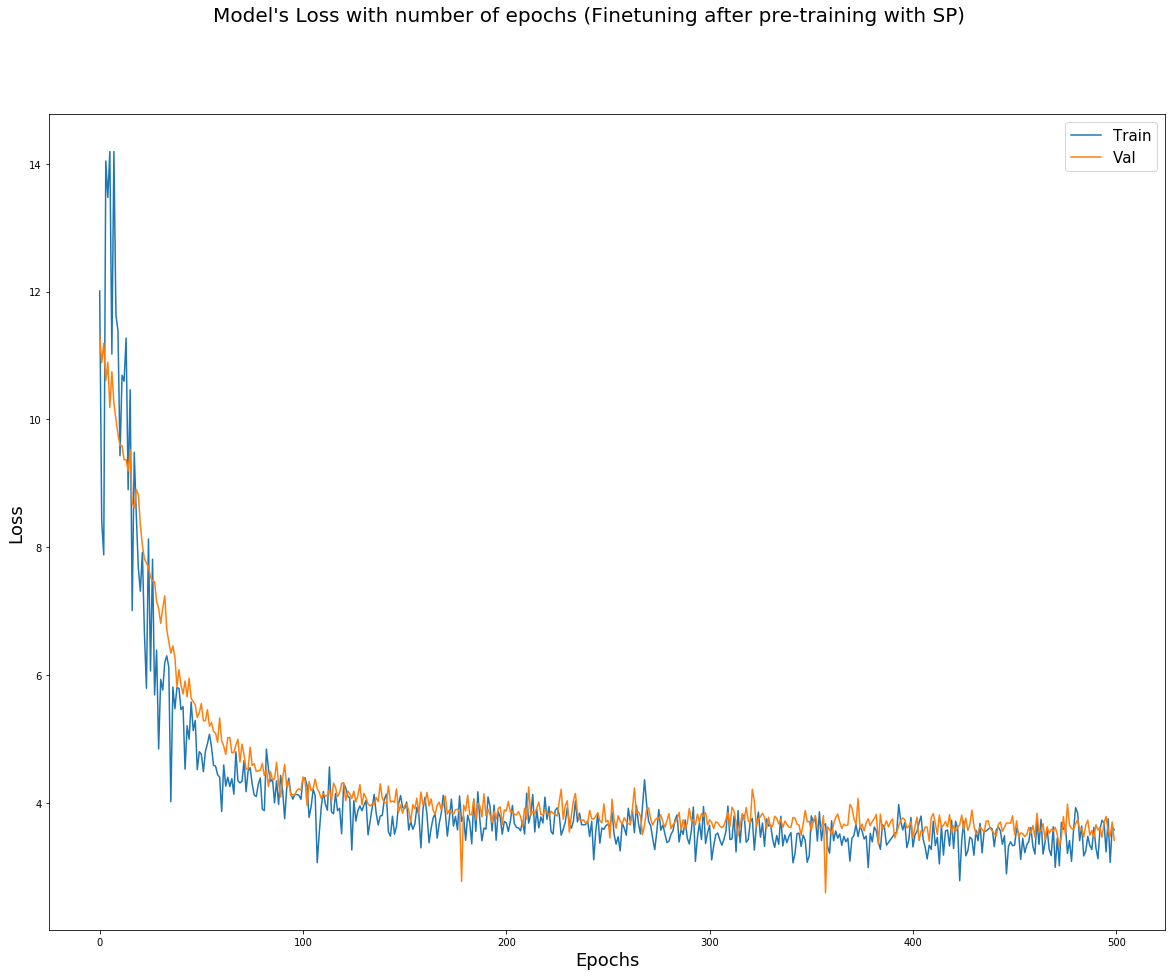

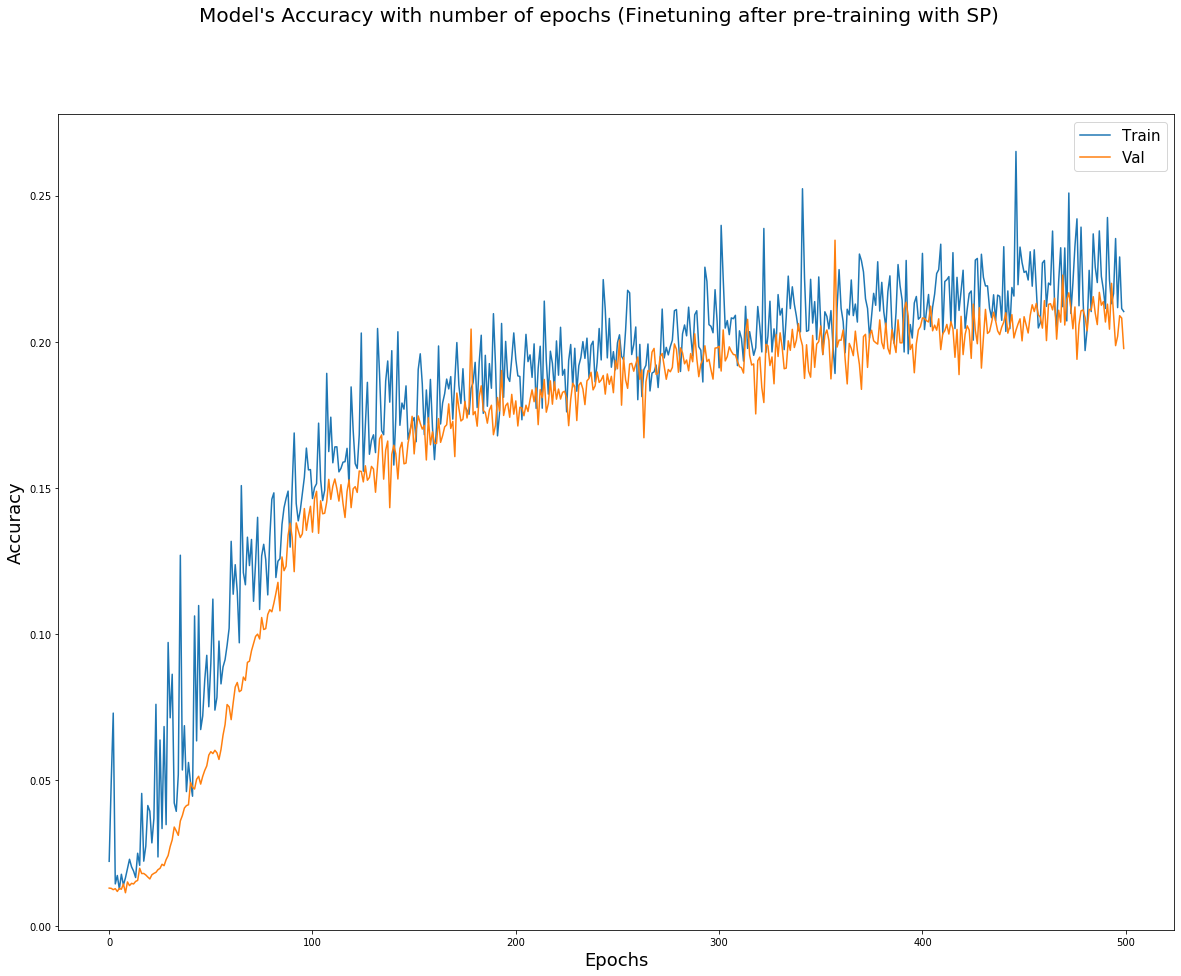

In [93]:
try:
    for round_num in tqdm(range(0, NUM_ROUNDS)):
        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        keras_evaluate(server_state_sp, val_data)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state_sp, server_metrics_sp = iterative_process.next(server_state_sp, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics_sp.loss))
        print('   num_batches: {}'.format(server_metrics_sp.num_batches))
        print('   num_examples: {}'.format(server_metrics_sp.num_examples))
        print('   num_tokens: {}'.format(server_metrics_sp.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics_sp.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics_sp.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics_sp.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker_sp.add_metrics_by_name('loss', server_metrics_sp.loss)
        train_metrics_tracker_sp.add_metrics_by_name('accuracy', server_metrics_sp.accuracy)
        
        np.save('train_accuracy_finetuning_sp.npy', train_metrics_tracker_sp.get_metrics_by_name('accuracy'))
        np.save('val_accuracy_finetuning_sp.npy', val_metrics_tracker_sp.get_metrics_by_name('accuracy'))
        
        np.save('train_loss_finetuning_sp.npy', train_metrics_tracker_sp.get_metrics_by_name('loss'))
        np.save('val_loss_finetuning_sp.npy', val_metrics_tracker_sp.get_metrics_by_name('loss'))

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Model\'s Loss with number of epochs (Finetuning after pre-training with SP)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    fig.savefig('Loss_with_Epochs_finetuning_sp.jpg')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Model\'s Accuracy with number of epochs (Finetuning after pre-training with SP)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    fig2.savefig('Accuracy_with_Epochs_finetuning_sp.jpg')
    plt.show()

### Retrieve the previously saved numpy arrays for Loss and Accuracy for Training without any pretraining

In [94]:
import numpy as np
train_loss_no_pt_embed = np.load('train_loss_no_pt_embed.npy')
train_accuracy_no_pt_embed = np.load('train_accuracy_no_pt_embed.npy')
val_loss_no_pt_embed = np.load('val_loss_no_pt_embed.npy')
val_accuracy_no_pt_embed = np.load('val_accuracy_no_pt_embed.npy')

### Plot Model's Loss for both models, with and without the Shakespeare based pre-training

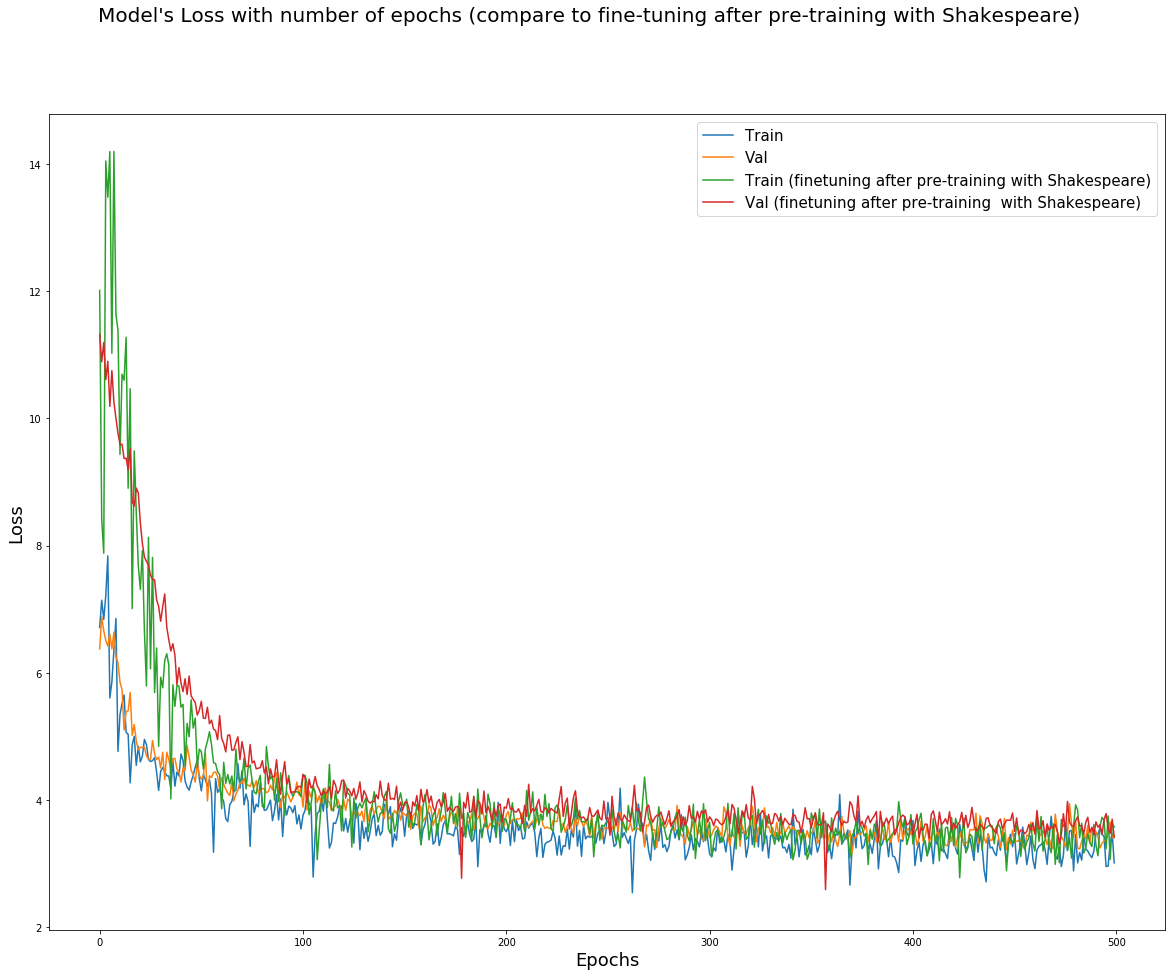

In [95]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss_no_pt_embed, label='Train')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('loss'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('loss'), label='Val (finetuning after pre-training  with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs (compare to fine-tuning after pre-training with Shakespeare)', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs_compare_finetuning_sp.jpg')
plt.show()

### Plot Model's Accuracy for both models, with and without the Shakespeare based pre-training

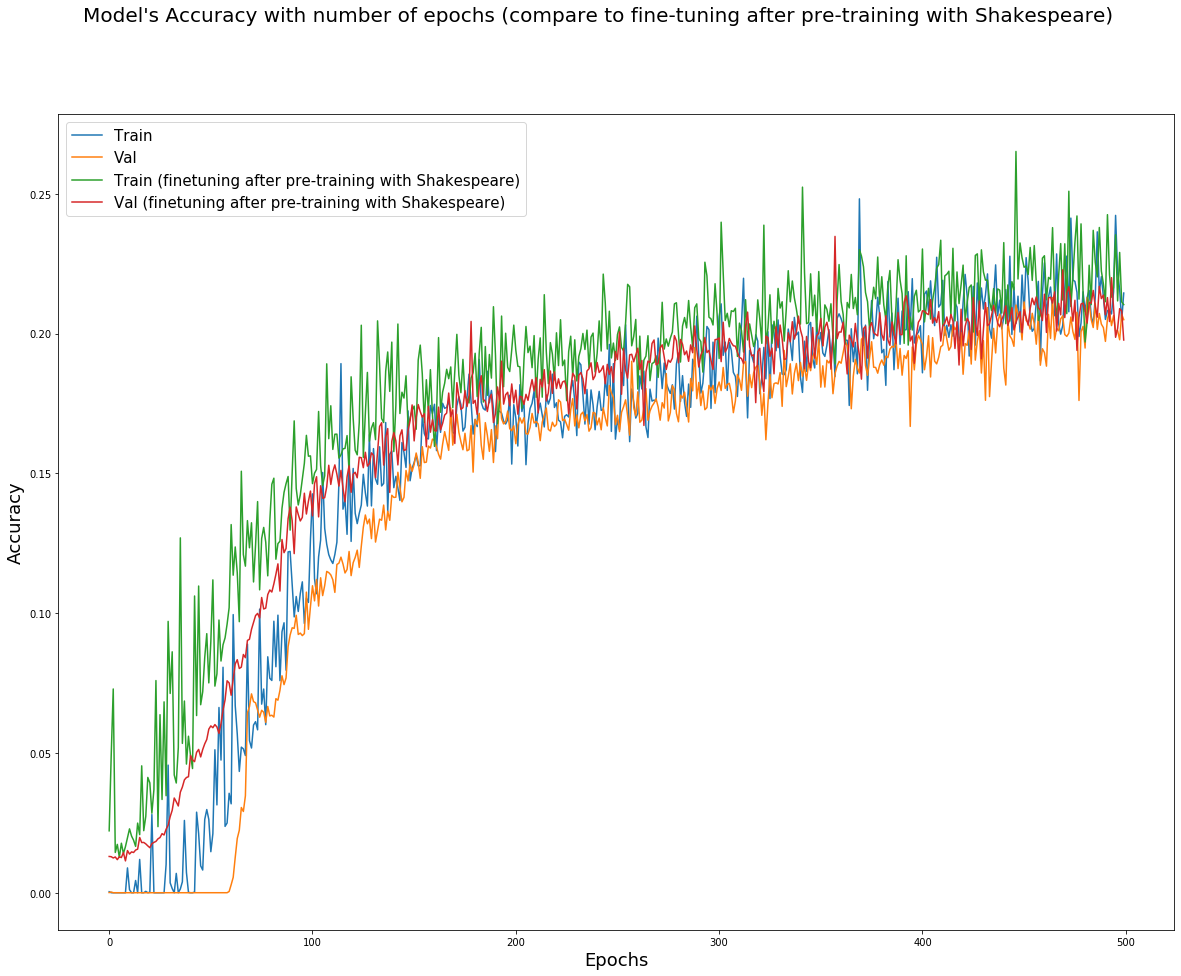

In [96]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Val (finetuning after pre-training with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs (compare to fine-tuning after pre-training with Shakespeare)', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs_compare_finetuning_sp.jpg')
plt.show()

In [98]:
train_loss_finetuning_so = np.load('train_loss_finetuning.npy')
train_accuracy_finetuning_so = np.load('train_accuracy_finetuning.npy')
val_loss_finetuning_so = np.load('val_loss_finetuning.npy')
val_accuracy_finetuning_so = np.load('val_accuracy_finetuning.npy')

## Plots comparing no pre-training, pre-training with SO and pre-training with Shakespeare

### First the Loss Plot

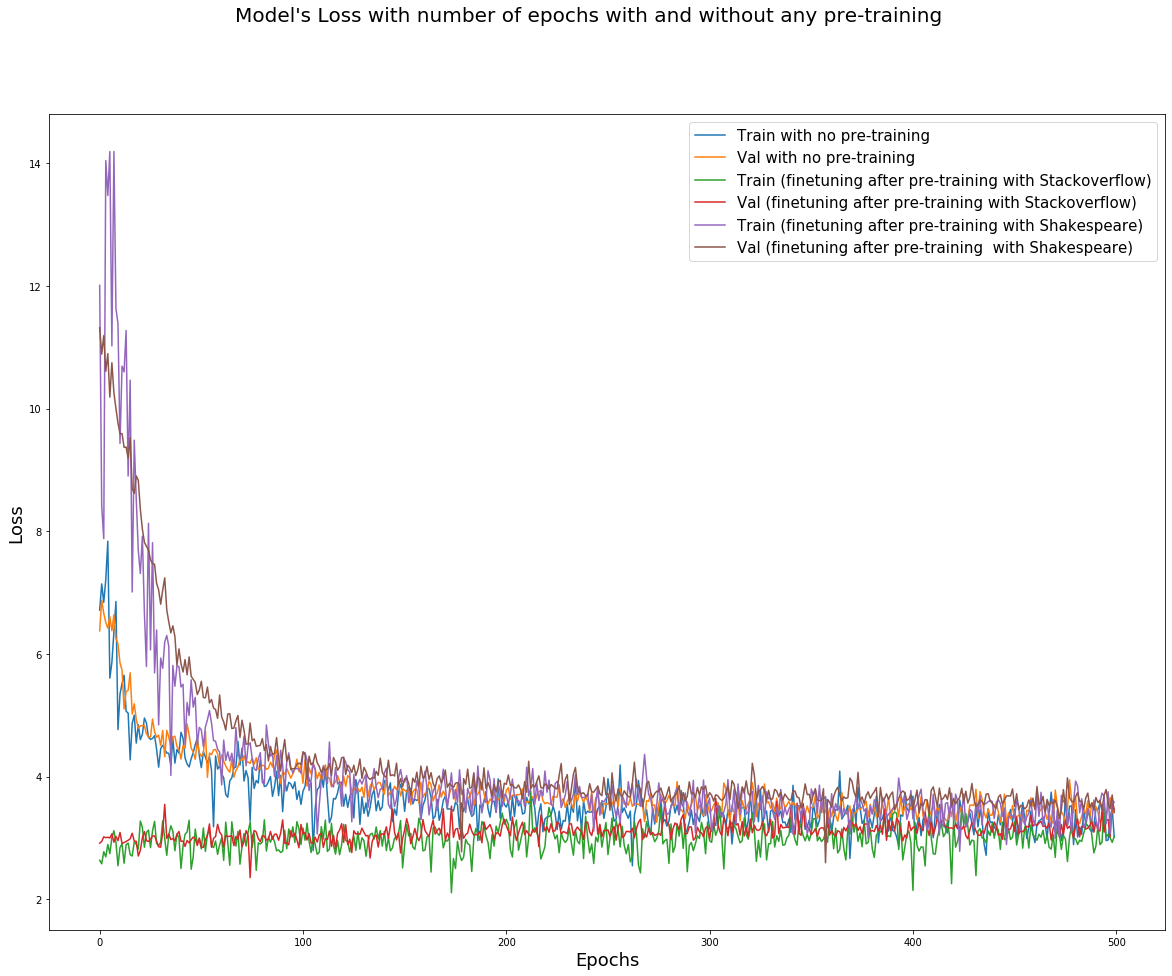

In [100]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss_no_pt_embed, label='Train with no pre-training')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val with no pre-training')
ax.plot(x_axis, train_loss_finetuning_so, label='Train (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, val_loss_finetuning_so, label='Val (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('loss'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('loss'), label='Val (finetuning after pre-training  with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs with and without any pre-training', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs_with_without_pretrain.jpg')
plt.show()

### Next the Accuracy Plot

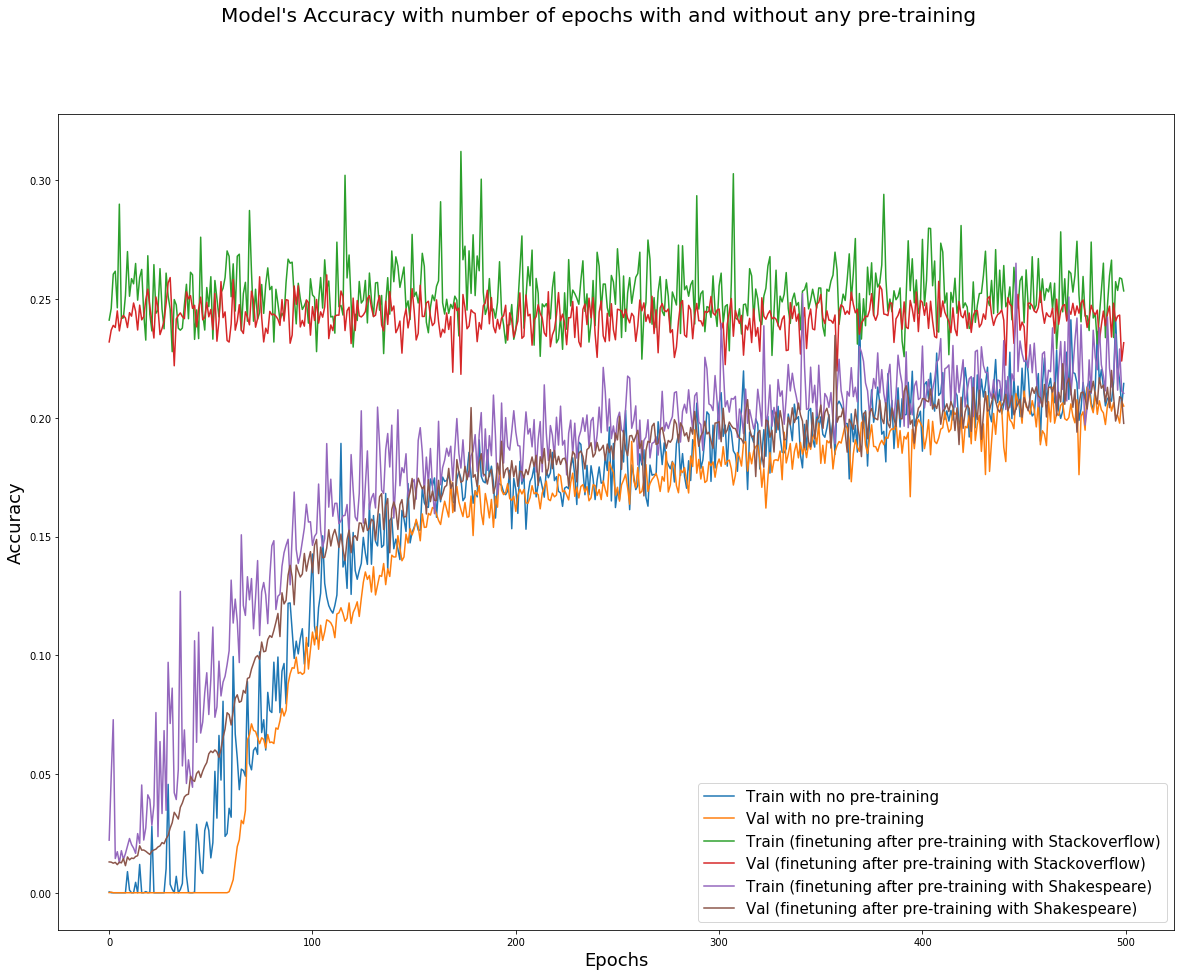

In [101]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train with no pre-training')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val with no pre-training')
ax.plot(x_axis, train_accuracy_finetuning_so, label='Train (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, val_accuracy_finetuning_so, label='Val (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Val (finetuning after pre-training with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs with and without any pre-training', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs_with_without_pretrain.jpg')
plt.show()

### Loading the results from the training done using the pre-trained GloVe Word Embeddings layer

In [102]:
train_loss_with_pt_embed = np.load('train_loss_with_pt_embed.npy')
train_accuracy_with_pt_embed = np.load('train_accuracy_with_pt_embed.npy')
val_loss_with_pt_embed = np.load('val_loss_with_pt_embed.npy')
val_accuracy_with_pt_embed = np.load('val_accuracy_with_pt_embed.npy')

## Plots comparing no pre-training, pre-training with SO and pre-training with Shakespeare, as well as the pre-trained GloVe Word Embedding Layer's results

### First the Loss Plot

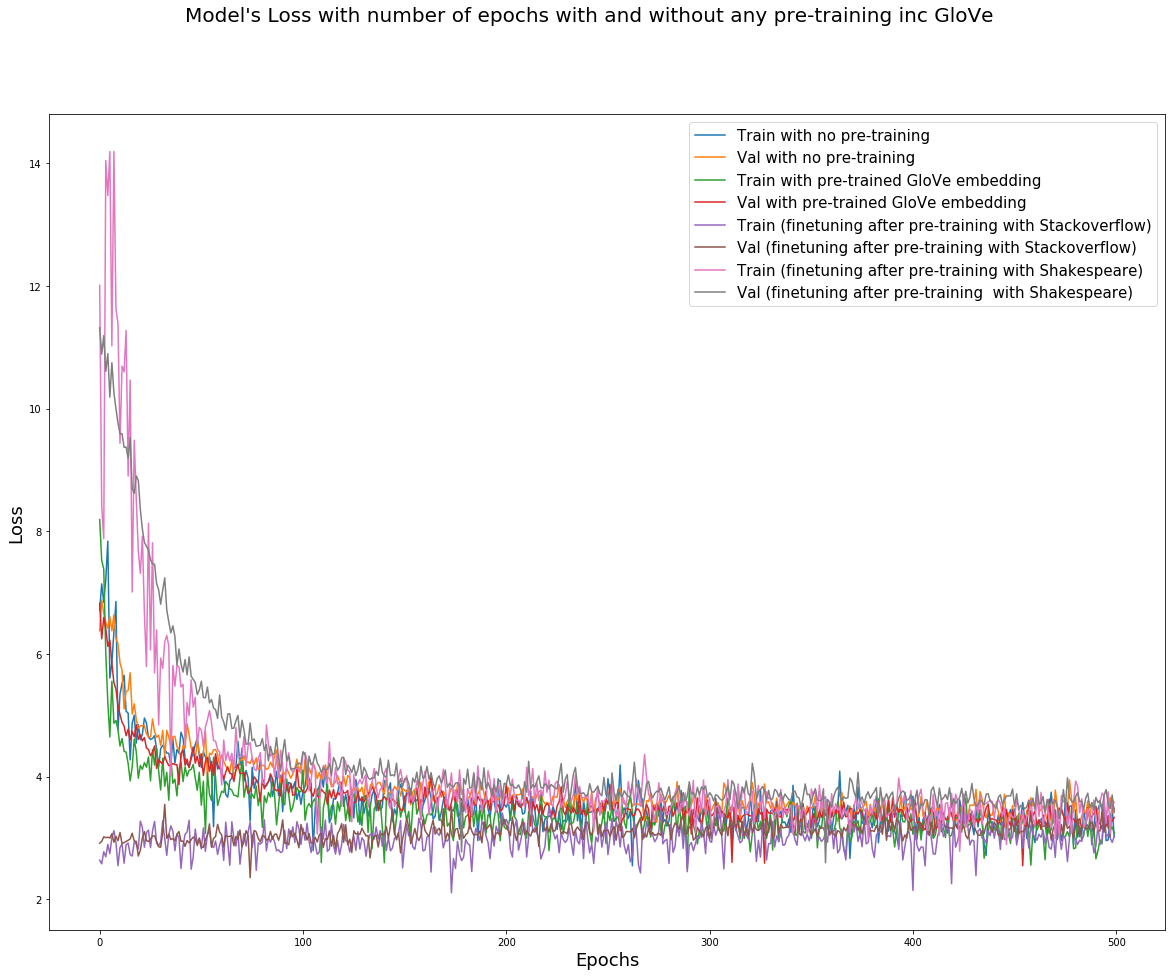

In [103]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss_no_pt_embed, label='Train with no pre-training')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val with no pre-training')
ax.plot(x_axis, train_loss_with_pt_embed, label='Train with pre-trained GloVe embedding')
ax.plot(x_axis, val_loss_with_pt_embed, label='Val with pre-trained GloVe embedding')
ax.plot(x_axis, train_loss_finetuning_so, label='Train (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, val_loss_finetuning_so, label='Val (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('loss'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('loss'), label='Val (finetuning after pre-training  with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs with and without any pre-training inc GloVe', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs_with_without_pretrain_inc_glove.jpg')
plt.show()

### Next the Accuracy Plot

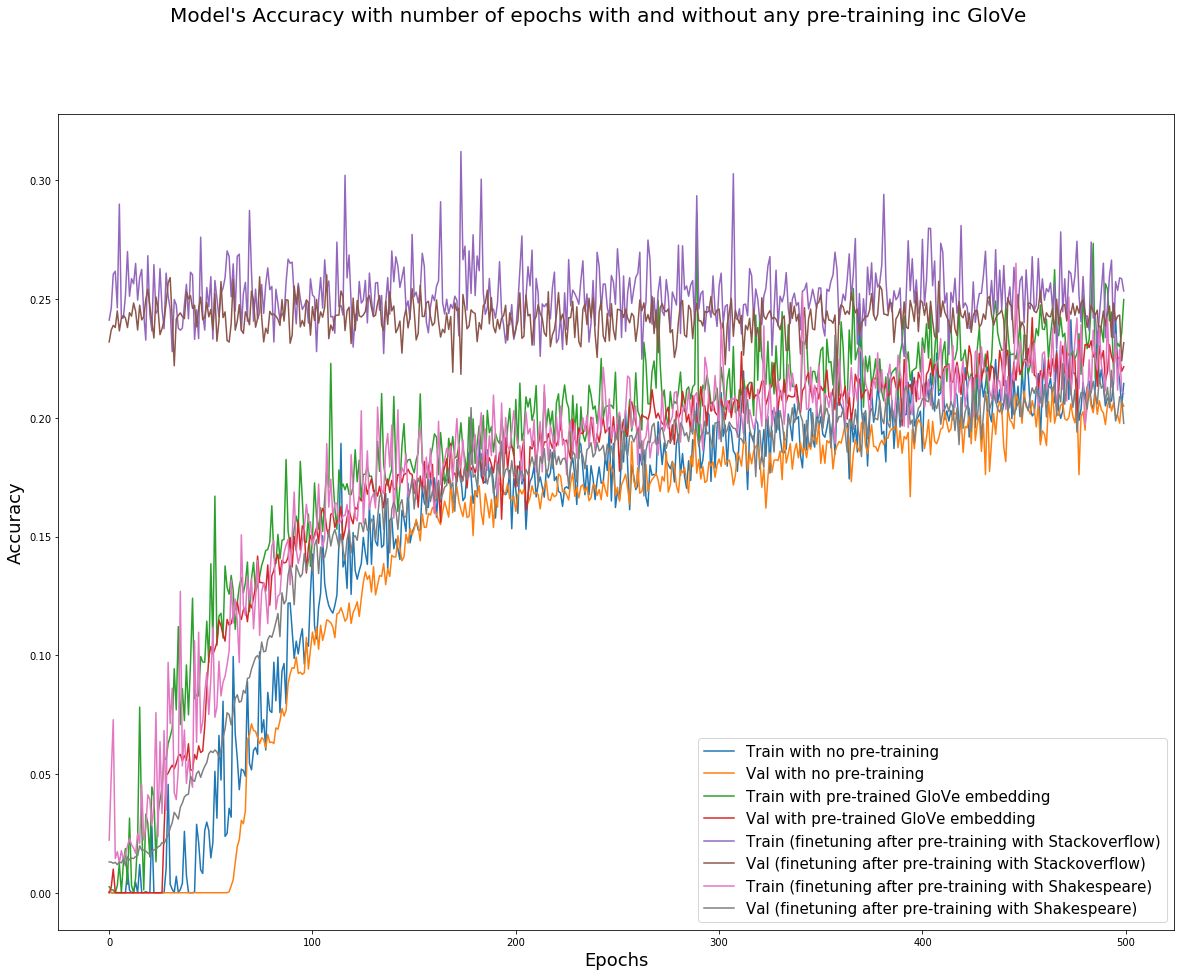

In [104]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train with no pre-training')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val with no pre-training')
ax.plot(x_axis, train_accuracy_with_pt_embed, label='Train with pre-trained GloVe embedding')
ax.plot(x_axis, val_accuracy_with_pt_embed, label='Val with pre-trained GloVe embedding')
ax.plot(x_axis, train_accuracy_finetuning_so, label='Train (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, val_accuracy_finetuning_so, label='Val (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Val (finetuning after pre-training with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs with and without any pre-training inc GloVe', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs_with_without_pretrain_inc_glove.jpg')
plt.show()